# 2020 03 03
## Testing prpa cin senders and cin receivers  
50nM rpa ahl
29C

In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
from matplotlib import cm
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%load_ext line_profiler

%matplotlib inline
output_notebook()

# you need to populate image lists from the two folders

# file_temp = "/mnt/disks/movie-181208/180827_1/{}/img_{:09d}_{}_000.tif"

/home/jmp/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jmp/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jmp/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jmp/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Loading BokehJS ...

In [2]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','False').replace('true','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][:-6],r"%Y-%m-%d %H:%M:%S")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [3]:
def ctime_parworker(fn_list, out_fn):
    n_fn = len(fn_list)
    ctime_vec = [ctime(xx) for xx in fn_list]
    index = pd.Index(data=fn_list, copy=True, name=b'fn')
    out_series = pd.Series(ctime_vec, index=index, name='time')
    out_series.to_csv(out_fn)
    
def ctime_parallel_wrapper(img_files):
    n_proc = 4
    sub_lists = [img_files[i::n_proc] for i in np.arange(n_proc)]
    out_fn_list = ['sub_time_{}.csv'.format(xx) for xx in np.arange(n_proc)]
    worker_inputs = zip(sub_lists, out_fn_list)
    with multiprocessing.Pool(n_proc) as pool:
        pool.starmap(ctime_parworker, worker_inputs)

def ctime_parallel_read_result(img_files):
    fn_list = [xx for xx in os.listdir() if 'sub_time' in xx]
    series = pd.concat([pd.read_csv(fn, index_col=0, header=None,names=['fn','time'],squeeze=True) for fn in fn_list])
#     series.index = [os.path.abspath(xx) for xx in series.index]
    return series.loc[img_files].values

super_dir = '../img_2'
pos_dirs = [os.path.join(super_dir, xx) for xx in os.listdir(super_dir) if os.path.isdir(os.path.join(super_dir, xx))]
img_files = [os.path.join(pos_dir, xx) for pos_dir in pos_dirs for xx in os.listdir(pos_dir) if '.tif' in xx]
# ctime_parallel_wrapper(img_files)
time_vec = ctime_parallel_read_result(img_files)
time_vec = time_vec - time_vec.min()
np.save('timevec.npy',time_vec)

In [4]:
# Extract movie metadata
all_metadata = fn_metadata_full(img_files[0])
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = len(pos_dirs)#summ_dict['Positions']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

In [5]:
img_files[0]

'../img_2/3-Pos_002_005/img_000000091_3_000.tif'

In [6]:
img_re_pattern = r'{}/(?P<pad>[0-9]+)-Pos_(?P<padcol>[0-9]+)_(?P<padrow>[0-9]+)/img_(?P<frame>[0-9]*)_(?P<channel>[0-9]*)_000.tif'.format(super_dir)
rem = re.findall(img_re_pattern, '\n'.join(img_files), re.MULTILINE)
rem_arr = np.array(rem)
rem_arr[rem_arr==''] = -1
metadata_arr = rem_arr.astype(np.int)
n_rows = metadata_arr.shape[0]
pad_vec, padcol_vec, padrow_vec, frame_vec, channel_vec = metadata_arr.T
# padpos_vec = padpos_vec1 + padpos_vec2
pad_vec = pad_vec - np.min(pad_vec)
time_vec = np.load('timevec.npy')
pos_vec = np.empty(n_rows,dtype=np.int)
padpos_vec = np.empty(n_rows,dtype=np.int)

In [7]:
n_frames = np.max(frame_vec)+1

columns = ['pos','pad','padcol','padrow','frame','channel','fn','time']
col_data = [pos_vec, pad_vec, padcol_vec, padrow_vec, frame_vec, channel_vec, img_files, time_vec]
n_rows = len(img_files)
n_pads = len(np.unique(pad_vec))

# files_df = pd.read_csv('filesdf.csv')

files_df = pd.DataFrame(
    dict(zip(columns, col_data)))
files_df = files_df.sort_values(by='time')
files_df = files_df.loc[files_df.frame<n_frames,:]
# gb_pp = files_df.groupby('pad')
# for i, inds in enumerate(gb_pp.groups.values()):
#     files_df.loc[inds,'pos'] = i
gb_pp = files_df.groupby(['padcol','padrow'])
for i, inds in enumerate(gb_pp.groups.values()):
    files_df.loc[inds,'padpos'] = i
files_df.loc[:,'pos'] = np.tile(np.repeat(np.arange(n_pos), n_chan), n_frames)

# def pad_helper_fn(pos):
#     pad_lims = np.array([8,19,32,44,56])
#     pad_inds = np.arange(len(pad_lims))
#     return np.min(pad_inds[pad_lims > pos])

# files_df.loc[:,'pad'] = np.array([pad_helper_fn(xx) for xx in files_df.pos.values])

pos_df = files_df.loc[:,['pos','pad']].groupby('pos').agg(np.min)
files_df.to_csv('filesdf.csv',index=False)

In [8]:
files_df = pd.read_csv('filesdf.csv')
gb_frame = files_df.groupby('frame')
sub_len = np.array([xx[1].shape[0] for xx in gb_frame])
frames = np.array([xx for xx in gb_frame.groups])

# max_frame = frames[1:][np.diff(sub_len)==0].max()
# files_df = files_df.loc[files_df.frame<=max_frame,:]

n_pads = len(np.unique(files_df.pad))
n_frames = np.max(files_df.frame)+1
pos_df = files_df.loc[:,['pos','pad']].groupby('pos').agg(np.min)

In [9]:
label_vec = [xx['Label'] for xx in summ_dict['InitialPositionList']]
xy_vec = [xx['DeviceCoordinatesUm']['XYStage'] for xx in summ_dict['InitialPositionList']]
lab_xy_dict = dict(zip(label_vec, xy_vec))
# [xx.split('/')[2] for xx in tmp_df.fn]

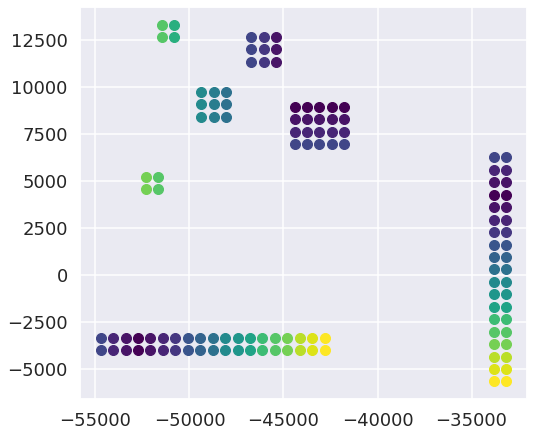

In [10]:
label_vec = [xx['Label'] for xx in summ_dict['InitialPositionList']]
xy_vec = [xx['DeviceCoordinatesUm']['XYStage'] for xx in summ_dict['InitialPositionList']]
label_xy_dict = dict(zip(label_vec, xy_vec))
pos_file_df = files_df.groupby('pos').agg(np.min)
# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad. DF also includes inducer info
# 0, 1, 2 for inducers blank, C, R; respectively
columns = ['x','y','label','pad', 'dist']
n_cols = len(columns)
cor_pos_df = pd.DataFrame(np.empty((n_pos,n_cols)), columns=columns, index=np.arange(n_pos))
for pos in np.arange(n_pos):
    label = pos_file_df.loc[pos,'fn'].split('/')[2]
    x, y = label_xy_dict[label]
    pad = pos_df.loc[pos,'pad']
    cor_pos_df.loc[pos,['x', 'y', 'label', 'pad']] = [x, y, label, pad]
#     files_df.loc[files_df.pos==p_i,'x'] = x
#     files_df.loc[files_df.pos==p_i,'y'] = y

# cor_pos_df.sort_values(by=['pad','padpos'], inplace=True)
    
for p_i in np.arange(n_pos):
    pad = cor_pos_df.loc[p_i,['pad']].values[0]
    if pad in [3,4,5,6]:
        pad_x = cor_pos_df.loc[(cor_pos_df.pad==0),'x'].min()
        pos_x = cor_pos_df.loc[p_i,'x']
    if pad in [1]:
        pad_x = cor_pos_df.loc[(cor_pos_df.pad==pad),'x'].min()+2e3
        pos_x = cor_pos_df.loc[p_i,'x']
    if pad in [2]:
        pad_x = cor_pos_df.loc[(cor_pos_df.pad==pad),'y'].min()+2e3
        pos_x = cor_pos_df.loc[p_i,'y']
    if pad in [0]:
        pad_x = cor_pos_df.loc[(cor_pos_df.pad==pad),'y'].min()
        pos_x = cor_pos_df.loc[p_i,'y']

        
    dist = np.sqrt(np.power(pad_x - pos_x,2).sum())
    cor_pos_df.loc[p_i, 'dist'] = dist
    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist

max_dist = cor_pos_df['dist'].max()
cmap = cm.get_cmap('viridis',20)
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('viridis', n_colors=2)
    point_color = colors[np.int(np.mod(cor_pos_df.loc[p_i,"pad"],2))]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=cmap(cor_pos_df.dist[p_i]/max_dist))
plt.gca().set_aspect('equal')
plt.show()
# plt.legend()

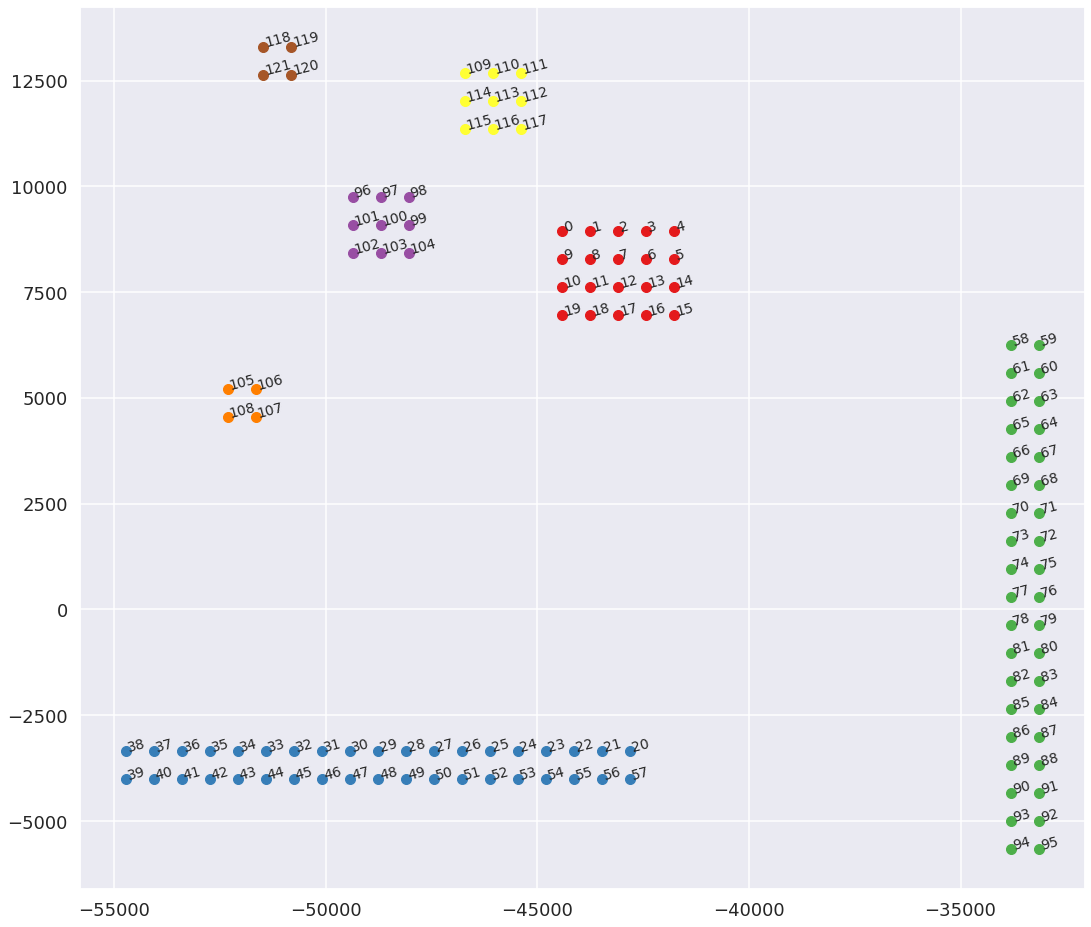

In [11]:
# n_pads=5
plt.figure(figsize=(18,18))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('Set1', n_colors=n_pads)
    point_color = colors[np.int(cor_pos_df.loc[p_i,"pad"])]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.pad[p_i],
             ms=20,
             c=point_color)
    plt.text(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
#              '{}'.format(np.int(cor_pos_df.padpos[p_i])),
#              '{}'.format(pos_file_df.loc[p_i,'fn'].split('/')[2]),
             '{}'.format(p_i),
             fontsize=14,
             rotation=15)

plt.gca().set_aspect('equal')

In [40]:
files_df.head()

pos  pad  padcol  padrow  frame  channel  \
0    0    0       0       0      0        2   
1    0    0       0       0      0        3   
2    1    0       1       0      0        2   
3    1    0       1       0      0        3   
4    2    0       2       0      0        2   

                                               fn  time  padpos  
0  ../img_2/1-Pos_000_000/img_000000000_2_000.tif   0.0     0.0  
1  ../img_2/1-Pos_000_000/img_000000000_3_000.tif   1.0     0.0  
2  ../img_2/1-Pos_001_000/img_000000000_2_000.tif   3.0     4.0  
3  ../img_2/1-Pos_001_000/img_000000000_3_000.tif   5.0     4.0  
4  ../img_2/1-Pos_002_000/img_000000000_2_000.tif   7.0    23.0

In [63]:
fn_list = ['200303_pad{}.tif'.format(xx) for xx in np.arange(n_pads)]
sr_boundaries = np.ones(n_pads)#[1110, 530, 920, 910, 800, 630]
pad_beginnings = np.zeros(n_pads)#[350, 200, 200, 200, 0, 100]
pad_endings = np.zeros(n_pads)#[1000, 200, 200, 1200, 1000, 100]
tup_list = n_pads*[(4,4)]#,(40,10),(40,10)]
vert_list = [False, False, True, False, False, False, False]
flip_list = [False, False, True, True, True, True, True]
lists = [fn_list, pad_beginnings, pad_endings, sr_boundaries, tup_list, vert_list, flip_list]
pad_boundary=0
class  AnalyzePad():
    def __init__(self, pad_ind):
        self.fn, self.pad_begin, self.pad_end, self.sr_boundary, self.scale_tup, self.vert, self.flip = [xx[pad_ind] for xx in lists]

    def dwn_frames(self):
        chan_regions = [self.sender_region, self.receiver_region, self.receiver_region]
        for i, frame_i in enumerate(self.frame_vec):
            for chan_i in [0,1]:
                frame = self.get_frame(frame_i, chan_i)
                thresh = skimage.filters.threshold_li(frame)
                thresh = np.max([40,thresh])
                im_occ = frame > thresh
                self.dwn_arr[i, chan_i, :, :] = skimage.transform.downscale_local_mean(frame, self.scale_tup)
                self.dwn_prf[i, chan_i, :, :] = skimage.transform.downscale_local_mean(im_occ, self.scale_tup)
    
    def get_frame(self, frame_ind, chan_ind):
        # grab single frame from tiff file and reshape as necessary
        with skimage.external.tifffile.TiffFile(self.fn) as im:
            img = im.asarray(memmap=True)[np.int(frame_ind*2 + chan_ind),:,:].copy()
            if self.vert:
                img = img.T
            elif self.flip:
                img = img[:,::-1]
        return img

    def make_dwnsmpl(self, frame_vec):
        # Read initial img and make empty dwn array
        self.frame_vec = frame_vec
        img0 = self.get_frame(frame_vec[0],0)
        h, w = img0.shape
        self.sender_region = np.arange(self.pad_begin, self.sr_boundary)
        self.receiver_region = np.arange(self.sr_boundary, w-self.pad_end)
        sh, sw = np.ceil(np.array((h, w)) / np.array(self.scale_tup)).astype(np.int)
        n_frames = len(frame_vec)
        self.dwn_arr = np.zeros((n_frames, 2, sh, sw))
        self.dwn_prf = np.zeros((n_frames, 2, sh, sw))
        self.dwn_frames()
        self.scaled_w, self.scaled_h = sw, sh
        self.w, self.h = w, h

frame_vec = np.arange(0,n_frames)
pads = [AnalyzePad(xx) for xx in np.arange(n_pads)]
_ = [pad.make_dwnsmpl(frame_vec) for pad in pads]


/home/jmp/anaconda3/lib/python3.7/site-packages/skimage/util/shape.py:93: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


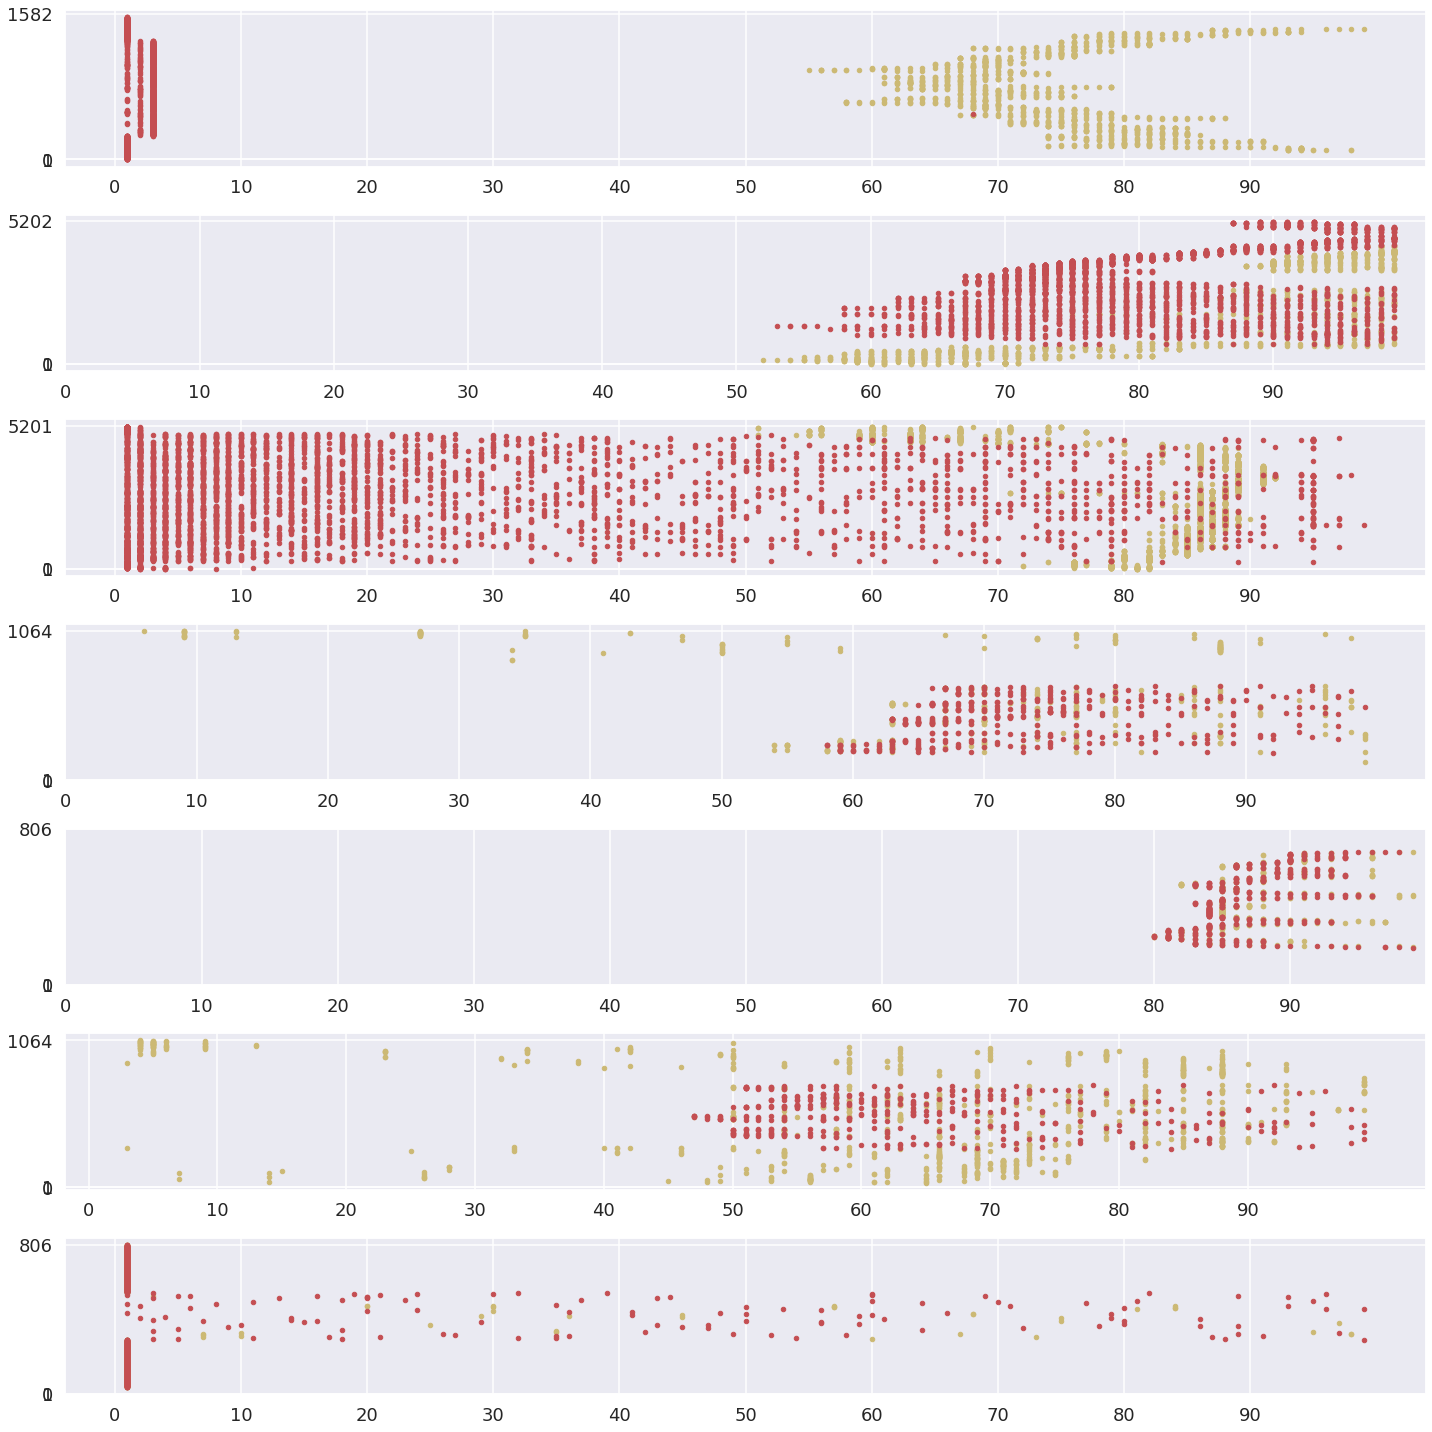

In [64]:
# Try your column-by-column threshold crossing approach
fig, axs = plt.subplots(n_pads, 1, figsize=(20,20))
# pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]
colors=['y','r','c']
for pad_i in np.arange(n_pads):
    pad = pads[pad_i]
    sr_boundary, pad_begin, pad_end = pad.sr_boundary, pad.pad_begin, pad.w - pad.pad_end
    sender_region = np.arange(pad_begin, sr_boundary)
    receiver_region = np.arange(sr_boundary, pad_end)
    n_frames = len(pad.frame_vec)
    frame0 = pad.frame_vec[0]
    chan_regions = [sender_region, receiver_region, receiver_region]
    for chan_i in [0,1]:
        w = pad.w
        summed_arr = np.zeros((n_frames, w))
        for frame_i in pad.frame_vec:
            img = pad.get_frame(frame_i, chan_i)
            summed_arr[frame_i-frame0,:] = img.sum(axis=0)
        frame_arr = np.tile(pad.frame_vec.reshape(n_frames,1),(1,w))
        pos_arr = np.tile(np.arange(w).reshape(1,w),(n_frames,1))
        thresh = skimage.filters.threshold_li(summed_arr)
        bool_arr = summed_arr > thresh
        thresh_frames = (bool_arr*frame_arr).flatten()
        thresh_pos = (bool_arr*pos_arr).flatten()
        cross_df = pd.DataFrame(dict(zip(['frame','pos'],[thresh_frames,thresh_pos])))
        cross_df.drop(cross_df.index[cross_df.frame==0],inplace=True,axis=0)
        cross_df = cross_df.groupby('pos').agg(np.min).reset_index()
        cross_frame, cross_pos = cross_df.loc[:,['frame','pos']].values.T
#         axs[pad_i,chan_i-1].imshow(summed_arr,aspect=200) 
        axs[pad_i].plot(cross_frame, cross_pos,'.',color=colors[chan_i])
    axs[pad_i].set_yticks([pad_begin, sr_boundary, pad_end])
    axs[pad_i].set_xticks(np.arange(0,n_frames,10))
#         print(cross_df)
#         axs[pad_i, chan_i].plot(x_arr.T, avg_fluor.T,'.')#,vmin=1e2,vmax=7e3,aspect=8)
fig.tight_layout()

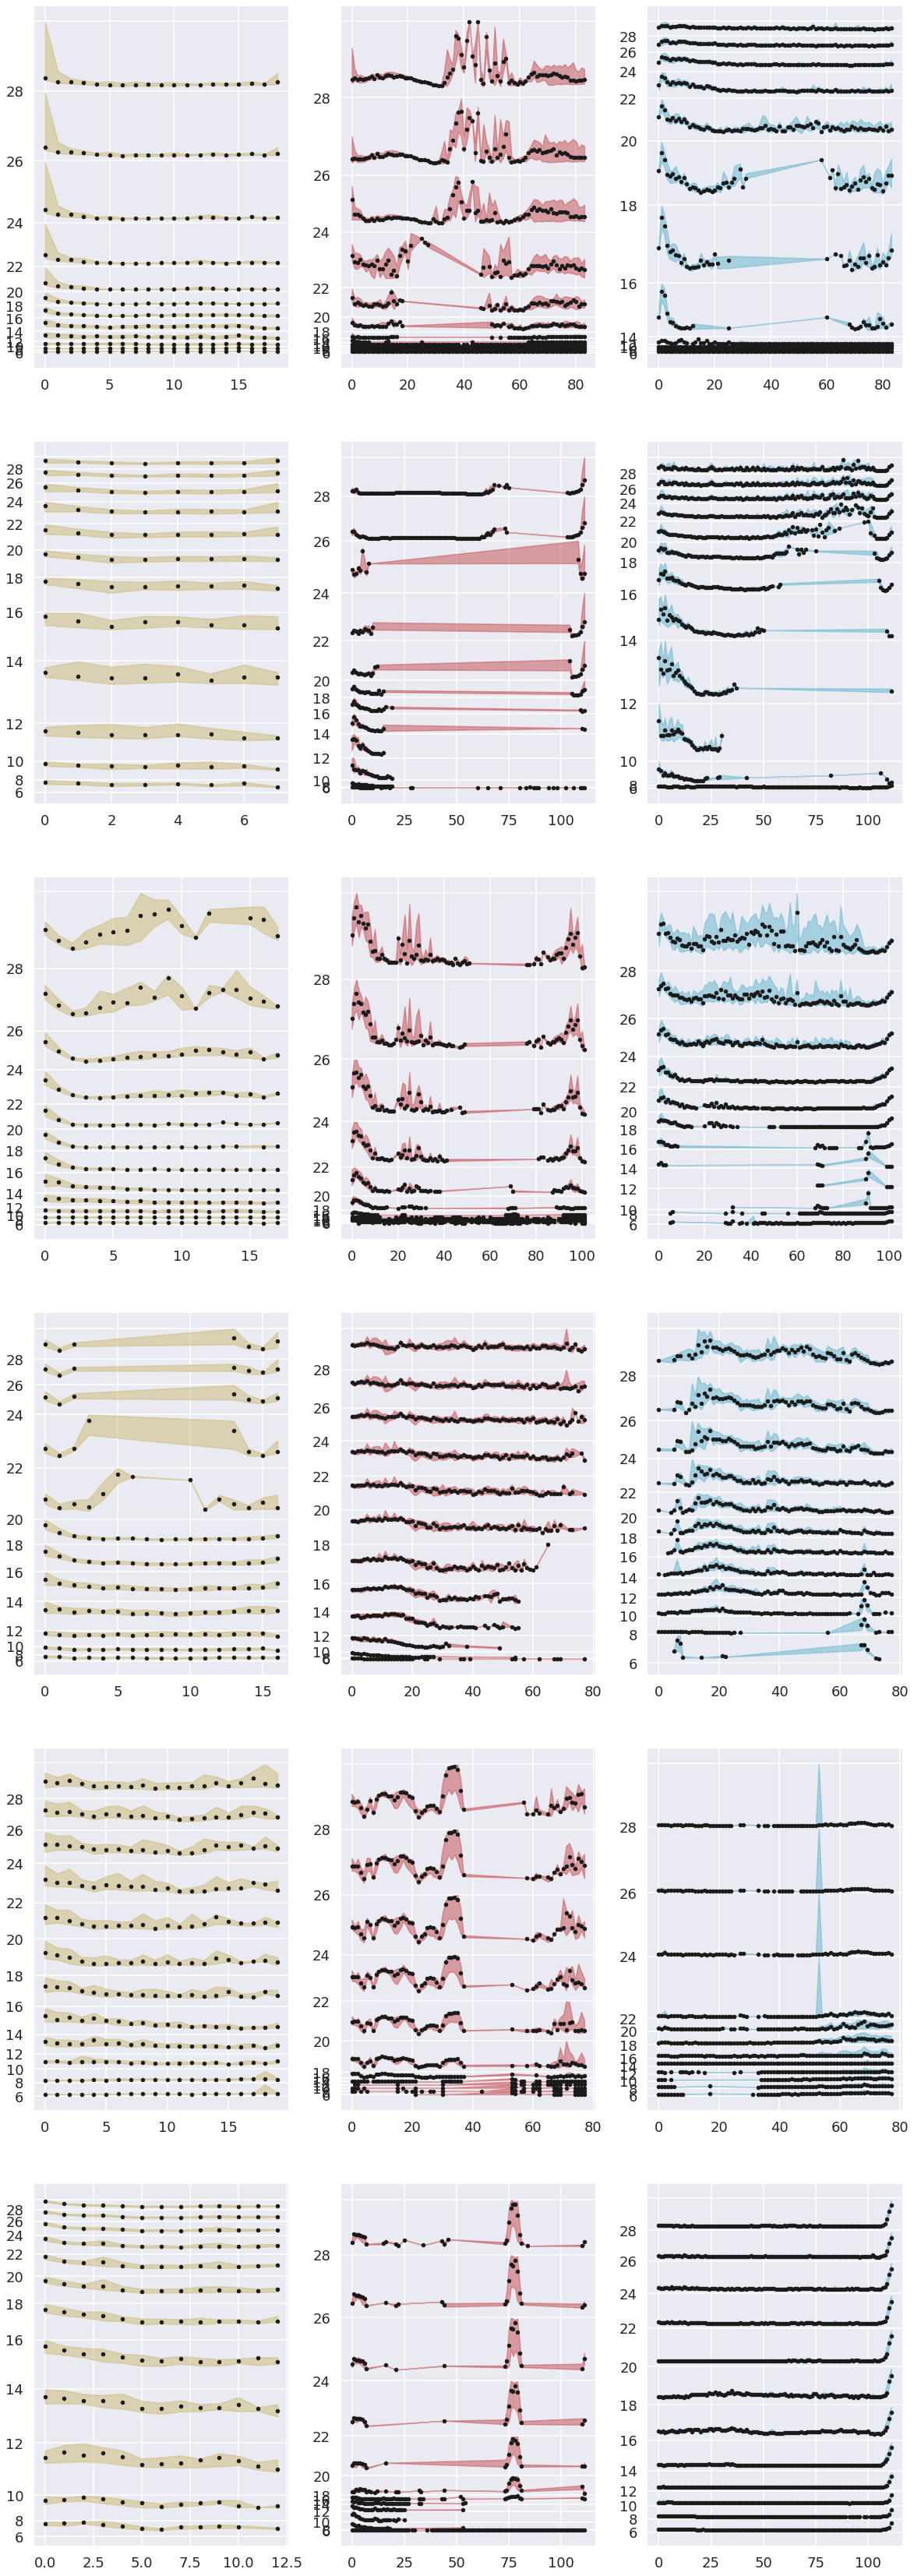

In [229]:
fig, axs = plt.subplots(6, 3, figsize=(20,60))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]
colors=['y','r','c']
for pad_i in np.arange(6):
    pad = pad_list[pad_i]
    sr_boundary = np.int(pad.sr_boundary / pad.scale_tup[1])
    pad_begin = np.int(pad.pad_begin / pad.scale_tup[1])
    pad_end = np.int((pad.w - pad.pad_end) / pad.scale_tup[1])
    dwn_arr = pad.dwn_arr.copy()
    prf_arr = pad.dwn_prf.copy()
    dwn_arr[np.isnan(dwn_arr)] = 0
    for chan_i in [0,1,2]:
        dwn_frame = dwn_arr[:,chan_i,:,:]
        prf_frame = prf_arr[:,chan_i,:,:]
        if chan_i == 0:
            dwn_frame = dwn_frame[:,:,pad_begin:sr_boundary]
            prf_frame = prf_frame[:,:,pad_begin:sr_boundary]
        else:
            dwn_frame = dwn_frame[:,:,sr_boundary:pad_end]
            prf_frame = prf_frame[:,:,sr_boundary:pad_end]
        im_mask = prf_frame > 0.1
        prf_frame[False==im_mask] = np.inf
        avg_fluor = (dwn_frame*im_mask)/prf_frame
        n_frames, im_h, im_w = dwn_frame.shape
        x_arr = np.tile(np.arange(im_w).reshape((1, im_w)), (im_h,1))
        frame_max = 0
        yticks = [frame_max]
        for frame_i in pad.frame_vec[::2]-pad.frame_vec.min():
            frame_avg_fluor = avg_fluor[frame_i,:,:]
            frame_im_mask = im_mask[frame_i,:,:]
            frame_prf = prf_frame[frame_i,:,:]
            frame_avg_fluor[np.isnan(frame_avg_fluor)] = 0
#             t_arr = np.tile(pad.frame_vec.reshape((n_frames,1)), (1,im_w))
            columns = ['fluor','occ','mask','pos']
            data = [frame_avg_fluor.flatten(),frame_prf.flatten(),frame_im_mask.flatten(),x_arr.flatten()]
            df = pd.DataFrame(dict(zip(columns, data)))
            df.drop(df.index[df.fluor==0],inplace=True,axis=0)
            df.sort_values(by='fluor', inplace=True)
            gb_x = df.groupby('pos')
            x_vec = np.arange(im_w)
            top_vec = np.zeros(im_w)
            bot_vec = np.zeros(im_w)
            med_vec = np.zeros(im_w)
            for xx in x_vec:
                if xx in gb_x.groups.keys():
                    sub_df = gb_x.get_group(xx)
                    n = sub_df.shape[0]
                    if n < 4:
                        top_vec[xx] = sub_df.fluor.values.max()
                        med_vec[xx] = sub_df.fluor.values.mean()
                        bot_vec[xx] = sub_df.fluor.values.min()
                    else:
                        top_vec[xx] = sub_df.fluor.values[np.int(0.75*n)]
                        med_vec[xx] = sub_df.fluor.values[np.int(n/2)]
                        bot_vec[xx] = sub_df.fluor.values[np.int(0.25*n)]
            keep_bool = top_vec > 0
            x_vec = x_vec[keep_bool]
            top_vec = top_vec[keep_bool] + frame_max
            med_vec = med_vec[keep_bool] + frame_max
            bot_vec = bot_vec[keep_bool] + frame_max
            axs[pad_i,chan_i].fill_between(x_vec, top_vec, bot_vec, alpha=0.5,color=colors[chan_i])
            axs[pad_i,chan_i].plot(x_vec, med_vec,'.k')
            frame_max = np.max(top_vec)+100
            yticks.append(frame_max)
        axs[pad_i,chan_i].set_yticks(yticks)
        axs[pad_i,chan_i].set_yticklabels(pad.frame_vec[::2])
#         axs[pad_i, chan_i].plot(x_arr.T, avg_fluor.T,'.')#,vmin=1e2,vmax=7e3,aspect=8)

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


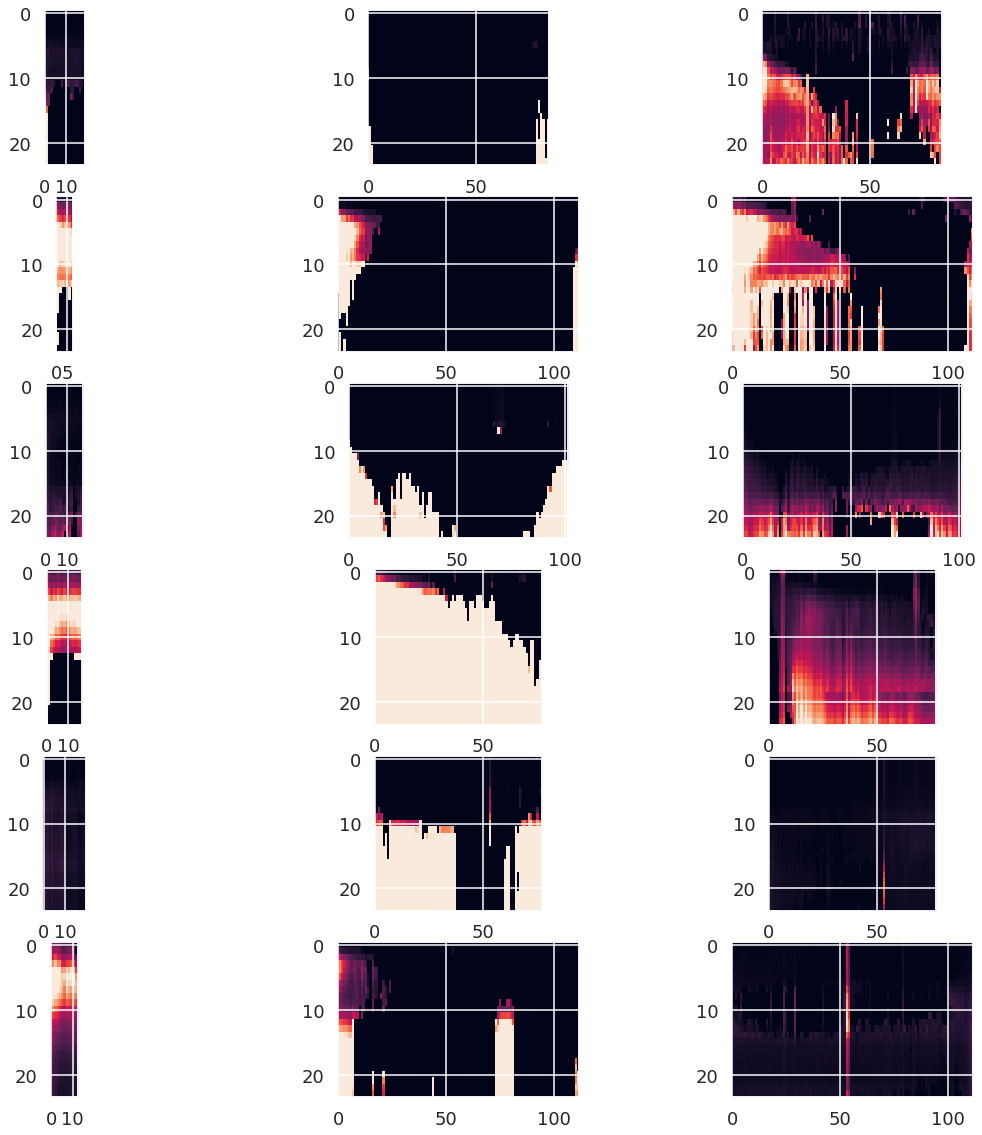

In [194]:
fig, axs = plt.subplots(6, 3, figsize=(20,20))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]

for pad_i in np.arange(6):
    pad = pad_list[pad_i]
    sr_boundary = np.int(pad.sr_boundary / pad.scale_tup[1])
    pad_begin = np.int(pad.pad_begin / pad.scale_tup[1])
    pad_end = np.int((pad.w - pad.pad_end) / pad.scale_tup[1])
    dwn_arr = pad.dwn_arr.copy()
    prf_arr = pad.dwn_prf.copy()
    dwn_arr[np.isnan(dwn_arr)] = 0
    for chan_i in [0,1,2]:
        dwn_frame = dwn_arr[:,chan_i,:,:]
        prf_frame = prf_arr[:,chan_i,:,:]
        if chan_i == 0:
            dwn_frame = dwn_frame[:,:,pad_begin:sr_boundary]
            prf_frame = prf_frame[:,:,pad_begin:sr_boundary]
        else:
            dwn_frame = dwn_frame[:,:,sr_boundary:pad_end]
            prf_frame = prf_frame[:,:,sr_boundary:pad_end]
        n_frames, im_h, im_w = dwn_frame.shape
        im_mask = prf_frame > 0.1
        avg_fluor = (dwn_frame*im_mask).sum(axis=1)/prf_frame.sum(axis=1)
        avg_fluor[np.isnan(avg_fluor)] = 0
        t_arr = np.tile(pad.frame_vec.reshape((n_frames,1)), (1,im_w))
        x_arr = np.tile(np.arange(im_w).reshape((1, im_w)), (n_frames,1))
        axs[pad_i, chan_i].imshow(avg_fluor,vmin=1e2,vmax=7e3,aspect=3)

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


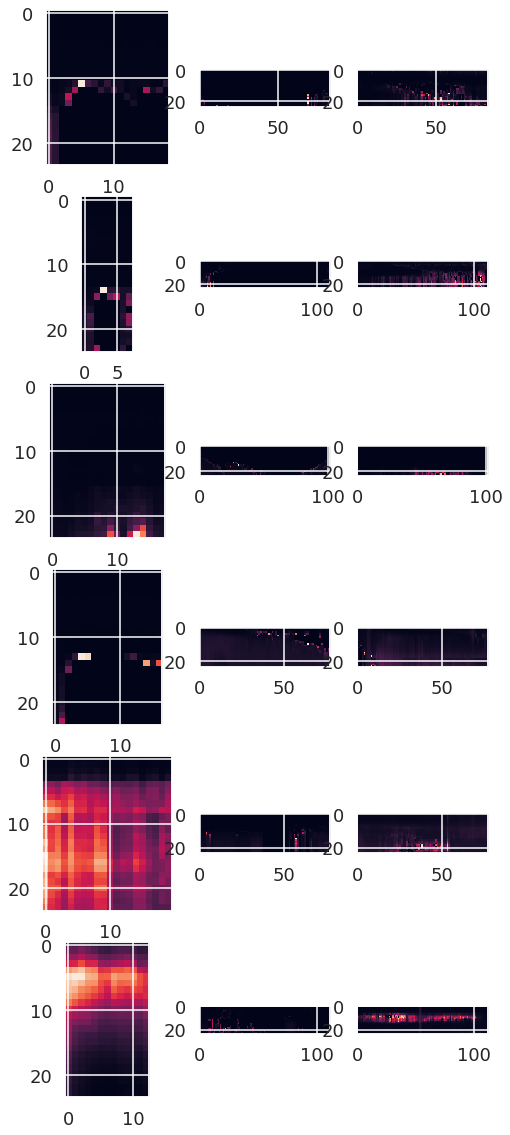

In [122]:
fig, axs = plt.subplots(6, 3, figsize=(8,20))
pad_list = [pads[xx] for xx in [0,1,2,3,4,5]]

for pad_i in np.arange(6):
    pad = pad_list[pad_i]
    sr_boundary = np.int(pad.sr_boundary / pad.scale_tup[1])
    pad_begin = np.int(pad.pad_begin / pad.scale_tup[1])
    pad_end = np.int((pad.w - pad.pad_end) / pad.scale_tup[1])
    dwn_arr = pad.dwn_arr.copy()
    prf_arr = pad.dwn_prf.copy()
    dwn_arr[np.isnan(dwn_arr)] = 0
    for chan_i in [0,1,2]:
        dwn_frame = dwn_arr[:,chan_i,:,:]
        prf_frame = prf_arr[:,chan_i,:,:]
        if chan_i == 0:
            dwn_frame = dwn_frame[:,:,pad_begin:sr_boundary]
            prf_frame = prf_frame[:,:,pad_begin:sr_boundary]
        else:
            dwn_frame = dwn_frame[:,:,sr_boundary:pad_end]
            prf_frame = prf_frame[:,:,sr_boundary:pad_end]
        im_mask = prf_frame>0
        avg_fluor = (dwn_frame*im_mask).sum(axis=1)/prf_frame.sum(axis=1)
        avg_fluor[np.isnan(avg_fluor)] = 0
        axs[pad_i, chan_i].imshow(avg_fluor)#,vmin=0,vmax=8e3,aspect=4)

In [18]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_movie(scale=4, pad_ind=3, skip=5):
    n_frames = files_df.frame.max()+1
    h, w = im_height//scale, im_width//scale
    plt.close('all')
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()+1400])*pixels_per_um
    ylims = np.array([pad_df.y.min(), pad_df.y.max()+1400])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    pad_arr = np.zeros((pad_h, pad_w, 2))
    img_arr = np.zeros((pad_h, pad_w, 3))
#     yfp_norm = mpl_colors.Normalize(2e2, 1e4,clip=True)
#     rfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
#     cfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
    yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
    rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    chan_vec = [2,3]#,5]
    norm_vec = [yfp_norm, rfp_norm]#, cfp_norm]
    
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)

    count_arr = np.zeros((pad_h, pad_w))
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+h,x0:x0+w] += 1
    count_arr[count_arr<=0] = 1

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        bg_arr = np.zeros((h,w))
        im_arr = np.zeros((h,w))
        # get background image
        bg_pos_list = [118,119,120,121]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            bg_arr[:] = 0
            bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+h,x0:x0+w,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    im = ax.imshow(img_arr, animated=True, interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        img_arr[:,:,0] = rfp_norm(pad_arr[:,:,1]) + 0.75*yfp_norm(pad_arr[:,:,0])
        img_arr[:,:,1] = 0.75*yfp_norm(pad_arr[:,:,0]) #+ 0.75*cfp_norm(pad_arr[:,:,2])
#        img_arr[:,:,2] = 0.75*cfp_norm(pad_arr[:,:,2])
        im.set_array(img_arr)

    anim = anm.FuncAnimation(fig, animate, interval=100, frames=np.arange(0,n_frames,skip))


    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads):
    anim = write_movie(scale=8, pad_ind=pad_ind,skip=2)
    anim.save('200303_pad{}.gif'.format(pad_ind), dpi=80, fps=5, writer='pillow')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_frame(frame=0, scale=4, pad_ind=3, skip=5):
    h, w = im_height//scale, im_width//scale
    plt.close('all')
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()+1400])*pixels_per_um
    ylims = np.array([pad_df.y.min(), pad_df.y.max()+1400])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    fig_h, fig_w = np.array([pad_h, pad_w])/(100/scale)
    pad_arr = np.zeros((pad_h, pad_w, 2))
    img_arr = np.zeros((pad_h, pad_w, 3))
    yfp_norm = mpl_colors.Normalize(10, 5e3,clip=True)
    rfp_norm = mpl_colors.Normalize(10, 1e4,clip=True)
    cfp_norm = mpl_colors.Normalize(10, 1e4,clip=True)
    chan_vec = [2,3]#,5]
    norm_vec = [yfp_norm, rfp_norm]#, cfp_norm]
    
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)

    count_arr = np.zeros((pad_h, pad_w))
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+h,x0:x0+w] += 1
    count_arr[count_arr<=0] = 1

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        bg_arr = np.zeros((h,w))
        im_arr = np.zeros((h,w))
        # get background image
        bg_pos_list = [118,119,120,121]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            bg_arr[:] = 0
            bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+h,x0:x0+w,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr

    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    im = ax.imshow(img_arr, animated=True, interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        img_arr[:,:,0] = rfp_norm(pad_arr[:,:,1]) + 0.75*yfp_norm(pad_arr[:,:,0])
        img_arr[:,:,1] = 0.75*yfp_norm(pad_arr[:,:,0]) #+ 0.75*cfp_norm(pad_arr[:,:,2])
#        img_arr[:,:,2] = 0.75*cfp_norm(pad_arr[:,:,2])
        im.set_array(img_arr)
    animate(frame)
    plt.savefig('200303_pad{}_frame.png'.format(pad_ind, frame), dpi=80)
#     anim = anm.FuncAnimation(fig, animate, interval=100, frames=np.arange(0,n_frames,skip))

    plt.close('all')
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads):
    write_frame(40, scale=4, pad_ind=pad_ind)


In [ ]:
for chan in [2,3,5]:
    plt.figure()
    img = get_frame(18, 21, chan)
    _ = plt.hist(img.flatten(),bins=20)
    plt.title(chan)
    thresh = skimage.filters.threshold_li(img)
    plt.figure()
    plt.imshow(img,vmin=thresh,vmax=2*thresh)
    print(thresh)

In [41]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_tiff(fn_out, scale=4, pad_ind=3, skip=5):
    n_frames = files_df.frame.max()+1
    h, w = im_height//scale, im_width//scale
    plt.close('all')
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    xlims = np.array([pad_df.x.min(), pad_df.x.max()+1400])*pixels_per_um
    ylims = np.array([pad_df.y.min(), pad_df.y.max()+1400])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_w = np.int(np.ceil(np.diff(xlims)))
    pad_arr = np.zeros((pad_h, pad_w, 2))
#     yfp_norm = mpl_colors.Normalize(2e2, 1e4,clip=True)
#     rfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
#     cfp_norm = mpl_colors.Normalize(1e4, 3e4,clip=True)
    yfp_norm = mpl_colors.Normalize(100, 5e3,clip=True)
    rfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    cfp_norm = mpl_colors.Normalize(100, 1e4,clip=True)
    chan_vec = [2,3]
    norm_vec = [yfp_norm, rfp_norm]#, cfp_norm]
    
    pos_lims = (pad_df[['x','y']]*pixels_per_um).astype(np.int)

    count_arr = np.zeros((pad_h, pad_w))
    for pos in pos_list:
        x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
        count_arr[y0:y0+h,x0:x0+w] += 1
    count_arr[count_arr<=0] = 1

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
#         img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.io.imread(fn).astype(np.float)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        bg_arr = np.zeros((h,w))
        im_arr = np.zeros((h,w))
        # get background image
        bg_pos_list = [118,119,120,121]
        n_bg = len(bg_pos_list)
        for chan_i, channel in enumerate(chan_vec):
            bg_arr[:] = 0
            bg_arr += np.mean([load_img(frame_ind, pos, channel) for pos in bg_pos_list], axis=0)
            for pos in pos_list:
                x0, y0 = (pos_lims.loc[pos,:].values - rel_mins[:,0]).astype(np.int)
                im_arr[:] = 0
                im_arr += load_img(frame_ind, pos, channel)
                pad_arr[y0:y0+h,x0:x0+w,chan_i] += im_arr - bg_arr
            pad_arr[:,:,chan_i] /= count_arr
            pad_arr[pad_arr<0] = 0

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        return pad_arr

    with TiffWriter(fn_out, bigtiff=True, imagej=True) as tif:
        for i in np.arange(0,n_frames,skip):#n_frames):
            pad_arr = animate(i)
            for j in np.arange(2):
                tif.save((pad_arr[:,:,j]).astype(np.uint16).reshape((1,pad_h, pad_w)))

    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads):
    fn_out = '200303_pad{}.tif'.format(pad_ind)
    write_tiff(fn_out, scale=1, pad_ind=pad_ind,skip=1)


/home/jmp/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:449: UserWarning: writing incompatible bigtiff ImageJ
  warnings.warn("writing incompatible bigtiff ImageJ")


In [15]:
gb_pad = files_df.groupby(('pad','frame','channel'))
gb_pos = files_df.groupby(('pos','frame','channel'))
um_pix = 1.6*1.6

def get_bg_img(frame, channel):
    fns = gb_pad.get_group((6,frame,channel)).fn
    imgs = [skimage.io.imread(fn) for fn in fns]
    h, w = imgs[0].shape
    bg_im = np.median(np.concatenate([img.reshape((h, w, 1)) for img in imgs],axis=2),axis=2)
    return bg_im

def label_helper(im_arr, bg_im_arr):
    uint_max = 65535
    im_arr = im_arr / uint_max
    bg_im_arr = bg_im_arr / uint_max
    w, h = im_arr.shape
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_arr, g_radius)
    bg_smooth = skimage.filters.gaussian(bg_im_arr, g_radius)
    im_bgsub = im_smooth - bg_smooth
    im_bgsub[im_bgsub < 0] = 0
    
    thresh = skimage.filters.threshold_li(im_bgsub)
    thresh = np.max([40/uint_max,thresh])
    im_bw = im_bgsub > thresh
    if np.sum(im_bw) == 0 :
        return 0, 0
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def process_img(df_row, cor_pos_df):
    bg_tmpl = 'worker_outputs/bg_arr_{}_{}.npy'
    pad, pos, fn, frame, channel, im_time = df_row[['pad','pos','fn','frame','channel','time']].values
    print(fn)
    py, px = cor_pos_df.loc[pos,['y', 'x']]
    im_arr = skimage.io.imread(fn)
    bg_im_arr = np.load(bg_tmpl.format(frame, channel))
    im_bgsub = im_arr - bg_im_arr
    im_labeled, num = label_helper(im_arr, bg_im_arr)
    columns = ['area', 'x','y','fluor','label','time','pad','pos','frame']
    if num == 0 :
        return pd.DataFrame(columns=columns)
    # make df 
    index = np.arange(num)
    df = pd.DataFrame(columns=columns,index=index)
    regionprops_list = skimage.measure.regionprops(im_labeled)
    for label in np.arange(1,num+1):
        regionprops = regionprops_list[label-1]
        mask = im_labeled == label
        fluor = np.mean(mask*im_bgsub)
        y, x = np.array((py,px)) - np.array(regionprops.centroid)*um_pix
        df.loc[label-1,columns] = regionprops.area, x, y, fluor, label, im_time, pad, pos, frame
    return df

def process_df(fn_out, sub_df, cor_pos_df):
    dfs = [process_img(sub_df.iloc[xx,:], cor_pos_df) for xx in np.arange(len(sub_df))]
    out_df = pd.concat(dfs, ignore_index=False)
    out_df.to_csv(fn_out)

def par_worker(args):
    process_df(*args)
    
def process_all(files_df, cor_pos_df):
    n_proc = 4
    n_rows = len(files_df)
    sub_df_list = [files_df.iloc[i::n_proc,:].copy() for i in np.arange(n_proc)]
    out_files = ['par_sub_{}.csv'.format(i) for i in np.arange(n_proc)]
    with multiprocessing.Pool(n_proc) as pool:
#         pool.map(par_worker, zip(out_files, sub_df_list, [cor_pos_df.copy() for xx in np.arange(n_proc)]))
        jobs = []
        for out_fn, sub_df in zip(out_files, sub_df_list):
            res = pool.apply_async(process_df, args=(out_fn, sub_df.copy(), cor_pos_df.copy()))
            jobs.append(res)
        pool.close()
        pool.join()
    return out_files
    
bg_tmpl = 'worker_outputs/bg_arr_{}_{}.npy'
# for chan_i, chan in enumerate([2,3]):
#     for frame_i in np.arange(n_frames):
#         bg_arr = get_bg_img(frame_i, chan)
#         np.save(bg_tmpl.format(frame_i, chan), bg_arr)
out_fns = process_all(files_df, cor_pos_df)
df = pd.concat([pd.read_csv(fn, index_col=None) for fn in out_fns])
# process_df('test.csv', files_df.iloc[:20,:], cor_pos_df)

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


../img_2/1-Pos_000_000/img_000000000_2_000.tif
../img_2/1-Pos_000_000/img_000000000_3_000.tif
../img_2/1-Pos_001_000/img_000000000_3_000.tif
../img_2/1-Pos_001_000/img_000000000_2_000.tif
../img_2/1-Pos_002_000/img_000000000_2_000.tif
../img_2/1-Pos_002_000/img_000000000_3_000.tif
../img_2/1-Pos_003_000/img_000000000_3_000.tif
../img_2/1-Pos_003_000/img_000000000_2_000.tif
../img_2/1-Pos_004_000/img_000000000_2_000.tif
../img_2/1-Pos_004_000/img_000000000_3_000.tif
../img_2/1-Pos_004_001/img_000000000_3_000.tif
../img_2/1-Pos_004_001/img_000000000_2_000.tif
../img_2/1-Pos_003_001/img_000000000_2_000.tif
../img_2/1-Pos_002_001/img_000000000_3_000.tif
../img_2/1-Pos_002_001/img_000000000_2_000.tif
../img_2/1-Pos_003_001/img_000000000_3_000.tif
../img_2/1-Pos_001_001/img_000000000_2_000.tif
../img_2/1-Pos_000_001/img_000000000_3_000.tif
../img_2/1-Pos_000_001/img_000000000_2_000.tif
../img_2/1-Pos_000_002/img_000000000_2_000.tif
../img_2/1-Pos_001_001/img_000000000_3_000.tif
../img_2/1-Po

../img_2/3-Pos_001_018/img_000000000_2_000.tif
../img_2/3-Pos_002_012/img_000000000_3_000.tif
../img_2/3-Pos_002_016/img_000000000_2_000.tif
../img_2/3-Pos_002_013/img_000000000_3_000.tif
../img_2/4-Pos_000_000/img_000000000_2_000.tif
../img_2/3-Pos_001_017/img_000000000_2_000.tif
../img_2/3-Pos_001_013/img_000000000_3_000.tif
../img_2/3-Pos_001_014/img_000000000_3_000.tif
../img_2/4-Pos_002_000/img_000000000_2_000.tif
../img_2/3-Pos_002_018/img_000000000_2_000.tif
../img_2/3-Pos_002_014/img_000000000_3_000.tif
../img_2/4-Pos_001_001/img_000000000_2_000.tif
../img_2/3-Pos_002_015/img_000000000_3_000.tif
../img_2/4-Pos_001_000/img_000000000_2_000.tif
../img_2/3-Pos_001_015/img_000000000_3_000.tif
../img_2/4-Pos_002_001/img_000000000_2_000.tif
../img_2/4-Pos_000_002/img_000000000_2_000.tif
../img_2/3-Pos_001_016/img_000000000_3_000.tif
../img_2/4-Pos_000_001/img_000000000_2_000.tif
../img_2/3-Pos_002_016/img_000000000_3_000.tif
../img_2/4-Pos_002_002/img_000000000_2_000.tif
../img_2/4-Po

../img_2/2-Pos_002_002/img_000000001_3_000.tif
../img_2/2-Pos_007_002/img_000000001_3_000.tif
../img_2/3-Pos_002_002/img_000000001_2_000.tif
../img_2/2-Pos_004_002/img_000000001_3_000.tif
../img_2/3-Pos_001_003/img_000000001_2_000.tif
../img_2/2-Pos_009_002/img_000000001_3_000.tif
../img_2/2-Pos_006_002/img_000000001_3_000.tif
../img_2/3-Pos_002_003/img_000000001_2_000.tif
../img_2/2-Pos_008_002/img_000000001_3_000.tif
../img_2/3-Pos_002_004/img_000000001_2_000.tif
../img_2/2-Pos_011_002/img_000000001_3_000.tif
../img_2/3-Pos_001_004/img_000000001_2_000.tif
../img_2/2-Pos_010_002/img_000000001_3_000.tif
../img_2/3-Pos_001_005/img_000000001_2_000.tif
../img_2/2-Pos_013_002/img_000000001_3_000.tif
../img_2/3-Pos_002_005/img_000000001_2_000.tif
../img_2/2-Pos_012_002/img_000000001_3_000.tif
../img_2/3-Pos_002_006/img_000000001_2_000.tif
../img_2/2-Pos_015_002/img_000000001_3_000.tif
../img_2/3-Pos_001_006/img_000000001_2_000.tif
../img_2/2-Pos_014_002/img_000000001_3_000.tif
../img_2/2-Po

../img_2/2-Pos_000_002/img_000000002_2_000.tif
../img_2/7-Pos_000_001/img_000000001_3_000.tif
../img_2/2-Pos_008_001/img_000000002_2_000.tif
../img_2/2-Pos_002_002/img_000000002_2_000.tif
../img_2/2-Pos_006_001/img_000000002_2_000.tif
../img_2/1-Pos_001_000/img_000000002_3_000.tif
../img_2/1-Pos_001_001/img_000000002_3_000.tif
../img_2/2-Pos_004_002/img_000000002_2_000.tif
../img_2/2-Pos_006_002/img_000000002_2_000.tif
../img_2/2-Pos_004_001/img_000000002_2_000.tif
../img_2/1-Pos_003_000/img_000000002_3_000.tif
../img_2/1-Pos_000_002/img_000000002_3_000.tif
../img_2/2-Pos_008_002/img_000000002_2_000.tif
../img_2/2-Pos_002_001/img_000000002_2_000.tif
../img_2/1-Pos_002_002/img_000000002_3_000.tif
../img_2/1-Pos_004_001/img_000000002_3_000.tif
../img_2/2-Pos_010_002/img_000000002_2_000.tif
../img_2/2-Pos_000_001/img_000000002_2_000.tif
../img_2/1-Pos_002_001/img_000000002_3_000.tif
../img_2/2-Pos_012_002/img_000000002_2_000.tif
../img_2/1-Pos_004_002/img_000000002_3_000.tif
../img_2/2-Po

../img_2/3-Pos_001_013/img_000000002_3_000.tif
../img_2/1-Pos_000_000/img_000000003_2_000.tif
../img_2/3-Pos_002_015/img_000000002_3_000.tif
../img_2/1-Pos_000_001/img_000000003_2_000.tif
../img_2/3-Pos_002_014/img_000000002_3_000.tif
../img_2/1-Pos_002_000/img_000000003_2_000.tif
../img_2/3-Pos_001_016/img_000000002_3_000.tif
../img_2/1-Pos_001_002/img_000000003_2_000.tif
../img_2/3-Pos_001_015/img_000000002_3_000.tif
../img_2/3-Pos_002_017/img_000000002_3_000.tif
../img_2/3-Pos_002_016/img_000000002_3_000.tif
../img_2/1-Pos_004_000/img_000000003_2_000.tif
../img_2/1-Pos_003_002/img_000000003_2_000.tif
../img_2/3-Pos_001_018/img_000000002_3_000.tif
../img_2/1-Pos_004_003/img_000000003_2_000.tif
../img_2/3-Pos_001_017/img_000000002_3_000.tif
../img_2/1-Pos_003_001/img_000000003_2_000.tif
../img_2/4-Pos_000_000/img_000000002_3_000.tif
../img_2/1-Pos_002_003/img_000000003_2_000.tif
../img_2/3-Pos_002_018/img_000000002_3_000.tif
../img_2/4-Pos_001_000/img_000000002_3_000.tif
../img_2/4-Po

../img_2/2-Pos_010_002/img_000000003_3_000.tif
../img_2/3-Pos_001_012/img_000000003_2_000.tif
../img_2/2-Pos_013_002/img_000000003_3_000.tif
../img_2/2-Pos_012_002/img_000000003_3_000.tif
../img_2/3-Pos_002_013/img_000000003_2_000.tif
../img_2/2-Pos_015_002/img_000000003_3_000.tif
../img_2/5-Pos_000_000/img_000000003_2_000.tif
../img_2/3-Pos_001_014/img_000000003_2_000.tif
../img_2/2-Pos_014_002/img_000000003_3_000.tif
../img_2/2-Pos_017_002/img_000000003_3_000.tif
../img_2/3-Pos_002_015/img_000000003_2_000.tif
../img_2/2-Pos_016_002/img_000000003_3_000.tif
../img_2/5-Pos_001_001/img_000000003_2_000.tif
../img_2/3-Pos_001_000/img_000000003_3_000.tif
../img_2/2-Pos_018_002/img_000000003_3_000.tif
../img_2/3-Pos_001_016/img_000000003_2_000.tif
../img_2/6-Pos_000_000/img_000000003_2_000.tif
../img_2/3-Pos_002_001/img_000000003_3_000.tif
../img_2/3-Pos_002_000/img_000000003_3_000.tif
../img_2/3-Pos_002_017/img_000000003_2_000.tif
../img_2/6-Pos_002_000/img_000000003_2_000.tif
../img_2/3-Po

../img_2/2-Pos_007_002/img_000000004_2_000.tif
../img_2/1-Pos_001_003/img_000000004_3_000.tif
../img_2/1-Pos_002_003/img_000000004_3_000.tif
../img_2/2-Pos_009_002/img_000000004_2_000.tif
../img_2/2-Pos_018_001/img_000000004_3_000.tif
../img_2/3-Pos_001_005/img_000000004_2_000.tif
../img_2/2-Pos_011_002/img_000000004_2_000.tif
../img_2/2-Pos_016_001/img_000000004_3_000.tif
../img_2/1-Pos_000_003/img_000000004_3_000.tif
../img_2/3-Pos_002_006/img_000000004_2_000.tif
../img_2/2-Pos_013_002/img_000000004_2_000.tif
../img_2/2-Pos_017_001/img_000000004_3_000.tif
../img_2/2-Pos_014_001/img_000000004_3_000.tif
../img_2/3-Pos_001_007/img_000000004_2_000.tif
../img_2/2-Pos_015_002/img_000000004_2_000.tif
../img_2/2-Pos_012_001/img_000000004_3_000.tif
../img_2/2-Pos_015_001/img_000000004_3_000.tif
../img_2/3-Pos_002_008/img_000000004_2_000.tif
../img_2/2-Pos_010_001/img_000000004_3_000.tif
../img_2/3-Pos_001_009/img_000000004_2_000.tif
../img_2/2-Pos_013_001/img_000000004_3_000.tif
../img_2/2-Po

../img_2/2-Pos_013_001/img_000000005_2_000.tif
../img_2/5-Pos_001_001/img_000000004_3_000.tif
../img_2/6-Pos_001_000/img_000000004_3_000.tif
../img_2/6-Pos_000_000/img_000000004_3_000.tif
../img_2/2-Pos_011_001/img_000000005_2_000.tif
../img_2/1-Pos_004_002/img_000000005_2_000.tif
../img_2/6-Pos_002_000/img_000000004_3_000.tif
../img_2/6-Pos_002_001/img_000000004_3_000.tif
../img_2/2-Pos_009_001/img_000000005_2_000.tif
../img_2/6-Pos_001_001/img_000000004_3_000.tif
../img_2/1-Pos_003_003/img_000000005_2_000.tif
../img_2/6-Pos_000_001/img_000000004_3_000.tif
../img_2/2-Pos_007_001/img_000000005_2_000.tif
../img_2/6-Pos_000_002/img_000000004_3_000.tif
../img_2/6-Pos_001_002/img_000000004_3_000.tif
../img_2/2-Pos_005_001/img_000000005_2_000.tif
../img_2/1-Pos_001_003/img_000000005_2_000.tif
../img_2/6-Pos_002_002/img_000000004_3_000.tif
../img_2/7-Pos_000_000/img_000000004_3_000.tif
../img_2/2-Pos_003_001/img_000000005_2_000.tif
../img_2/2-Pos_018_001/img_000000005_2_000.tif
../img_2/7-Po

../img_2/3-Pos_002_006/img_000000005_3_000.tif
../img_2/3-Pos_001_008/img_000000005_3_000.tif
../img_2/4-Pos_001_001/img_000000005_2_000.tif
../img_2/6-Pos_002_002/img_000000005_2_000.tif
../img_2/3-Pos_001_007/img_000000005_3_000.tif
../img_2/4-Pos_000_002/img_000000005_2_000.tif
../img_2/3-Pos_002_009/img_000000005_3_000.tif
../img_2/7-Pos_001_000/img_000000005_2_000.tif
../img_2/4-Pos_002_002/img_000000005_2_000.tif
../img_2/3-Pos_002_008/img_000000005_3_000.tif
../img_2/7-Pos_000_001/img_000000005_2_000.tif
../img_2/3-Pos_001_010/img_000000005_3_000.tif
../img_2/3-Pos_001_009/img_000000005_3_000.tif
../img_2/5-Pos_001_000/img_000000005_2_000.tif
../img_2/3-Pos_002_011/img_000000005_3_000.tif
../img_2/1-Pos_001_000/img_000000006_2_000.tif
../img_2/5-Pos_000_001/img_000000005_2_000.tif
../img_2/3-Pos_002_010/img_000000005_3_000.tif
../img_2/3-Pos_001_012/img_000000005_3_000.tif
../img_2/6-Pos_001_000/img_000000005_2_000.tif
../img_2/1-Pos_003_000/img_000000006_2_000.tif
../img_2/3-Po

../img_2/2-Pos_004_002/img_000000006_3_000.tif
../img_2/2-Pos_006_002/img_000000006_3_000.tif
../img_2/3-Pos_001_000/img_000000006_2_000.tif
../img_2/2-Pos_005_002/img_000000006_3_000.tif
../img_2/3-Pos_002_010/img_000000006_2_000.tif
../img_2/2-Pos_008_002/img_000000006_3_000.tif
../img_2/2-Pos_007_002/img_000000006_3_000.tif
../img_2/3-Pos_002_001/img_000000006_2_000.tif
../img_2/3-Pos_001_011/img_000000006_2_000.tif
../img_2/3-Pos_001_002/img_000000006_2_000.tif
../img_2/2-Pos_009_002/img_000000006_3_000.tif
../img_2/2-Pos_010_002/img_000000006_3_000.tif
../img_2/3-Pos_002_012/img_000000006_2_000.tif
../img_2/3-Pos_002_003/img_000000006_2_000.tif
../img_2/2-Pos_011_002/img_000000006_3_000.tif
../img_2/2-Pos_012_002/img_000000006_3_000.tif
../img_2/3-Pos_001_013/img_000000006_2_000.tif
../img_2/3-Pos_001_004/img_000000006_2_000.tif
../img_2/2-Pos_013_002/img_000000006_3_000.tif
../img_2/3-Pos_002_014/img_000000006_2_000.tif
../img_2/2-Pos_014_002/img_000000006_3_000.tif
../img_2/2-Po

../img_2/1-Pos_000_001/img_000000007_3_000.tif
../img_2/2-Pos_018_001/img_000000007_2_000.tif
../img_2/2-Pos_000_002/img_000000007_2_000.tif
../img_2/1-Pos_001_003/img_000000007_3_000.tif
../img_2/1-Pos_001_002/img_000000007_3_000.tif
../img_2/2-Pos_016_001/img_000000007_2_000.tif
../img_2/2-Pos_018_001/img_000000007_3_000.tif
../img_2/2-Pos_002_002/img_000000007_2_000.tif
../img_2/1-Pos_003_002/img_000000007_3_000.tif
../img_2/2-Pos_014_001/img_000000007_2_000.tif
../img_2/2-Pos_016_001/img_000000007_3_000.tif
../img_2/2-Pos_004_002/img_000000007_2_000.tif
../img_2/1-Pos_004_003/img_000000007_3_000.tif
../img_2/2-Pos_012_001/img_000000007_2_000.tif
../img_2/2-Pos_014_001/img_000000007_3_000.tif
../img_2/2-Pos_006_002/img_000000007_2_000.tif
../img_2/1-Pos_002_003/img_000000007_3_000.tif
../img_2/2-Pos_008_002/img_000000007_2_000.tif
../img_2/2-Pos_010_001/img_000000007_2_000.tif
../img_2/2-Pos_012_001/img_000000007_3_000.tif
../img_2/2-Pos_010_002/img_000000007_2_000.tif
../img_2/1-Po

../img_2/1-Pos_002_001/img_000000008_2_000.tif
../img_2/6-Pos_001_000/img_000000007_2_000.tif
../img_2/4-Pos_000_002/img_000000007_3_000.tif
../img_2/3-Pos_002_018/img_000000007_3_000.tif
../img_2/6-Pos_002_001/img_000000007_2_000.tif
../img_2/6-Pos_000_001/img_000000007_2_000.tif
../img_2/4-Pos_001_000/img_000000007_3_000.tif
../img_2/4-Pos_002_002/img_000000007_3_000.tif
../img_2/1-Pos_000_001/img_000000008_2_000.tif
../img_2/6-Pos_001_002/img_000000007_2_000.tif
../img_2/5-Pos_001_000/img_000000007_3_000.tif
../img_2/4-Pos_002_001/img_000000007_3_000.tif
../img_2/7-Pos_000_000/img_000000007_2_000.tif
../img_2/4-Pos_000_001/img_000000007_3_000.tif
../img_2/5-Pos_000_001/img_000000007_3_000.tif
../img_2/7-Pos_001_001/img_000000007_2_000.tif
../img_2/1-Pos_001_002/img_000000008_2_000.tif
../img_2/6-Pos_001_000/img_000000007_3_000.tif
../img_2/4-Pos_001_002/img_000000007_3_000.tif
../img_2/6-Pos_002_001/img_000000007_3_000.tif
../img_2/5-Pos_000_000/img_000000007_3_000.tif
../img_2/1-Po

../img_2/3-Pos_002_002/img_000000008_3_000.tif
../img_2/3-Pos_001_004/img_000000008_3_000.tif
../img_2/4-Pos_001_000/img_000000008_2_000.tif
../img_2/3-Pos_002_007/img_000000008_2_000.tif
../img_2/3-Pos_001_008/img_000000008_2_000.tif
../img_2/3-Pos_001_003/img_000000008_3_000.tif
../img_2/3-Pos_002_005/img_000000008_3_000.tif
../img_2/4-Pos_002_001/img_000000008_2_000.tif
../img_2/3-Pos_002_009/img_000000008_2_000.tif
../img_2/3-Pos_002_004/img_000000008_3_000.tif
../img_2/3-Pos_001_006/img_000000008_3_000.tif
../img_2/4-Pos_000_001/img_000000008_2_000.tif
../img_2/3-Pos_001_010/img_000000008_2_000.tif
../img_2/4-Pos_001_002/img_000000008_2_000.tif
../img_2/3-Pos_002_007/img_000000008_3_000.tif
../img_2/3-Pos_001_005/img_000000008_3_000.tif
../img_2/3-Pos_002_011/img_000000008_2_000.tif
../img_2/3-Pos_002_006/img_000000008_3_000.tif
../img_2/5-Pos_000_000/img_000000008_2_000.tif
../img_2/3-Pos_001_012/img_000000008_2_000.tif
../img_2/3-Pos_001_008/img_000000008_3_000.tif
../img_2/3-Po

../img_2/2-Pos_004_001/img_000000009_2_000.tif
../img_2/2-Pos_002_001/img_000000009_3_000.tif
../img_2/2-Pos_000_002/img_000000009_3_000.tif
../img_2/2-Pos_012_002/img_000000009_2_000.tif
../img_2/2-Pos_002_001/img_000000009_2_000.tif
../img_2/2-Pos_000_001/img_000000009_3_000.tif
../img_2/2-Pos_002_002/img_000000009_3_000.tif
../img_2/2-Pos_014_002/img_000000009_2_000.tif
../img_2/2-Pos_000_001/img_000000009_2_000.tif
../img_2/2-Pos_001_002/img_000000009_3_000.tif
../img_2/2-Pos_004_002/img_000000009_3_000.tif
../img_2/2-Pos_016_002/img_000000009_2_000.tif
../img_2/2-Pos_003_002/img_000000009_3_000.tif
../img_2/2-Pos_006_002/img_000000009_3_000.tif
../img_2/2-Pos_005_002/img_000000009_3_000.tif
../img_2/2-Pos_018_002/img_000000009_2_000.tif
../img_2/2-Pos_008_002/img_000000009_3_000.tif
../img_2/2-Pos_001_002/img_000000009_2_000.tif
../img_2/2-Pos_007_002/img_000000009_3_000.tif
../img_2/3-Pos_002_000/img_000000009_2_000.tif
../img_2/2-Pos_010_002/img_000000009_3_000.tif
../img_2/2-Po

../img_2/1-Pos_000_001/img_000000010_2_000.tif
../img_2/1-Pos_002_000/img_000000010_2_000.tif
../img_2/1-Pos_004_000/img_000000010_3_000.tif
../img_2/1-Pos_002_001/img_000000010_3_000.tif
../img_2/1-Pos_003_001/img_000000010_3_000.tif
../img_2/1-Pos_000_001/img_000000010_3_000.tif
../img_2/1-Pos_001_002/img_000000010_2_000.tif
../img_2/1-Pos_001_001/img_000000010_3_000.tif
../img_2/1-Pos_004_000/img_000000010_2_000.tif
../img_2/1-Pos_001_002/img_000000010_3_000.tif
../img_2/1-Pos_003_002/img_000000010_3_000.tif
../img_2/1-Pos_000_002/img_000000010_3_000.tif
../img_2/1-Pos_004_003/img_000000010_3_000.tif
../img_2/1-Pos_002_002/img_000000010_3_000.tif
../img_2/1-Pos_002_003/img_000000010_3_000.tif
../img_2/1-Pos_003_002/img_000000010_2_000.tif
../img_2/1-Pos_003_001/img_000000010_2_000.tif
../img_2/1-Pos_004_002/img_000000010_3_000.tif
../img_2/1-Pos_000_003/img_000000010_3_000.tif
../img_2/1-Pos_003_003/img_000000010_3_000.tif
../img_2/2-Pos_017_001/img_000000010_3_000.tif
../img_2/1-Po

../img_2/3-Pos_001_010/img_000000010_2_000.tif
../img_2/4-Pos_000_001/img_000000010_3_000.tif
../img_2/4-Pos_002_001/img_000000010_2_000.tif
../img_2/3-Pos_002_011/img_000000010_2_000.tif
../img_2/3-Pos_001_018/img_000000010_3_000.tif
../img_2/4-Pos_000_001/img_000000010_2_000.tif
../img_2/4-Pos_001_002/img_000000010_3_000.tif
../img_2/3-Pos_001_012/img_000000010_2_000.tif
../img_2/4-Pos_001_002/img_000000010_2_000.tif
../img_2/4-Pos_000_000/img_000000010_3_000.tif
../img_2/3-Pos_002_013/img_000000010_2_000.tif
../img_2/5-Pos_000_000/img_000000010_2_000.tif
../img_2/5-Pos_000_000/img_000000010_3_000.tif
../img_2/3-Pos_001_014/img_000000010_2_000.tif
../img_2/4-Pos_002_000/img_000000010_3_000.tif
../img_2/5-Pos_001_001/img_000000010_3_000.tif
../img_2/5-Pos_001_001/img_000000010_2_000.tif
../img_2/3-Pos_002_015/img_000000010_2_000.tif
../img_2/4-Pos_001_001/img_000000010_3_000.tif
../img_2/3-Pos_001_016/img_000000010_2_000.tif
../img_2/6-Pos_000_000/img_000000010_3_000.tif
../img_2/4-Po

../img_2/2-Pos_016_002/img_000000011_2_000.tif
../img_2/3-Pos_002_008/img_000000011_3_000.tif
../img_2/2-Pos_002_001/img_000000011_2_000.tif
../img_2/3-Pos_002_005/img_000000011_3_000.tif
../img_2/3-Pos_001_009/img_000000011_3_000.tif
../img_2/2-Pos_018_002/img_000000011_2_000.tif
../img_2/2-Pos_000_001/img_000000011_2_000.tif
../img_2/3-Pos_001_006/img_000000011_3_000.tif
../img_2/3-Pos_002_010/img_000000011_3_000.tif
../img_2/3-Pos_002_000/img_000000011_2_000.tif
../img_2/3-Pos_002_007/img_000000011_3_000.tif
../img_2/3-Pos_001_011/img_000000011_3_000.tif
../img_2/3-Pos_001_008/img_000000011_3_000.tif
../img_2/2-Pos_001_002/img_000000011_2_000.tif
../img_2/3-Pos_001_001/img_000000011_2_000.tif
../img_2/3-Pos_002_012/img_000000011_3_000.tif
../img_2/3-Pos_002_009/img_000000011_3_000.tif
../img_2/2-Pos_003_002/img_000000011_2_000.tif
../img_2/3-Pos_001_010/img_000000011_3_000.tif
../img_2/3-Pos_002_002/img_000000011_2_000.tif
../img_2/3-Pos_001_013/img_000000011_3_000.tif
../img_2/2-Po

../img_2/2-Pos_002_002/img_000000012_3_000.tif
../img_2/2-Pos_002_001/img_000000012_3_000.tif
../img_2/1-Pos_004_000/img_000000012_2_000.tif
../img_2/2-Pos_004_002/img_000000012_3_000.tif
../img_2/2-Pos_000_001/img_000000012_3_000.tif
../img_2/1-Pos_004_003/img_000000012_2_000.tif
../img_2/2-Pos_006_002/img_000000012_3_000.tif
../img_2/1-Pos_003_001/img_000000012_2_000.tif
../img_2/2-Pos_008_002/img_000000012_3_000.tif
../img_2/2-Pos_001_002/img_000000012_3_000.tif
../img_2/1-Pos_002_003/img_000000012_2_000.tif
../img_2/2-Pos_010_002/img_000000012_3_000.tif
../img_2/2-Pos_003_002/img_000000012_3_000.tif
../img_2/1-Pos_001_001/img_000000012_2_000.tif
../img_2/2-Pos_005_002/img_000000012_3_000.tif
../img_2/2-Pos_012_002/img_000000012_3_000.tif
../img_2/1-Pos_000_003/img_000000012_2_000.tif
../img_2/2-Pos_007_002/img_000000012_3_000.tif
../img_2/2-Pos_014_002/img_000000012_3_000.tif
../img_2/1-Pos_000_002/img_000000012_2_000.tif
../img_2/2-Pos_017_001/img_000000012_2_000.tif
../img_2/2-Po

../img_2/1-Pos_001_002/img_000000013_3_000.tif
../img_2/3-Pos_001_008/img_000000012_2_000.tif
../img_2/1-Pos_001_001/img_000000013_3_000.tif
../img_2/6-Pos_000_000/img_000000012_2_000.tif
../img_2/1-Pos_003_002/img_000000013_3_000.tif
../img_2/3-Pos_002_009/img_000000012_2_000.tif
../img_2/1-Pos_000_002/img_000000013_3_000.tif
../img_2/6-Pos_002_000/img_000000012_2_000.tif
../img_2/1-Pos_004_003/img_000000013_3_000.tif
../img_2/3-Pos_001_010/img_000000012_2_000.tif
../img_2/3-Pos_002_011/img_000000012_2_000.tif
../img_2/6-Pos_001_001/img_000000012_2_000.tif
../img_2/1-Pos_002_003/img_000000013_3_000.tif
../img_2/1-Pos_002_002/img_000000013_3_000.tif
../img_2/3-Pos_001_012/img_000000012_2_000.tif
../img_2/6-Pos_000_002/img_000000012_2_000.tif
../img_2/1-Pos_000_003/img_000000013_3_000.tif
../img_2/3-Pos_002_013/img_000000012_2_000.tif
../img_2/1-Pos_004_002/img_000000013_3_000.tif
../img_2/6-Pos_002_002/img_000000012_2_000.tif
../img_2/2-Pos_017_001/img_000000013_3_000.tif
../img_2/3-Po

../img_2/6-Pos_001_001/img_000000013_3_000.tif
../img_2/2-Pos_004_001/img_000000013_2_000.tif
../img_2/6-Pos_000_002/img_000000013_3_000.tif
../img_2/4-Pos_001_001/img_000000013_3_000.tif
../img_2/3-Pos_001_001/img_000000013_2_000.tif
../img_2/2-Pos_002_001/img_000000013_2_000.tif
../img_2/6-Pos_002_002/img_000000013_3_000.tif
../img_2/4-Pos_000_002/img_000000013_3_000.tif
../img_2/3-Pos_002_002/img_000000013_2_000.tif
../img_2/2-Pos_000_001/img_000000013_2_000.tif
../img_2/7-Pos_001_000/img_000000013_3_000.tif
../img_2/4-Pos_002_002/img_000000013_3_000.tif
../img_2/3-Pos_001_003/img_000000013_2_000.tif
../img_2/7-Pos_000_001/img_000000013_3_000.tif
../img_2/5-Pos_001_000/img_000000013_3_000.tif
../img_2/3-Pos_002_004/img_000000013_2_000.tif
../img_2/1-Pos_001_000/img_000000014_3_000.tif
../img_2/5-Pos_000_001/img_000000013_3_000.tif
../img_2/3-Pos_001_005/img_000000013_2_000.tif
../img_2/1-Pos_003_000/img_000000014_3_000.tif
../img_2/6-Pos_001_000/img_000000013_3_000.tif
../img_2/2-Po

../img_2/7-Pos_000_000/img_000000013_2_000.tif
../img_2/3-Pos_002_007/img_000000014_3_000.tif
../img_2/1-Pos_004_003/img_000000014_2_000.tif
../img_2/3-Pos_002_014/img_000000014_3_000.tif
../img_2/3-Pos_001_008/img_000000014_3_000.tif
../img_2/7-Pos_001_001/img_000000013_2_000.tif
../img_2/3-Pos_002_009/img_000000014_3_000.tif
../img_2/3-Pos_001_015/img_000000014_3_000.tif
../img_2/1-Pos_002_003/img_000000014_2_000.tif
../img_2/1-Pos_000_000/img_000000014_2_000.tif
../img_2/3-Pos_001_010/img_000000014_3_000.tif
../img_2/3-Pos_002_016/img_000000014_3_000.tif
../img_2/3-Pos_002_011/img_000000014_3_000.tif
../img_2/1-Pos_002_000/img_000000014_2_000.tif
../img_2/1-Pos_000_003/img_000000014_2_000.tif
../img_2/3-Pos_001_017/img_000000014_3_000.tif
../img_2/3-Pos_001_012/img_000000014_3_000.tif
../img_2/3-Pos_002_018/img_000000014_3_000.tif
../img_2/2-Pos_017_001/img_000000014_2_000.tif
../img_2/3-Pos_002_013/img_000000014_3_000.tif
../img_2/4-Pos_001_000/img_000000014_3_000.tif
../img_2/1-Po

../img_2/2-Pos_005_002/img_000000015_3_000.tif
../img_2/5-Pos_001_001/img_000000014_2_000.tif
../img_2/2-Pos_007_002/img_000000015_3_000.tif
../img_2/3-Pos_001_002/img_000000014_2_000.tif
../img_2/3-Pos_002_002/img_000000015_3_000.tif
../img_2/6-Pos_000_000/img_000000014_2_000.tif
../img_2/2-Pos_009_002/img_000000015_3_000.tif
../img_2/3-Pos_002_003/img_000000014_2_000.tif
../img_2/6-Pos_002_000/img_000000014_2_000.tif
../img_2/3-Pos_001_003/img_000000015_3_000.tif
../img_2/2-Pos_011_002/img_000000015_3_000.tif
../img_2/6-Pos_001_001/img_000000014_2_000.tif
../img_2/3-Pos_001_004/img_000000014_2_000.tif
../img_2/6-Pos_000_002/img_000000014_2_000.tif
../img_2/3-Pos_002_004/img_000000015_3_000.tif
../img_2/2-Pos_013_002/img_000000015_3_000.tif
../img_2/3-Pos_002_005/img_000000014_2_000.tif
../img_2/3-Pos_001_005/img_000000015_3_000.tif
../img_2/6-Pos_002_002/img_000000014_2_000.tif
../img_2/2-Pos_015_002/img_000000015_3_000.tif
../img_2/3-Pos_001_006/img_000000014_2_000.tif
../img_2/3-Po

../img_2/2-Pos_016_001/img_000000015_2_000.tif
../img_2/3-Pos_001_001/img_000000015_2_000.tif
../img_2/2-Pos_003_001/img_000000016_3_000.tif
../img_2/2-Pos_018_001/img_000000016_3_000.tif
../img_2/2-Pos_014_001/img_000000015_2_000.tif
../img_2/2-Pos_001_001/img_000000016_3_000.tif
../img_2/2-Pos_016_001/img_000000016_3_000.tif
../img_2/3-Pos_002_002/img_000000015_2_000.tif
../img_2/2-Pos_000_002/img_000000016_3_000.tif
../img_2/2-Pos_012_001/img_000000015_2_000.tif
../img_2/2-Pos_014_001/img_000000016_3_000.tif
../img_2/2-Pos_002_002/img_000000016_3_000.tif
../img_2/2-Pos_010_001/img_000000015_2_000.tif
../img_2/3-Pos_001_003/img_000000015_2_000.tif
../img_2/2-Pos_012_001/img_000000016_3_000.tif
../img_2/2-Pos_004_002/img_000000016_3_000.tif
../img_2/2-Pos_008_001/img_000000015_2_000.tif
../img_2/3-Pos_002_004/img_000000015_2_000.tif
../img_2/2-Pos_006_002/img_000000016_3_000.tif
../img_2/2-Pos_006_001/img_000000015_2_000.tif
../img_2/2-Pos_010_001/img_000000016_3_000.tif
../img_2/3-Po

../img_2/1-Pos_003_000/img_000000017_3_000.tif
../img_2/5-Pos_000_001/img_000000016_3_000.tif
../img_2/7-Pos_000_000/img_000000015_2_000.tif
../img_2/6-Pos_001_000/img_000000016_3_000.tif
../img_2/1-Pos_004_001/img_000000017_3_000.tif
../img_2/7-Pos_001_001/img_000000015_2_000.tif
../img_2/6-Pos_002_001/img_000000016_3_000.tif
../img_2/1-Pos_002_001/img_000000017_3_000.tif
../img_2/1-Pos_004_003/img_000000016_2_000.tif
../img_2/1-Pos_000_000/img_000000016_2_000.tif
../img_2/1-Pos_000_001/img_000000017_3_000.tif
../img_2/6-Pos_000_001/img_000000016_3_000.tif
../img_2/1-Pos_002_000/img_000000016_2_000.tif
../img_2/6-Pos_001_002/img_000000016_3_000.tif
../img_2/1-Pos_001_002/img_000000017_3_000.tif
../img_2/1-Pos_002_003/img_000000016_2_000.tif
../img_2/7-Pos_000_000/img_000000016_3_000.tif
../img_2/1-Pos_003_002/img_000000017_3_000.tif
../img_2/1-Pos_004_000/img_000000016_2_000.tif
../img_2/1-Pos_004_003/img_000000017_3_000.tif
../img_2/7-Pos_001_001/img_000000016_3_000.tif
../img_2/1-Po

../img_2/4-Pos_001_000/img_000000017_3_000.tif
../img_2/5-Pos_001_001/img_000000016_2_000.tif
../img_2/3-Pos_002_011/img_000000017_3_000.tif
../img_2/3-Pos_001_004/img_000000016_2_000.tif
../img_2/4-Pos_002_001/img_000000017_3_000.tif
../img_2/6-Pos_000_000/img_000000016_2_000.tif
../img_2/3-Pos_001_012/img_000000017_3_000.tif
../img_2/3-Pos_002_005/img_000000016_2_000.tif
../img_2/6-Pos_002_000/img_000000016_2_000.tif
../img_2/4-Pos_000_001/img_000000017_3_000.tif
../img_2/3-Pos_002_013/img_000000017_3_000.tif
../img_2/6-Pos_001_001/img_000000016_2_000.tif
../img_2/3-Pos_001_006/img_000000016_2_000.tif
../img_2/3-Pos_001_014/img_000000017_3_000.tif
../img_2/4-Pos_001_002/img_000000017_3_000.tif
../img_2/6-Pos_000_002/img_000000016_2_000.tif
../img_2/3-Pos_002_015/img_000000017_3_000.tif
../img_2/3-Pos_002_007/img_000000016_2_000.tif
../img_2/6-Pos_002_002/img_000000016_2_000.tif
../img_2/5-Pos_000_000/img_000000017_3_000.tif
../img_2/3-Pos_001_008/img_000000016_2_000.tif
../img_2/3-Po

../img_2/2-Pos_016_001/img_000000017_2_000.tif
../img_2/2-Pos_018_002/img_000000017_2_000.tif
../img_2/3-Pos_001_009/img_000000018_3_000.tif
../img_2/2-Pos_017_002/img_000000018_3_000.tif
../img_2/2-Pos_014_001/img_000000017_2_000.tif
../img_2/3-Pos_002_000/img_000000017_2_000.tif
../img_2/3-Pos_001_000/img_000000018_3_000.tif
../img_2/3-Pos_002_010/img_000000018_3_000.tif
../img_2/2-Pos_012_001/img_000000017_2_000.tif
../img_2/3-Pos_001_001/img_000000017_2_000.tif
../img_2/3-Pos_001_011/img_000000018_3_000.tif
../img_2/3-Pos_002_001/img_000000018_3_000.tif
../img_2/2-Pos_010_001/img_000000017_2_000.tif
../img_2/3-Pos_002_002/img_000000017_2_000.tif
../img_2/3-Pos_002_012/img_000000018_3_000.tif
../img_2/3-Pos_001_002/img_000000018_3_000.tif
../img_2/2-Pos_008_001/img_000000017_2_000.tif
../img_2/3-Pos_001_003/img_000000017_2_000.tif
../img_2/3-Pos_001_013/img_000000018_3_000.tif
../img_2/3-Pos_002_003/img_000000018_3_000.tif
../img_2/2-Pos_006_001/img_000000017_2_000.tif
../img_2/3-Po

../img_2/2-Pos_016_001/img_000000019_3_000.tif
../img_2/6-Pos_001_002/img_000000017_2_000.tif
../img_2/2-Pos_004_002/img_000000019_3_000.tif
../img_2/2-Pos_014_001/img_000000019_3_000.tif
../img_2/2-Pos_006_002/img_000000019_3_000.tif
../img_2/7-Pos_000_000/img_000000017_2_000.tif
../img_2/2-Pos_012_001/img_000000019_3_000.tif
../img_2/2-Pos_008_002/img_000000019_3_000.tif
../img_2/1-Pos_004_003/img_000000018_2_000.tif
../img_2/2-Pos_010_002/img_000000019_3_000.tif
../img_2/7-Pos_001_001/img_000000017_2_000.tif
../img_2/2-Pos_010_001/img_000000019_3_000.tif
../img_2/2-Pos_012_002/img_000000019_3_000.tif
../img_2/2-Pos_008_001/img_000000019_3_000.tif
../img_2/1-Pos_000_000/img_000000018_2_000.tif
../img_2/1-Pos_002_003/img_000000018_2_000.tif
../img_2/2-Pos_006_001/img_000000019_3_000.tif
../img_2/2-Pos_014_002/img_000000019_3_000.tif
../img_2/1-Pos_002_000/img_000000018_2_000.tif
../img_2/2-Pos_004_001/img_000000019_3_000.tif
../img_2/2-Pos_016_002/img_000000019_3_000.tif
../img_2/1-Po

../img_2/6-Pos_000_001/img_000000019_3_000.tif
../img_2/6-Pos_000_000/img_000000018_2_000.tif
../img_2/3-Pos_001_004/img_000000018_2_000.tif
../img_2/1-Pos_003_002/img_000000020_3_000.tif
../img_2/6-Pos_001_002/img_000000019_3_000.tif
../img_2/6-Pos_002_000/img_000000018_2_000.tif
../img_2/6-Pos_001_001/img_000000018_2_000.tif
../img_2/1-Pos_004_003/img_000000020_3_000.tif
../img_2/3-Pos_002_005/img_000000018_2_000.tif
../img_2/6-Pos_000_002/img_000000018_2_000.tif
../img_2/7-Pos_000_000/img_000000019_3_000.tif
../img_2/3-Pos_001_006/img_000000018_2_000.tif
../img_2/1-Pos_002_003/img_000000020_3_000.tif
../img_2/6-Pos_002_002/img_000000018_2_000.tif
../img_2/7-Pos_001_001/img_000000019_3_000.tif
../img_2/3-Pos_002_007/img_000000018_2_000.tif
../img_2/1-Pos_000_000/img_000000020_3_000.tif
../img_2/7-Pos_001_000/img_000000018_2_000.tif
../img_2/1-Pos_000_003/img_000000020_3_000.tif
../img_2/3-Pos_001_008/img_000000018_2_000.tif
../img_2/1-Pos_002_000/img_000000020_3_000.tif
../img_2/7-Po

../img_2/2-Pos_012_001/img_000000019_2_000.tif
../img_2/3-Pos_001_014/img_000000020_3_000.tif
../img_2/5-Pos_001_001/img_000000020_3_000.tif
../img_2/3-Pos_002_004/img_000000019_2_000.tif
../img_2/3-Pos_002_015/img_000000020_3_000.tif
../img_2/2-Pos_010_001/img_000000019_2_000.tif
../img_2/6-Pos_000_000/img_000000020_3_000.tif
../img_2/2-Pos_008_001/img_000000019_2_000.tif
../img_2/3-Pos_001_005/img_000000019_2_000.tif
../img_2/3-Pos_001_016/img_000000020_3_000.tif
../img_2/3-Pos_002_006/img_000000019_2_000.tif
../img_2/2-Pos_006_001/img_000000019_2_000.tif
../img_2/6-Pos_002_000/img_000000020_3_000.tif
../img_2/3-Pos_001_007/img_000000019_2_000.tif
../img_2/2-Pos_004_001/img_000000019_2_000.tif
../img_2/3-Pos_002_017/img_000000020_3_000.tif
../img_2/6-Pos_001_001/img_000000020_3_000.tif
../img_2/2-Pos_002_001/img_000000019_2_000.tif
../img_2/3-Pos_002_008/img_000000019_2_000.tif
../img_2/2-Pos_000_001/img_000000019_2_000.tif
../img_2/6-Pos_000_002/img_000000020_3_000.tif
../img_2/3-Po

../img_2/3-Pos_002_006/img_000000021_3_000.tif
../img_2/2-Pos_013_001/img_000000020_2_000.tif
../img_2/7-Pos_000_000/img_000000019_2_000.tif
../img_2/2-Pos_017_002/img_000000021_3_000.tif
../img_2/2-Pos_011_001/img_000000020_2_000.tif
../img_2/3-Pos_001_007/img_000000021_3_000.tif
../img_2/7-Pos_001_001/img_000000019_2_000.tif
../img_2/2-Pos_009_001/img_000000020_2_000.tif
../img_2/3-Pos_001_000/img_000000021_3_000.tif
../img_2/3-Pos_002_008/img_000000021_3_000.tif
../img_2/2-Pos_007_001/img_000000020_2_000.tif
../img_2/1-Pos_000_000/img_000000020_2_000.tif
../img_2/3-Pos_002_001/img_000000021_3_000.tif
../img_2/3-Pos_001_009/img_000000021_3_000.tif
../img_2/3-Pos_001_002/img_000000021_3_000.tif
../img_2/2-Pos_005_001/img_000000020_2_000.tif
../img_2/3-Pos_002_010/img_000000021_3_000.tif
../img_2/3-Pos_002_003/img_000000021_3_000.tif
../img_2/1-Pos_002_000/img_000000020_2_000.tif
../img_2/2-Pos_003_001/img_000000020_2_000.tif
../img_2/3-Pos_001_011/img_000000021_3_000.tif
../img_2/2-Po

../img_2/2-Pos_001_001/img_000000022_3_000.tif
../img_2/2-Pos_014_001/img_000000022_3_000.tif
../img_2/3-Pos_002_005/img_000000020_2_000.tif
../img_2/3-Pos_001_006/img_000000020_2_000.tif
../img_2/2-Pos_012_001/img_000000022_3_000.tif
../img_2/2-Pos_000_002/img_000000022_3_000.tif
../img_2/3-Pos_002_007/img_000000020_2_000.tif
../img_2/2-Pos_010_001/img_000000022_3_000.tif
../img_2/2-Pos_002_002/img_000000022_3_000.tif
../img_2/1-Pos_003_000/img_000000021_2_000.tif
../img_2/3-Pos_001_008/img_000000020_2_000.tif
../img_2/3-Pos_002_009/img_000000020_2_000.tif
../img_2/2-Pos_004_002/img_000000022_3_000.tif
../img_2/2-Pos_008_001/img_000000022_3_000.tif
../img_2/3-Pos_001_010/img_000000020_2_000.tif
../img_2/2-Pos_006_002/img_000000022_3_000.tif
../img_2/2-Pos_006_001/img_000000022_3_000.tif
../img_2/3-Pos_002_011/img_000000020_2_000.tif
../img_2/1-Pos_004_001/img_000000021_2_000.tif
../img_2/2-Pos_008_002/img_000000022_3_000.tif
../img_2/3-Pos_001_012/img_000000020_2_000.tif
../img_2/2-Po

../img_2/2-Pos_008_001/img_000000021_2_000.tif
../img_2/7-Pos_000_000/img_000000022_3_000.tif
../img_2/1-Pos_003_002/img_000000023_3_000.tif
../img_2/3-Pos_001_009/img_000000021_2_000.tif
../img_2/7-Pos_001_001/img_000000022_3_000.tif
../img_2/2-Pos_006_001/img_000000021_2_000.tif
../img_2/3-Pos_002_010/img_000000021_2_000.tif
../img_2/1-Pos_004_003/img_000000023_3_000.tif
../img_2/1-Pos_000_000/img_000000023_3_000.tif
../img_2/2-Pos_004_001/img_000000021_2_000.tif
../img_2/1-Pos_002_003/img_000000023_3_000.tif
../img_2/3-Pos_001_011/img_000000021_2_000.tif
../img_2/1-Pos_002_000/img_000000023_3_000.tif
../img_2/2-Pos_002_001/img_000000021_2_000.tif
../img_2/1-Pos_000_003/img_000000023_3_000.tif
../img_2/3-Pos_002_012/img_000000021_2_000.tif
../img_2/1-Pos_004_000/img_000000023_3_000.tif
../img_2/2-Pos_000_001/img_000000021_2_000.tif
../img_2/3-Pos_001_013/img_000000021_2_000.tif
../img_2/2-Pos_017_001/img_000000023_3_000.tif
../img_2/1-Pos_003_001/img_000000023_3_000.tif
../img_2/3-Po

../img_2/4-Pos_001_000/img_000000023_3_000.tif
../img_2/2-Pos_005_001/img_000000022_2_000.tif
../img_2/2-Pos_003_001/img_000000022_2_000.tif
../img_2/4-Pos_002_001/img_000000023_3_000.tif
../img_2/3-Pos_002_015/img_000000023_3_000.tif
../img_2/2-Pos_001_001/img_000000022_2_000.tif
../img_2/4-Pos_000_001/img_000000023_3_000.tif
../img_2/3-Pos_001_016/img_000000023_3_000.tif
../img_2/1-Pos_004_000/img_000000022_2_000.tif
../img_2/3-Pos_002_017/img_000000023_3_000.tif
../img_2/4-Pos_001_002/img_000000023_3_000.tif
../img_2/3-Pos_001_018/img_000000023_3_000.tif
../img_2/1-Pos_003_001/img_000000022_2_000.tif
../img_2/2-Pos_000_002/img_000000022_2_000.tif
../img_2/5-Pos_000_000/img_000000023_3_000.tif
../img_2/4-Pos_000_000/img_000000023_3_000.tif
../img_2/5-Pos_001_001/img_000000023_3_000.tif
../img_2/4-Pos_002_000/img_000000023_3_000.tif
../img_2/1-Pos_001_001/img_000000022_2_000.tif
../img_2/2-Pos_002_002/img_000000022_2_000.tif
../img_2/6-Pos_000_000/img_000000023_3_000.tif
../img_2/4-Po

../img_2/3-Pos_001_001/img_000000024_3_000.tif
../img_2/3-Pos_001_012/img_000000022_2_000.tif
../img_2/2-Pos_017_002/img_000000024_3_000.tif
../img_2/1-Pos_002_001/img_000000023_2_000.tif
../img_2/3-Pos_002_013/img_000000022_2_000.tif
../img_2/3-Pos_002_002/img_000000024_3_000.tif
../img_2/3-Pos_001_000/img_000000024_3_000.tif
../img_2/3-Pos_001_014/img_000000022_2_000.tif
../img_2/3-Pos_001_003/img_000000024_3_000.tif
../img_2/1-Pos_000_001/img_000000023_2_000.tif
../img_2/3-Pos_002_015/img_000000022_2_000.tif
../img_2/3-Pos_002_001/img_000000024_3_000.tif
../img_2/3-Pos_002_004/img_000000024_3_000.tif
../img_2/3-Pos_001_016/img_000000022_2_000.tif
../img_2/3-Pos_001_005/img_000000024_3_000.tif
../img_2/3-Pos_001_002/img_000000024_3_000.tif
../img_2/3-Pos_002_017/img_000000022_2_000.tif
../img_2/1-Pos_001_002/img_000000023_2_000.tif
../img_2/3-Pos_002_003/img_000000024_3_000.tif
../img_2/3-Pos_002_006/img_000000024_3_000.tif
../img_2/3-Pos_001_018/img_000000022_2_000.tif
../img_2/3-Po

../img_2/3-Pos_002_016/img_000000023_2_000.tif
../img_2/2-Pos_012_001/img_000000025_3_000.tif
../img_2/3-Pos_001_017/img_000000023_2_000.tif
../img_2/2-Pos_001_002/img_000000023_2_000.tif
../img_2/2-Pos_005_001/img_000000025_3_000.tif
../img_2/3-Pos_002_018/img_000000023_2_000.tif
../img_2/2-Pos_010_001/img_000000025_3_000.tif
../img_2/2-Pos_003_001/img_000000025_3_000.tif
../img_2/2-Pos_003_002/img_000000023_2_000.tif
../img_2/4-Pos_001_000/img_000000023_2_000.tif
../img_2/2-Pos_008_001/img_000000025_3_000.tif
../img_2/2-Pos_005_002/img_000000023_2_000.tif
../img_2/4-Pos_002_001/img_000000023_2_000.tif
../img_2/2-Pos_001_001/img_000000025_3_000.tif
../img_2/2-Pos_006_001/img_000000025_3_000.tif
../img_2/2-Pos_007_002/img_000000023_2_000.tif
../img_2/4-Pos_000_001/img_000000023_2_000.tif
../img_2/2-Pos_000_002/img_000000025_3_000.tif
../img_2/2-Pos_004_001/img_000000025_3_000.tif
../img_2/2-Pos_009_002/img_000000023_2_000.tif
../img_2/4-Pos_001_002/img_000000023_2_000.tif
../img_2/5-Po

../img_2/1-Pos_001_001/img_000000024_2_000.tif
../img_2/1-Pos_003_000/img_000000026_3_000.tif
../img_2/6-Pos_000_001/img_000000025_3_000.tif
../img_2/2-Pos_010_002/img_000000024_2_000.tif
../img_2/1-Pos_004_001/img_000000026_3_000.tif
../img_2/2-Pos_012_002/img_000000024_2_000.tif
../img_2/6-Pos_001_002/img_000000025_3_000.tif
../img_2/1-Pos_002_001/img_000000026_3_000.tif
../img_2/1-Pos_000_002/img_000000024_2_000.tif
../img_2/2-Pos_014_002/img_000000024_2_000.tif
../img_2/7-Pos_000_000/img_000000025_3_000.tif
../img_2/7-Pos_001_001/img_000000025_3_000.tif
../img_2/1-Pos_000_001/img_000000026_3_000.tif
../img_2/2-Pos_016_002/img_000000024_2_000.tif
../img_2/1-Pos_002_002/img_000000024_2_000.tif
../img_2/1-Pos_000_000/img_000000026_3_000.tif
../img_2/2-Pos_018_002/img_000000024_2_000.tif
../img_2/1-Pos_001_002/img_000000026_3_000.tif
../img_2/3-Pos_002_000/img_000000024_2_000.tif
../img_2/1-Pos_003_002/img_000000026_3_000.tif
../img_2/1-Pos_002_000/img_000000026_3_000.tif
../img_2/1-Po

../img_2/3-Pos_001_018/img_000000024_2_000.tif
../img_2/3-Pos_002_009/img_000000026_3_000.tif
../img_2/4-Pos_001_000/img_000000026_3_000.tif
../img_2/1-Pos_003_002/img_000000025_2_000.tif
../img_2/4-Pos_000_000/img_000000024_2_000.tif
../img_2/3-Pos_001_010/img_000000026_3_000.tif
../img_2/4-Pos_002_000/img_000000024_2_000.tif
../img_2/4-Pos_002_001/img_000000026_3_000.tif
../img_2/3-Pos_002_011/img_000000026_3_000.tif
../img_2/1-Pos_004_003/img_000000025_2_000.tif
../img_2/4-Pos_001_001/img_000000024_2_000.tif
../img_2/4-Pos_000_001/img_000000026_3_000.tif
../img_2/3-Pos_001_012/img_000000026_3_000.tif
../img_2/4-Pos_000_002/img_000000024_2_000.tif
../img_2/3-Pos_002_013/img_000000026_3_000.tif
../img_2/1-Pos_002_003/img_000000025_2_000.tif
../img_2/4-Pos_002_002/img_000000024_2_000.tif
../img_2/4-Pos_001_002/img_000000026_3_000.tif
../img_2/5-Pos_001_000/img_000000024_2_000.tif
../img_2/3-Pos_001_014/img_000000026_3_000.tif
../img_2/5-Pos_000_000/img_000000026_3_000.tif
../img_2/5-Po

../img_2/2-Pos_009_002/img_000000027_3_000.tif
../img_2/3-Pos_002_002/img_000000027_3_000.tif
../img_2/2-Pos_013_002/img_000000025_2_000.tif
../img_2/4-Pos_000_001/img_000000025_2_000.tif
../img_2/3-Pos_001_003/img_000000027_3_000.tif
../img_2/2-Pos_011_002/img_000000027_3_000.tif
../img_2/2-Pos_015_002/img_000000025_2_000.tif
../img_2/3-Pos_002_004/img_000000027_3_000.tif
../img_2/4-Pos_001_002/img_000000025_2_000.tif
../img_2/2-Pos_017_002/img_000000025_2_000.tif
../img_2/2-Pos_013_002/img_000000027_3_000.tif
../img_2/5-Pos_000_000/img_000000025_2_000.tif
../img_2/3-Pos_001_005/img_000000027_3_000.tif
../img_2/5-Pos_001_001/img_000000025_2_000.tif
../img_2/2-Pos_015_002/img_000000027_3_000.tif
../img_2/3-Pos_002_006/img_000000027_3_000.tif
../img_2/3-Pos_001_000/img_000000025_2_000.tif
../img_2/6-Pos_000_000/img_000000025_2_000.tif
../img_2/2-Pos_017_002/img_000000027_3_000.tif
../img_2/3-Pos_001_007/img_000000027_3_000.tif
../img_2/6-Pos_002_000/img_000000025_2_000.tif
../img_2/3-Po

../img_2/2-Pos_016_001/img_000000028_3_000.tif
../img_2/2-Pos_014_001/img_000000028_3_000.tif
../img_2/2-Pos_005_001/img_000000028_3_000.tif
../img_2/2-Pos_018_002/img_000000026_2_000.tif
../img_2/1-Pos_004_002/img_000000026_2_000.tif
../img_2/2-Pos_012_001/img_000000028_3_000.tif
../img_2/2-Pos_003_001/img_000000028_3_000.tif
../img_2/3-Pos_002_000/img_000000026_2_000.tif
../img_2/1-Pos_003_003/img_000000026_2_000.tif
../img_2/2-Pos_010_001/img_000000028_3_000.tif
../img_2/2-Pos_001_001/img_000000028_3_000.tif
../img_2/3-Pos_001_001/img_000000026_2_000.tif
../img_2/2-Pos_000_002/img_000000028_3_000.tif
../img_2/2-Pos_008_001/img_000000028_3_000.tif
../img_2/3-Pos_002_002/img_000000026_2_000.tif
../img_2/1-Pos_001_003/img_000000026_2_000.tif
../img_2/2-Pos_002_002/img_000000028_3_000.tif
../img_2/2-Pos_006_001/img_000000028_3_000.tif
../img_2/3-Pos_001_003/img_000000026_2_000.tif
../img_2/2-Pos_018_001/img_000000026_2_000.tif
../img_2/2-Pos_004_002/img_000000028_3_000.tif
../img_2/2-Po

../img_2/4-Pos_002_002/img_000000026_2_000.tif
../img_2/1-Pos_001_000/img_000000029_3_000.tif
../img_2/1-Pos_002_003/img_000000027_2_000.tif
../img_2/6-Pos_001_000/img_000000028_3_000.tif
../img_2/5-Pos_001_000/img_000000026_2_000.tif
../img_2/5-Pos_000_001/img_000000026_2_000.tif
../img_2/6-Pos_002_001/img_000000028_3_000.tif
../img_2/1-Pos_003_000/img_000000029_3_000.tif
../img_2/1-Pos_000_003/img_000000027_2_000.tif
../img_2/6-Pos_000_001/img_000000028_3_000.tif
../img_2/1-Pos_004_001/img_000000029_3_000.tif
../img_2/6-Pos_001_000/img_000000026_2_000.tif
../img_2/6-Pos_002_001/img_000000026_2_000.tif
../img_2/1-Pos_002_001/img_000000029_3_000.tif
../img_2/6-Pos_001_002/img_000000028_3_000.tif
../img_2/2-Pos_017_001/img_000000027_2_000.tif
../img_2/6-Pos_000_001/img_000000026_2_000.tif
../img_2/1-Pos_000_001/img_000000029_3_000.tif
../img_2/2-Pos_015_001/img_000000027_2_000.tif
../img_2/7-Pos_000_000/img_000000028_3_000.tif
../img_2/6-Pos_001_002/img_000000026_2_000.tif
../img_2/1-Po

../img_2/3-Pos_001_000/img_000000027_2_000.tif
../img_2/3-Pos_002_016/img_000000029_3_000.tif
../img_2/3-Pos_002_001/img_000000027_2_000.tif
../img_2/3-Pos_002_011/img_000000029_3_000.tif
../img_2/6-Pos_000_000/img_000000027_2_000.tif
../img_2/3-Pos_001_017/img_000000029_3_000.tif
../img_2/3-Pos_001_002/img_000000027_2_000.tif
../img_2/6-Pos_002_000/img_000000027_2_000.tif
../img_2/3-Pos_001_012/img_000000029_3_000.tif
../img_2/3-Pos_002_003/img_000000027_2_000.tif
../img_2/3-Pos_002_018/img_000000029_3_000.tif
../img_2/3-Pos_002_013/img_000000029_3_000.tif
../img_2/6-Pos_001_001/img_000000027_2_000.tif
../img_2/3-Pos_001_004/img_000000027_2_000.tif
../img_2/4-Pos_001_000/img_000000029_3_000.tif
../img_2/6-Pos_000_002/img_000000027_2_000.tif
../img_2/3-Pos_001_014/img_000000029_3_000.tif
../img_2/3-Pos_002_005/img_000000027_2_000.tif
../img_2/6-Pos_002_002/img_000000027_2_000.tif
../img_2/4-Pos_002_001/img_000000029_3_000.tif
../img_2/3-Pos_001_006/img_000000027_2_000.tif
../img_2/3-Po

../img_2/3-Pos_001_001/img_000000030_3_000.tif
../img_2/2-Pos_016_001/img_000000028_2_000.tif
../img_2/3-Pos_001_003/img_000000028_2_000.tif
../img_2/2-Pos_013_002/img_000000030_3_000.tif
../img_2/3-Pos_002_002/img_000000030_3_000.tif
../img_2/3-Pos_001_003/img_000000030_3_000.tif
../img_2/3-Pos_002_004/img_000000028_2_000.tif
../img_2/2-Pos_015_002/img_000000030_3_000.tif
../img_2/2-Pos_014_001/img_000000028_2_000.tif
../img_2/3-Pos_002_004/img_000000030_3_000.tif
../img_2/3-Pos_001_005/img_000000028_2_000.tif
../img_2/2-Pos_012_001/img_000000028_2_000.tif
../img_2/2-Pos_017_002/img_000000030_3_000.tif
../img_2/3-Pos_002_006/img_000000028_2_000.tif
../img_2/3-Pos_001_005/img_000000030_3_000.tif
../img_2/3-Pos_001_000/img_000000030_3_000.tif
../img_2/3-Pos_001_007/img_000000028_2_000.tif
../img_2/2-Pos_010_001/img_000000028_2_000.tif
../img_2/3-Pos_002_006/img_000000030_3_000.tif
../img_2/3-Pos_002_001/img_000000030_3_000.tif
../img_2/3-Pos_002_008/img_000000028_2_000.tif
../img_2/3-Po

../img_2/2-Pos_009_001/img_000000031_3_000.tif
../img_2/1-Pos_001_003/img_000000031_3_000.tif
../img_2/2-Pos_011_001/img_000000029_2_000.tif
../img_2/6-Pos_001_000/img_000000028_2_000.tif
../img_2/2-Pos_018_001/img_000000031_3_000.tif
../img_2/2-Pos_007_001/img_000000031_3_000.tif
../img_2/2-Pos_009_001/img_000000029_2_000.tif
../img_2/6-Pos_002_001/img_000000028_2_000.tif
../img_2/2-Pos_007_001/img_000000029_2_000.tif
../img_2/2-Pos_005_001/img_000000031_3_000.tif
../img_2/2-Pos_016_001/img_000000031_3_000.tif
../img_2/6-Pos_000_001/img_000000028_2_000.tif
../img_2/2-Pos_005_001/img_000000029_2_000.tif
../img_2/2-Pos_014_001/img_000000031_3_000.tif
../img_2/6-Pos_001_002/img_000000028_2_000.tif
../img_2/2-Pos_003_001/img_000000029_2_000.tif
../img_2/2-Pos_003_001/img_000000031_3_000.tif
../img_2/2-Pos_001_001/img_000000029_2_000.tif
../img_2/2-Pos_012_001/img_000000031_3_000.tif
../img_2/7-Pos_000_000/img_000000028_2_000.tif
../img_2/2-Pos_010_001/img_000000031_3_000.tif
../img_2/2-Po

../img_2/3-Pos_002_005/img_000000029_2_000.tif
../img_2/1-Pos_003_000/img_000000030_2_000.tif
../img_2/4-Pos_000_002/img_000000031_3_000.tif
../img_2/6-Pos_002_002/img_000000031_3_000.tif
../img_2/3-Pos_001_006/img_000000029_2_000.tif
../img_2/4-Pos_002_002/img_000000031_3_000.tif
../img_2/3-Pos_002_007/img_000000029_2_000.tif
../img_2/7-Pos_001_000/img_000000031_3_000.tif
../img_2/5-Pos_001_000/img_000000031_3_000.tif
../img_2/3-Pos_001_008/img_000000029_2_000.tif
../img_2/1-Pos_004_001/img_000000030_2_000.tif
../img_2/5-Pos_000_001/img_000000031_3_000.tif
../img_2/7-Pos_000_001/img_000000031_3_000.tif
../img_2/3-Pos_002_009/img_000000029_2_000.tif
../img_2/6-Pos_001_000/img_000000031_3_000.tif
../img_2/1-Pos_001_000/img_000000032_3_000.tif
../img_2/1-Pos_002_001/img_000000030_2_000.tif
../img_2/3-Pos_001_010/img_000000029_2_000.tif
../img_2/1-Pos_003_000/img_000000032_3_000.tif
../img_2/6-Pos_002_001/img_000000031_3_000.tif
../img_2/3-Pos_002_011/img_000000029_2_000.tif
../img_2/1-Po

../img_2/3-Pos_002_012/img_000000032_3_000.tif
../img_2/3-Pos_002_016/img_000000030_2_000.tif
../img_2/2-Pos_010_001/img_000000030_2_000.tif
../img_2/3-Pos_002_007/img_000000032_3_000.tif
../img_2/3-Pos_001_017/img_000000030_2_000.tif
../img_2/3-Pos_001_013/img_000000032_3_000.tif
../img_2/2-Pos_008_001/img_000000030_2_000.tif
../img_2/3-Pos_002_018/img_000000030_2_000.tif
../img_2/3-Pos_001_008/img_000000032_3_000.tif
../img_2/2-Pos_006_001/img_000000030_2_000.tif
../img_2/3-Pos_002_014/img_000000032_3_000.tif
../img_2/4-Pos_001_000/img_000000030_2_000.tif
../img_2/3-Pos_002_009/img_000000032_3_000.tif
../img_2/2-Pos_004_001/img_000000030_2_000.tif
../img_2/4-Pos_002_001/img_000000030_2_000.tif
../img_2/2-Pos_002_001/img_000000030_2_000.tif
../img_2/3-Pos_001_015/img_000000032_3_000.tif
../img_2/3-Pos_001_010/img_000000032_3_000.tif
../img_2/4-Pos_000_001/img_000000030_2_000.tif
../img_2/2-Pos_000_001/img_000000030_2_000.tif
../img_2/4-Pos_001_002/img_000000030_2_000.tif
../img_2/3-Po

../img_2/2-Pos_002_001/img_000000033_3_000.tif
../img_2/2-Pos_008_002/img_000000033_3_000.tif
../img_2/1-Pos_002_000/img_000000031_2_000.tif
../img_2/2-Pos_012_002/img_000000031_2_000.tif
../img_2/2-Pos_010_002/img_000000033_3_000.tif
../img_2/2-Pos_000_001/img_000000033_3_000.tif
../img_2/2-Pos_014_002/img_000000031_2_000.tif
../img_2/2-Pos_001_002/img_000000033_3_000.tif
../img_2/2-Pos_012_002/img_000000033_3_000.tif
../img_2/2-Pos_016_002/img_000000031_2_000.tif
../img_2/1-Pos_004_000/img_000000031_2_000.tif
../img_2/2-Pos_003_002/img_000000033_3_000.tif
../img_2/2-Pos_018_002/img_000000031_2_000.tif
../img_2/2-Pos_014_002/img_000000033_3_000.tif
../img_2/2-Pos_005_002/img_000000033_3_000.tif
../img_2/3-Pos_002_000/img_000000031_2_000.tif
../img_2/2-Pos_016_002/img_000000033_3_000.tif
../img_2/1-Pos_003_001/img_000000031_2_000.tif
../img_2/3-Pos_001_001/img_000000031_2_000.tif
../img_2/2-Pos_007_002/img_000000033_3_000.tif
../img_2/2-Pos_018_002/img_000000033_3_000.tif
../img_2/3-Po

../img_2/1-Pos_000_003/img_000000034_3_000.tif
../img_2/3-Pos_001_010/img_000000031_2_000.tif
../img_2/3-Pos_002_011/img_000000031_2_000.tif
../img_2/2-Pos_017_001/img_000000034_3_000.tif
../img_2/1-Pos_001_001/img_000000034_3_000.tif
../img_2/1-Pos_004_003/img_000000032_2_000.tif
../img_2/3-Pos_001_012/img_000000031_2_000.tif
../img_2/2-Pos_015_001/img_000000034_3_000.tif
../img_2/3-Pos_002_013/img_000000031_2_000.tif
../img_2/1-Pos_000_002/img_000000034_3_000.tif
../img_2/1-Pos_002_003/img_000000032_2_000.tif
../img_2/3-Pos_001_014/img_000000031_2_000.tif
../img_2/2-Pos_013_001/img_000000034_3_000.tif
../img_2/3-Pos_002_015/img_000000031_2_000.tif
../img_2/1-Pos_002_002/img_000000034_3_000.tif
../img_2/1-Pos_004_002/img_000000034_3_000.tif
../img_2/2-Pos_011_001/img_000000034_3_000.tif
../img_2/1-Pos_000_003/img_000000032_2_000.tif
../img_2/3-Pos_001_016/img_000000031_2_000.tif
../img_2/1-Pos_003_003/img_000000034_3_000.tif
../img_2/3-Pos_002_017/img_000000031_2_000.tif
../img_2/2-Po

../img_2/3-Pos_001_018/img_000000034_3_000.tif
../img_2/6-Pos_000_000/img_000000032_2_000.tif
../img_2/5-Pos_000_000/img_000000034_3_000.tif
../img_2/6-Pos_002_000/img_000000032_2_000.tif
../img_2/4-Pos_000_000/img_000000034_3_000.tif
../img_2/5-Pos_001_001/img_000000034_3_000.tif
../img_2/2-Pos_001_002/img_000000032_2_000.tif
../img_2/6-Pos_001_001/img_000000032_2_000.tif
../img_2/4-Pos_002_000/img_000000034_3_000.tif
../img_2/6-Pos_000_000/img_000000034_3_000.tif
../img_2/6-Pos_000_002/img_000000032_2_000.tif
../img_2/4-Pos_001_001/img_000000034_3_000.tif
../img_2/6-Pos_002_000/img_000000034_3_000.tif
../img_2/2-Pos_003_002/img_000000032_2_000.tif
../img_2/6-Pos_002_002/img_000000032_2_000.tif
../img_2/4-Pos_000_002/img_000000034_3_000.tif
../img_2/6-Pos_001_001/img_000000034_3_000.tif
../img_2/7-Pos_001_000/img_000000032_2_000.tif
../img_2/2-Pos_005_002/img_000000032_2_000.tif
../img_2/7-Pos_000_001/img_000000032_2_000.tif
../img_2/4-Pos_002_002/img_000000034_3_000.tif
../img_2/6-Po

../img_2/3-Pos_001_007/img_000000035_3_000.tif
../img_2/3-Pos_001_005/img_000000033_2_000.tif
../img_2/3-Pos_002_001/img_000000035_3_000.tif
../img_2/1-Pos_001_001/img_000000033_2_000.tif
../img_2/3-Pos_002_006/img_000000033_2_000.tif
../img_2/3-Pos_002_008/img_000000035_3_000.tif
../img_2/3-Pos_001_007/img_000000033_2_000.tif
../img_2/3-Pos_001_009/img_000000035_3_000.tif
../img_2/3-Pos_001_002/img_000000035_3_000.tif
../img_2/3-Pos_002_003/img_000000035_3_000.tif
../img_2/3-Pos_002_008/img_000000033_2_000.tif
../img_2/3-Pos_002_010/img_000000035_3_000.tif
../img_2/1-Pos_000_002/img_000000033_2_000.tif
../img_2/3-Pos_001_009/img_000000033_2_000.tif
../img_2/3-Pos_001_004/img_000000035_3_000.tif
../img_2/3-Pos_001_011/img_000000035_3_000.tif
../img_2/3-Pos_002_005/img_000000035_3_000.tif
../img_2/1-Pos_002_002/img_000000033_2_000.tif
../img_2/3-Pos_002_010/img_000000033_2_000.tif
../img_2/3-Pos_002_012/img_000000035_3_000.tif
../img_2/3-Pos_001_006/img_000000035_3_000.tif
../img_2/3-Po

../img_2/4-Pos_000_000/img_000000033_2_000.tif
../img_2/2-Pos_011_001/img_000000034_2_000.tif
../img_2/2-Pos_004_001/img_000000036_3_000.tif
../img_2/4-Pos_002_000/img_000000033_2_000.tif
../img_2/2-Pos_001_001/img_000000036_3_000.tif
../img_2/4-Pos_001_001/img_000000033_2_000.tif
../img_2/2-Pos_009_001/img_000000034_2_000.tif
../img_2/2-Pos_002_001/img_000000036_3_000.tif
../img_2/2-Pos_000_002/img_000000036_3_000.tif
../img_2/4-Pos_000_002/img_000000033_2_000.tif
../img_2/2-Pos_007_001/img_000000034_2_000.tif
../img_2/2-Pos_002_002/img_000000036_3_000.tif
../img_2/2-Pos_000_001/img_000000036_3_000.tif
../img_2/4-Pos_002_002/img_000000033_2_000.tif
../img_2/2-Pos_004_002/img_000000036_3_000.tif
../img_2/2-Pos_005_001/img_000000034_2_000.tif
../img_2/2-Pos_001_002/img_000000036_3_000.tif
../img_2/5-Pos_001_000/img_000000033_2_000.tif
../img_2/2-Pos_003_002/img_000000036_3_000.tif
../img_2/2-Pos_003_001/img_000000034_2_000.tif
../img_2/2-Pos_006_002/img_000000036_3_000.tif
../img_2/5-Po

../img_2/2-Pos_015_002/img_000000034_2_000.tif
../img_2/1-Pos_002_000/img_000000037_3_000.tif
../img_2/6-Pos_000_002/img_000000034_2_000.tif
../img_2/2-Pos_017_002/img_000000034_2_000.tif
../img_2/1-Pos_002_001/img_000000037_3_000.tif
../img_2/1-Pos_004_000/img_000000037_3_000.tif
../img_2/3-Pos_001_000/img_000000034_2_000.tif
../img_2/6-Pos_002_002/img_000000034_2_000.tif
../img_2/1-Pos_000_001/img_000000037_3_000.tif
../img_2/3-Pos_002_001/img_000000034_2_000.tif
../img_2/1-Pos_003_001/img_000000037_3_000.tif
../img_2/1-Pos_001_002/img_000000037_3_000.tif
../img_2/7-Pos_001_000/img_000000034_2_000.tif
../img_2/3-Pos_001_002/img_000000034_2_000.tif
../img_2/1-Pos_001_001/img_000000037_3_000.tif
../img_2/7-Pos_000_001/img_000000034_2_000.tif
../img_2/1-Pos_003_002/img_000000037_3_000.tif
../img_2/3-Pos_002_003/img_000000034_2_000.tif
../img_2/1-Pos_000_002/img_000000037_3_000.tif
../img_2/1-Pos_001_000/img_000000035_2_000.tif
../img_2/1-Pos_004_003/img_000000037_3_000.tif
../img_2/1-Po

../img_2/3-Pos_001_018/img_000000037_3_000.tif
../img_2/3-Pos_002_006/img_000000035_2_000.tif
../img_2/4-Pos_001_000/img_000000037_3_000.tif
../img_2/4-Pos_000_000/img_000000037_3_000.tif
../img_2/3-Pos_001_007/img_000000035_2_000.tif
../img_2/2-Pos_016_001/img_000000035_2_000.tif
../img_2/4-Pos_002_001/img_000000037_3_000.tif
../img_2/3-Pos_002_008/img_000000035_2_000.tif
../img_2/2-Pos_014_001/img_000000035_2_000.tif
../img_2/4-Pos_002_000/img_000000037_3_000.tif
../img_2/4-Pos_000_001/img_000000037_3_000.tif
../img_2/2-Pos_012_001/img_000000035_2_000.tif
../img_2/4-Pos_001_001/img_000000037_3_000.tif
../img_2/3-Pos_001_009/img_000000035_2_000.tif
../img_2/4-Pos_001_002/img_000000037_3_000.tif
../img_2/2-Pos_010_001/img_000000035_2_000.tif
../img_2/4-Pos_000_002/img_000000037_3_000.tif
../img_2/3-Pos_002_010/img_000000035_2_000.tif
../img_2/5-Pos_000_000/img_000000037_3_000.tif
../img_2/2-Pos_008_001/img_000000035_2_000.tif
../img_2/4-Pos_002_002/img_000000037_3_000.tif
../img_2/5-Po

../img_2/2-Pos_011_001/img_000000036_2_000.tif
../img_2/3-Pos_001_003/img_000000038_3_000.tif
../img_2/3-Pos_001_002/img_000000038_3_000.tif
../img_2/6-Pos_000_001/img_000000035_2_000.tif
../img_2/3-Pos_002_004/img_000000038_3_000.tif
../img_2/2-Pos_009_001/img_000000036_2_000.tif
../img_2/6-Pos_001_002/img_000000035_2_000.tif
../img_2/3-Pos_002_003/img_000000038_3_000.tif
../img_2/2-Pos_007_001/img_000000036_2_000.tif
../img_2/3-Pos_001_005/img_000000038_3_000.tif
../img_2/7-Pos_000_000/img_000000035_2_000.tif
../img_2/3-Pos_001_004/img_000000038_3_000.tif
../img_2/2-Pos_005_001/img_000000036_2_000.tif
../img_2/3-Pos_002_006/img_000000038_3_000.tif
../img_2/7-Pos_001_001/img_000000035_2_000.tif
../img_2/3-Pos_002_005/img_000000038_3_000.tif
../img_2/2-Pos_003_001/img_000000036_2_000.tif
../img_2/3-Pos_001_007/img_000000038_3_000.tif
../img_2/1-Pos_000_000/img_000000036_2_000.tif
../img_2/3-Pos_001_006/img_000000038_3_000.tif
../img_2/3-Pos_002_008/img_000000038_3_000.tif
../img_2/2-Po

../img_2/2-Pos_006_001/img_000000039_3_000.tif
../img_2/7-Pos_000_001/img_000000036_2_000.tif
../img_2/2-Pos_007_001/img_000000039_3_000.tif
../img_2/3-Pos_002_005/img_000000036_2_000.tif
../img_2/2-Pos_004_001/img_000000039_3_000.tif
../img_2/1-Pos_001_000/img_000000037_2_000.tif
../img_2/2-Pos_005_001/img_000000039_3_000.tif
../img_2/3-Pos_001_006/img_000000036_2_000.tif
../img_2/3-Pos_002_007/img_000000036_2_000.tif
../img_2/2-Pos_002_001/img_000000039_3_000.tif
../img_2/2-Pos_003_001/img_000000039_3_000.tif
../img_2/3-Pos_001_008/img_000000036_2_000.tif
../img_2/1-Pos_003_000/img_000000037_2_000.tif
../img_2/2-Pos_000_001/img_000000039_3_000.tif
../img_2/3-Pos_002_009/img_000000036_2_000.tif
../img_2/2-Pos_001_001/img_000000039_3_000.tif
../img_2/2-Pos_001_002/img_000000039_3_000.tif
../img_2/2-Pos_000_002/img_000000039_3_000.tif
../img_2/3-Pos_001_010/img_000000036_2_000.tif
../img_2/1-Pos_004_001/img_000000037_2_000.tif
../img_2/2-Pos_003_002/img_000000039_3_000.tif
../img_2/2-Po

../img_2/3-Pos_001_011/img_000000037_2_000.tif
../img_2/2-Pos_012_001/img_000000037_2_000.tif
../img_2/1-Pos_003_001/img_000000040_3_000.tif
../img_2/3-Pos_002_012/img_000000037_2_000.tif
../img_2/1-Pos_001_000/img_000000040_3_000.tif
../img_2/2-Pos_010_001/img_000000037_2_000.tif
../img_2/3-Pos_001_013/img_000000037_2_000.tif
../img_2/1-Pos_001_001/img_000000040_3_000.tif
../img_2/2-Pos_008_001/img_000000037_2_000.tif
../img_2/1-Pos_003_000/img_000000040_3_000.tif
../img_2/3-Pos_002_014/img_000000037_2_000.tif
../img_2/2-Pos_006_001/img_000000037_2_000.tif
../img_2/1-Pos_000_002/img_000000040_3_000.tif
../img_2/3-Pos_001_015/img_000000037_2_000.tif
../img_2/1-Pos_004_001/img_000000040_3_000.tif
../img_2/2-Pos_004_001/img_000000037_2_000.tif
../img_2/3-Pos_002_016/img_000000037_2_000.tif
../img_2/1-Pos_002_001/img_000000040_3_000.tif
../img_2/1-Pos_002_002/img_000000040_3_000.tif
../img_2/2-Pos_002_001/img_000000037_2_000.tif
../img_2/3-Pos_001_017/img_000000037_2_000.tif
../img_2/1-Po

../img_2/3-Pos_001_018/img_000000040_3_000.tif
../img_2/1-Pos_000_000/img_000000038_2_000.tif
../img_2/3-Pos_001_013/img_000000040_3_000.tif
../img_2/4-Pos_000_000/img_000000040_3_000.tif
../img_2/1-Pos_002_000/img_000000038_2_000.tif
../img_2/3-Pos_002_014/img_000000040_3_000.tif
../img_2/4-Pos_002_000/img_000000040_3_000.tif
../img_2/2-Pos_002_002/img_000000038_2_000.tif
../img_2/3-Pos_001_015/img_000000040_3_000.tif
../img_2/4-Pos_001_001/img_000000040_3_000.tif
../img_2/2-Pos_004_002/img_000000038_2_000.tif
../img_2/1-Pos_004_000/img_000000038_2_000.tif
../img_2/3-Pos_002_016/img_000000040_3_000.tif
../img_2/4-Pos_000_002/img_000000040_3_000.tif
../img_2/3-Pos_001_017/img_000000040_3_000.tif
../img_2/2-Pos_006_002/img_000000038_2_000.tif
../img_2/4-Pos_002_002/img_000000040_3_000.tif
../img_2/3-Pos_002_018/img_000000040_3_000.tif
../img_2/1-Pos_003_001/img_000000038_2_000.tif
../img_2/2-Pos_008_002/img_000000038_2_000.tif
../img_2/4-Pos_001_000/img_000000040_3_000.tif
../img_2/5-Po

../img_2/3-Pos_002_009/img_000000038_2_000.tif
../img_2/2-Pos_014_002/img_000000041_3_000.tif
../img_2/3-Pos_002_003/img_000000041_3_000.tif
../img_2/3-Pos_001_010/img_000000038_2_000.tif
../img_2/1-Pos_001_002/img_000000039_2_000.tif
../img_2/2-Pos_016_002/img_000000041_3_000.tif
../img_2/3-Pos_002_011/img_000000038_2_000.tif
../img_2/3-Pos_001_004/img_000000041_3_000.tif
../img_2/3-Pos_001_012/img_000000038_2_000.tif
../img_2/3-Pos_002_005/img_000000041_3_000.tif
../img_2/3-Pos_002_013/img_000000038_2_000.tif
../img_2/2-Pos_018_002/img_000000041_3_000.tif
../img_2/3-Pos_001_014/img_000000038_2_000.tif
../img_2/3-Pos_001_006/img_000000041_3_000.tif
../img_2/1-Pos_003_002/img_000000039_2_000.tif
../img_2/3-Pos_002_000/img_000000041_3_000.tif
../img_2/3-Pos_002_015/img_000000038_2_000.tif
../img_2/3-Pos_002_007/img_000000041_3_000.tif
../img_2/3-Pos_001_001/img_000000041_3_000.tif
../img_2/3-Pos_001_016/img_000000038_2_000.tif
../img_2/1-Pos_004_003/img_000000039_2_000.tif
../img_2/3-Po

../img_2/3-Pos_002_016/img_000000039_2_000.tif
../img_2/2-Pos_013_001/img_000000042_3_000.tif
../img_2/2-Pos_000_001/img_000000039_2_000.tif
../img_2/3-Pos_001_017/img_000000039_2_000.tif
../img_2/2-Pos_004_001/img_000000042_3_000.tif
../img_2/2-Pos_011_001/img_000000042_3_000.tif
../img_2/3-Pos_002_018/img_000000039_2_000.tif
../img_2/2-Pos_001_002/img_000000039_2_000.tif
../img_2/2-Pos_009_001/img_000000042_3_000.tif
../img_2/4-Pos_001_000/img_000000039_2_000.tif
../img_2/2-Pos_002_001/img_000000042_3_000.tif
../img_2/4-Pos_002_001/img_000000039_2_000.tif
../img_2/2-Pos_007_001/img_000000042_3_000.tif
../img_2/2-Pos_000_001/img_000000042_3_000.tif
../img_2/2-Pos_003_002/img_000000039_2_000.tif
../img_2/4-Pos_000_001/img_000000039_2_000.tif
../img_2/2-Pos_001_002/img_000000042_3_000.tif
../img_2/2-Pos_005_001/img_000000042_3_000.tif
../img_2/2-Pos_005_002/img_000000039_2_000.tif
../img_2/4-Pos_001_002/img_000000039_2_000.tif
../img_2/2-Pos_003_002/img_000000042_3_000.tif
../img_2/2-Po

../img_2/2-Pos_006_002/img_000000040_2_000.tif
../img_2/6-Pos_002_002/img_000000042_3_000.tif
../img_2/1-Pos_002_000/img_000000043_3_000.tif
../img_2/2-Pos_008_002/img_000000040_2_000.tif
../img_2/1-Pos_001_001/img_000000040_2_000.tif
../img_2/7-Pos_001_000/img_000000042_3_000.tif
../img_2/1-Pos_004_000/img_000000043_3_000.tif
../img_2/2-Pos_010_002/img_000000040_2_000.tif
../img_2/7-Pos_000_001/img_000000042_3_000.tif
../img_2/1-Pos_003_001/img_000000043_3_000.tif
../img_2/1-Pos_000_002/img_000000040_2_000.tif
../img_2/2-Pos_012_002/img_000000040_2_000.tif
../img_2/1-Pos_001_000/img_000000043_3_000.tif
../img_2/1-Pos_001_001/img_000000043_3_000.tif
../img_2/1-Pos_003_000/img_000000043_3_000.tif
../img_2/2-Pos_014_002/img_000000040_2_000.tif
../img_2/1-Pos_002_002/img_000000040_2_000.tif
../img_2/1-Pos_000_002/img_000000043_3_000.tif
../img_2/1-Pos_004_001/img_000000043_3_000.tif
../img_2/2-Pos_016_002/img_000000040_2_000.tif
../img_2/1-Pos_002_001/img_000000043_3_000.tif
../img_2/1-Po

../img_2/3-Pos_002_017/img_000000043_3_000.tif
../img_2/1-Pos_000_001/img_000000041_2_000.tif
../img_2/3-Pos_001_013/img_000000043_3_000.tif
../img_2/3-Pos_002_017/img_000000040_2_000.tif
../img_2/3-Pos_001_018/img_000000043_3_000.tif
../img_2/4-Pos_000_000/img_000000043_3_000.tif
../img_2/3-Pos_002_014/img_000000043_3_000.tif
../img_2/3-Pos_001_018/img_000000040_2_000.tif
../img_2/1-Pos_001_002/img_000000041_2_000.tif
../img_2/4-Pos_002_000/img_000000043_3_000.tif
../img_2/3-Pos_001_015/img_000000043_3_000.tif
../img_2/3-Pos_002_016/img_000000043_3_000.tif
../img_2/4-Pos_001_001/img_000000043_3_000.tif
../img_2/1-Pos_003_002/img_000000041_2_000.tif
../img_2/4-Pos_000_000/img_000000040_2_000.tif
../img_2/4-Pos_000_002/img_000000043_3_000.tif
../img_2/3-Pos_001_017/img_000000043_3_000.tif
../img_2/4-Pos_002_000/img_000000040_2_000.tif
../img_2/4-Pos_002_002/img_000000043_3_000.tif
../img_2/3-Pos_002_018/img_000000043_3_000.tif
../img_2/1-Pos_004_003/img_000000041_2_000.tif
../img_2/4-Po

../img_2/3-Pos_001_004/img_000000044_3_000.tif
../img_2/4-Pos_001_000/img_000000041_2_000.tif
../img_2/2-Pos_014_002/img_000000044_3_000.tif
../img_2/3-Pos_002_005/img_000000044_3_000.tif
../img_2/3-Pos_001_006/img_000000044_3_000.tif
../img_2/2-Pos_016_002/img_000000044_3_000.tif
../img_2/2-Pos_007_002/img_000000041_2_000.tif
../img_2/4-Pos_002_001/img_000000041_2_000.tif
../img_2/3-Pos_002_007/img_000000044_3_000.tif
../img_2/2-Pos_009_002/img_000000041_2_000.tif
../img_2/3-Pos_001_008/img_000000044_3_000.tif
../img_2/2-Pos_018_002/img_000000044_3_000.tif
../img_2/4-Pos_000_001/img_000000041_2_000.tif
../img_2/3-Pos_002_009/img_000000044_3_000.tif
../img_2/2-Pos_011_002/img_000000041_2_000.tif
../img_2/3-Pos_002_000/img_000000044_3_000.tif
../img_2/4-Pos_001_002/img_000000041_2_000.tif
../img_2/3-Pos_001_010/img_000000044_3_000.tif
../img_2/2-Pos_013_002/img_000000041_2_000.tif
../img_2/3-Pos_001_001/img_000000044_3_000.tif
../img_2/3-Pos_002_011/img_000000044_3_000.tif
../img_2/5-Po

../img_2/2-Pos_009_001/img_000000045_3_000.tif
../img_2/1-Pos_001_001/img_000000042_2_000.tif
../img_2/2-Pos_008_002/img_000000042_2_000.tif
../img_2/2-Pos_001_002/img_000000045_3_000.tif
../img_2/2-Pos_003_002/img_000000045_3_000.tif
../img_2/2-Pos_007_001/img_000000045_3_000.tif
../img_2/2-Pos_010_002/img_000000042_2_000.tif
../img_2/1-Pos_000_002/img_000000042_2_000.tif
../img_2/2-Pos_005_002/img_000000045_3_000.tif
../img_2/2-Pos_005_001/img_000000045_3_000.tif
../img_2/2-Pos_012_002/img_000000042_2_000.tif
../img_2/1-Pos_002_002/img_000000042_2_000.tif
../img_2/2-Pos_007_002/img_000000045_3_000.tif
../img_2/2-Pos_014_002/img_000000042_2_000.tif
../img_2/2-Pos_003_001/img_000000045_3_000.tif
../img_2/2-Pos_016_002/img_000000042_2_000.tif
../img_2/1-Pos_004_002/img_000000042_2_000.tif
../img_2/2-Pos_009_002/img_000000045_3_000.tif
../img_2/2-Pos_018_002/img_000000042_2_000.tif
../img_2/1-Pos_003_003/img_000000042_2_000.tif
../img_2/2-Pos_001_001/img_000000045_3_000.tif
../img_2/2-Po

../img_2/6-Pos_000_002/img_000000045_3_000.tif
../img_2/1-Pos_002_002/img_000000046_3_000.tif
../img_2/3-Pos_002_017/img_000000042_2_000.tif
../img_2/6-Pos_002_002/img_000000045_3_000.tif
../img_2/1-Pos_004_002/img_000000046_3_000.tif
../img_2/1-Pos_001_002/img_000000043_2_000.tif
../img_2/7-Pos_001_000/img_000000045_3_000.tif
../img_2/1-Pos_003_003/img_000000046_3_000.tif
../img_2/3-Pos_001_018/img_000000042_2_000.tif
../img_2/7-Pos_000_001/img_000000045_3_000.tif
../img_2/1-Pos_003_002/img_000000043_2_000.tif
../img_2/1-Pos_001_003/img_000000046_3_000.tif
../img_2/1-Pos_001_000/img_000000046_3_000.tif
../img_2/1-Pos_003_000/img_000000046_3_000.tif
../img_2/2-Pos_018_001/img_000000046_3_000.tif
../img_2/4-Pos_000_000/img_000000042_2_000.tif
../img_2/1-Pos_004_003/img_000000043_2_000.tif
../img_2/1-Pos_004_001/img_000000046_3_000.tif
../img_2/2-Pos_016_001/img_000000046_3_000.tif
../img_2/1-Pos_002_001/img_000000046_3_000.tif
../img_2/4-Pos_002_000/img_000000042_2_000.tif
../img_2/1-Po

../img_2/3-Pos_001_015/img_000000046_3_000.tif
../img_2/5-Pos_000_001/img_000000046_3_000.tif
../img_2/6-Pos_001_000/img_000000046_3_000.tif
../img_2/3-Pos_002_016/img_000000046_3_000.tif
../img_2/4-Pos_001_000/img_000000043_2_000.tif
../img_2/2-Pos_003_002/img_000000043_2_000.tif
../img_2/3-Pos_001_017/img_000000046_3_000.tif
../img_2/6-Pos_002_001/img_000000046_3_000.tif
../img_2/4-Pos_002_001/img_000000043_2_000.tif
../img_2/3-Pos_002_018/img_000000046_3_000.tif
../img_2/6-Pos_000_001/img_000000046_3_000.tif
../img_2/2-Pos_005_002/img_000000043_2_000.tif
../img_2/4-Pos_000_001/img_000000043_2_000.tif
../img_2/4-Pos_001_000/img_000000046_3_000.tif
../img_2/6-Pos_001_002/img_000000046_3_000.tif
../img_2/4-Pos_001_002/img_000000043_2_000.tif
../img_2/4-Pos_002_001/img_000000046_3_000.tif
../img_2/7-Pos_000_000/img_000000046_3_000.tif
../img_2/5-Pos_000_000/img_000000043_2_000.tif
../img_2/2-Pos_007_002/img_000000043_2_000.tif
../img_2/4-Pos_000_001/img_000000046_3_000.tif
../img_2/7-Po

../img_2/1-Pos_003_001/img_000000044_2_000.tif
../img_2/3-Pos_001_003/img_000000047_3_000.tif
../img_2/3-Pos_001_010/img_000000047_3_000.tif
../img_2/2-Pos_010_002/img_000000044_2_000.tif
../img_2/3-Pos_002_011/img_000000047_3_000.tif
../img_2/3-Pos_002_004/img_000000047_3_000.tif
../img_2/1-Pos_001_001/img_000000044_2_000.tif
../img_2/2-Pos_012_002/img_000000044_2_000.tif
../img_2/3-Pos_001_012/img_000000047_3_000.tif
../img_2/3-Pos_001_005/img_000000047_3_000.tif
../img_2/2-Pos_014_002/img_000000044_2_000.tif
../img_2/3-Pos_002_013/img_000000047_3_000.tif
../img_2/2-Pos_016_002/img_000000044_2_000.tif
../img_2/1-Pos_000_002/img_000000044_2_000.tif
../img_2/3-Pos_001_014/img_000000047_3_000.tif
../img_2/3-Pos_002_006/img_000000047_3_000.tif
../img_2/2-Pos_018_002/img_000000044_2_000.tif
../img_2/1-Pos_002_002/img_000000044_2_000.tif
../img_2/3-Pos_001_007/img_000000047_3_000.tif
../img_2/3-Pos_002_000/img_000000044_2_000.tif
../img_2/3-Pos_002_015/img_000000047_3_000.tif
../img_2/3-Po

../img_2/3-Pos_002_013/img_000000044_2_000.tif
../img_2/2-Pos_007_002/img_000000048_3_000.tif
../img_2/1-Pos_003_002/img_000000045_2_000.tif
../img_2/3-Pos_001_014/img_000000044_2_000.tif
../img_2/2-Pos_000_002/img_000000048_3_000.tif
../img_2/2-Pos_009_002/img_000000048_3_000.tif
../img_2/3-Pos_002_015/img_000000044_2_000.tif
../img_2/2-Pos_002_002/img_000000048_3_000.tif
../img_2/1-Pos_004_003/img_000000045_2_000.tif
../img_2/2-Pos_011_002/img_000000048_3_000.tif
../img_2/3-Pos_001_016/img_000000044_2_000.tif
../img_2/2-Pos_004_002/img_000000048_3_000.tif
../img_2/1-Pos_002_003/img_000000045_2_000.tif
../img_2/2-Pos_013_002/img_000000048_3_000.tif
../img_2/3-Pos_002_017/img_000000044_2_000.tif
../img_2/2-Pos_015_002/img_000000048_3_000.tif
../img_2/2-Pos_006_002/img_000000048_3_000.tif
../img_2/1-Pos_000_003/img_000000045_2_000.tif
../img_2/3-Pos_001_018/img_000000044_2_000.tif
../img_2/2-Pos_017_002/img_000000048_3_000.tif
../img_2/2-Pos_008_002/img_000000048_3_000.tif
../img_2/2-Po

../img_2/1-Pos_001_003/img_000000049_3_000.tif
../img_2/1-Pos_001_002/img_000000049_3_000.tif
../img_2/2-Pos_018_001/img_000000049_3_000.tif
../img_2/4-Pos_001_000/img_000000045_2_000.tif
../img_2/2-Pos_001_002/img_000000045_2_000.tif
../img_2/1-Pos_003_002/img_000000049_3_000.tif
../img_2/4-Pos_002_001/img_000000045_2_000.tif
../img_2/2-Pos_016_001/img_000000049_3_000.tif
../img_2/4-Pos_000_001/img_000000045_2_000.tif
../img_2/2-Pos_014_001/img_000000049_3_000.tif
../img_2/1-Pos_004_003/img_000000049_3_000.tif
../img_2/2-Pos_003_002/img_000000045_2_000.tif
../img_2/4-Pos_001_002/img_000000045_2_000.tif
../img_2/2-Pos_012_001/img_000000049_3_000.tif
../img_2/1-Pos_002_003/img_000000049_3_000.tif
../img_2/2-Pos_005_002/img_000000045_2_000.tif
../img_2/5-Pos_000_000/img_000000045_2_000.tif
../img_2/1-Pos_000_003/img_000000049_3_000.tif
../img_2/2-Pos_010_001/img_000000049_3_000.tif
../img_2/5-Pos_001_001/img_000000045_2_000.tif
../img_2/2-Pos_017_001/img_000000049_3_000.tif
../img_2/2-Po

../img_2/2-Pos_012_002/img_000000046_2_000.tif
../img_2/6-Pos_002_001/img_000000049_3_000.tif
../img_2/4-Pos_000_001/img_000000049_3_000.tif
../img_2/2-Pos_014_002/img_000000046_2_000.tif
../img_2/6-Pos_000_001/img_000000049_3_000.tif
../img_2/1-Pos_001_001/img_000000046_2_000.tif
../img_2/4-Pos_001_002/img_000000049_3_000.tif
../img_2/6-Pos_001_002/img_000000049_3_000.tif
../img_2/2-Pos_016_002/img_000000046_2_000.tif
../img_2/5-Pos_000_000/img_000000049_3_000.tif
../img_2/7-Pos_000_000/img_000000049_3_000.tif
../img_2/2-Pos_018_002/img_000000046_2_000.tif
../img_2/1-Pos_000_002/img_000000046_2_000.tif
../img_2/5-Pos_001_001/img_000000049_3_000.tif
../img_2/7-Pos_001_001/img_000000049_3_000.tif
../img_2/3-Pos_002_000/img_000000046_2_000.tif
../img_2/1-Pos_002_002/img_000000046_2_000.tif
../img_2/6-Pos_000_000/img_000000049_3_000.tif
../img_2/1-Pos_000_000/img_000000050_3_000.tif
../img_2/3-Pos_001_001/img_000000046_2_000.tif
../img_2/6-Pos_002_000/img_000000049_3_000.tif
../img_2/3-Po

../img_2/3-Pos_001_016/img_000000046_2_000.tif
../img_2/3-Pos_001_010/img_000000050_3_000.tif
../img_2/1-Pos_004_003/img_000000047_2_000.tif
../img_2/3-Pos_001_007/img_000000050_3_000.tif
../img_2/3-Pos_002_011/img_000000050_3_000.tif
../img_2/3-Pos_002_017/img_000000046_2_000.tif
../img_2/3-Pos_002_008/img_000000050_3_000.tif
../img_2/3-Pos_001_012/img_000000050_3_000.tif
../img_2/1-Pos_002_003/img_000000047_2_000.tif
../img_2/3-Pos_001_009/img_000000050_3_000.tif
../img_2/3-Pos_002_013/img_000000050_3_000.tif
../img_2/3-Pos_001_018/img_000000046_2_000.tif
../img_2/1-Pos_000_003/img_000000047_2_000.tif
../img_2/3-Pos_002_010/img_000000050_3_000.tif
../img_2/3-Pos_001_014/img_000000050_3_000.tif
../img_2/2-Pos_017_001/img_000000047_2_000.tif
../img_2/3-Pos_002_015/img_000000050_3_000.tif
../img_2/3-Pos_001_011/img_000000050_3_000.tif
../img_2/4-Pos_000_000/img_000000046_2_000.tif
../img_2/2-Pos_015_001/img_000000047_2_000.tif
../img_2/3-Pos_001_016/img_000000050_3_000.tif
../img_2/3-Po

../img_2/2-Pos_010_002/img_000000051_3_000.tif
../img_2/4-Pos_002_001/img_000000047_2_000.tif
../img_2/2-Pos_013_002/img_000000051_3_000.tif
../img_2/2-Pos_001_002/img_000000047_2_000.tif
../img_2/4-Pos_000_001/img_000000047_2_000.tif
../img_2/2-Pos_012_002/img_000000051_3_000.tif
../img_2/2-Pos_015_002/img_000000051_3_000.tif
../img_2/4-Pos_001_002/img_000000047_2_000.tif
../img_2/2-Pos_014_002/img_000000051_3_000.tif
../img_2/2-Pos_003_002/img_000000047_2_000.tif
../img_2/2-Pos_017_002/img_000000051_3_000.tif
../img_2/5-Pos_000_000/img_000000047_2_000.tif
../img_2/2-Pos_016_002/img_000000051_3_000.tif
../img_2/2-Pos_005_002/img_000000047_2_000.tif
../img_2/5-Pos_001_001/img_000000047_2_000.tif
../img_2/3-Pos_001_000/img_000000051_3_000.tif
../img_2/2-Pos_018_002/img_000000051_3_000.tif
../img_2/6-Pos_000_000/img_000000047_2_000.tif
../img_2/3-Pos_002_001/img_000000051_3_000.tif
../img_2/3-Pos_002_000/img_000000051_3_000.tif
../img_2/6-Pos_002_000/img_000000047_2_000.tif
../img_2/2-Po

../img_2/2-Pos_010_002/img_000000048_2_000.tif
../img_2/2-Pos_015_001/img_000000052_3_000.tif
../img_2/2-Pos_010_001/img_000000052_3_000.tif
../img_2/1-Pos_002_000/img_000000048_2_000.tif
../img_2/2-Pos_012_002/img_000000048_2_000.tif
../img_2/2-Pos_013_001/img_000000052_3_000.tif
../img_2/2-Pos_014_002/img_000000048_2_000.tif
../img_2/2-Pos_008_001/img_000000052_3_000.tif
../img_2/2-Pos_016_002/img_000000048_2_000.tif
../img_2/1-Pos_004_000/img_000000048_2_000.tif
../img_2/2-Pos_011_001/img_000000052_3_000.tif
../img_2/2-Pos_018_002/img_000000048_2_000.tif
../img_2/2-Pos_006_001/img_000000052_3_000.tif
../img_2/3-Pos_002_000/img_000000048_2_000.tif
../img_2/1-Pos_003_001/img_000000048_2_000.tif
../img_2/2-Pos_009_001/img_000000052_3_000.tif
../img_2/2-Pos_004_001/img_000000052_3_000.tif
../img_2/3-Pos_001_001/img_000000048_2_000.tif
../img_2/2-Pos_007_001/img_000000052_3_000.tif
../img_2/2-Pos_002_001/img_000000052_3_000.tif
../img_2/1-Pos_001_001/img_000000048_2_000.tif
../img_2/3-Po

../img_2/6-Pos_001_001/img_000000052_3_000.tif
../img_2/7-Pos_000_000/img_000000052_3_000.tif
../img_2/3-Pos_001_012/img_000000048_2_000.tif
../img_2/3-Pos_002_013/img_000000048_2_000.tif
../img_2/6-Pos_000_002/img_000000052_3_000.tif
../img_2/7-Pos_001_001/img_000000052_3_000.tif
../img_2/1-Pos_002_003/img_000000049_2_000.tif
../img_2/6-Pos_002_002/img_000000052_3_000.tif
../img_2/3-Pos_001_014/img_000000048_2_000.tif
../img_2/1-Pos_000_000/img_000000053_3_000.tif
../img_2/7-Pos_001_000/img_000000052_3_000.tif
../img_2/3-Pos_002_015/img_000000048_2_000.tif
../img_2/1-Pos_002_000/img_000000053_3_000.tif
../img_2/1-Pos_000_003/img_000000049_2_000.tif
../img_2/7-Pos_000_001/img_000000052_3_000.tif
../img_2/1-Pos_004_000/img_000000053_3_000.tif
../img_2/3-Pos_001_016/img_000000048_2_000.tif
../img_2/2-Pos_017_001/img_000000049_2_000.tif
../img_2/1-Pos_001_000/img_000000053_3_000.tif
../img_2/1-Pos_003_001/img_000000053_3_000.tif
../img_2/3-Pos_002_017/img_000000048_2_000.tif
../img_2/1-Po

../img_2/3-Pos_001_014/img_000000053_3_000.tif
../img_2/3-Pos_002_014/img_000000053_3_000.tif
../img_2/4-Pos_000_001/img_000000049_2_000.tif
../img_2/3-Pos_002_015/img_000000053_3_000.tif
../img_2/2-Pos_001_002/img_000000049_2_000.tif
../img_2/3-Pos_001_015/img_000000053_3_000.tif
../img_2/4-Pos_001_002/img_000000049_2_000.tif
../img_2/3-Pos_001_016/img_000000053_3_000.tif
../img_2/5-Pos_000_000/img_000000049_2_000.tif
../img_2/3-Pos_002_016/img_000000053_3_000.tif
../img_2/2-Pos_003_002/img_000000049_2_000.tif
../img_2/3-Pos_002_017/img_000000053_3_000.tif
../img_2/5-Pos_001_001/img_000000049_2_000.tif
../img_2/3-Pos_001_017/img_000000053_3_000.tif
../img_2/3-Pos_001_018/img_000000053_3_000.tif
../img_2/4-Pos_000_000/img_000000053_3_000.tif
../img_2/6-Pos_000_000/img_000000049_2_000.tif
../img_2/2-Pos_005_002/img_000000049_2_000.tif
../img_2/3-Pos_002_018/img_000000053_3_000.tif
../img_2/4-Pos_002_000/img_000000053_3_000.tif
../img_2/6-Pos_002_000/img_000000049_2_000.tif
../img_2/4-Po

../img_2/3-Pos_001_000/img_000000054_3_000.tif
../img_2/2-Pos_018_002/img_000000054_3_000.tif
../img_2/2-Pos_016_002/img_000000050_2_000.tif
../img_2/1-Pos_003_001/img_000000050_2_000.tif
../img_2/3-Pos_002_001/img_000000054_3_000.tif
../img_2/3-Pos_002_000/img_000000054_3_000.tif
../img_2/2-Pos_018_002/img_000000050_2_000.tif
../img_2/3-Pos_001_002/img_000000054_3_000.tif
../img_2/3-Pos_001_001/img_000000054_3_000.tif
../img_2/1-Pos_001_001/img_000000050_2_000.tif
../img_2/3-Pos_002_000/img_000000050_2_000.tif
../img_2/3-Pos_002_002/img_000000054_3_000.tif
../img_2/3-Pos_002_003/img_000000054_3_000.tif
../img_2/3-Pos_001_003/img_000000054_3_000.tif
../img_2/3-Pos_001_001/img_000000050_2_000.tif
../img_2/3-Pos_001_004/img_000000054_3_000.tif
../img_2/1-Pos_000_002/img_000000050_2_000.tif
../img_2/3-Pos_002_004/img_000000054_3_000.tif
../img_2/3-Pos_002_005/img_000000054_3_000.tif
../img_2/3-Pos_002_002/img_000000050_2_000.tif
../img_2/3-Pos_001_005/img_000000054_3_000.tif
../img_2/3-Po

../img_2/2-Pos_006_001/img_000000055_3_000.tif
../img_2/1-Pos_002_001/img_000000051_2_000.tif
../img_2/2-Pos_007_001/img_000000055_3_000.tif
../img_2/2-Pos_004_001/img_000000055_3_000.tif
../img_2/2-Pos_005_001/img_000000055_3_000.tif
../img_2/3-Pos_001_016/img_000000050_2_000.tif
../img_2/2-Pos_003_001/img_000000055_3_000.tif
../img_2/1-Pos_000_001/img_000000051_2_000.tif
../img_2/3-Pos_002_017/img_000000050_2_000.tif
../img_2/2-Pos_002_001/img_000000055_3_000.tif
../img_2/1-Pos_001_002/img_000000051_2_000.tif
../img_2/2-Pos_000_001/img_000000055_3_000.tif
../img_2/2-Pos_001_001/img_000000055_3_000.tif
../img_2/3-Pos_001_018/img_000000050_2_000.tif
../img_2/1-Pos_003_002/img_000000051_2_000.tif
../img_2/2-Pos_001_002/img_000000055_3_000.tif
../img_2/2-Pos_000_002/img_000000055_3_000.tif
../img_2/2-Pos_003_002/img_000000055_3_000.tif
../img_2/2-Pos_002_002/img_000000055_3_000.tif
../img_2/1-Pos_004_003/img_000000051_2_000.tif
../img_2/4-Pos_000_000/img_000000050_2_000.tif
../img_2/2-Po

../img_2/3-Pos_002_016/img_000000051_2_000.tif
../img_2/1-Pos_004_000/img_000000056_3_000.tif
../img_2/1-Pos_000_001/img_000000056_3_000.tif
../img_2/3-Pos_001_017/img_000000051_2_000.tif
../img_2/2-Pos_001_002/img_000000051_2_000.tif
../img_2/1-Pos_003_001/img_000000056_3_000.tif
../img_2/1-Pos_001_002/img_000000056_3_000.tif
../img_2/1-Pos_001_001/img_000000056_3_000.tif
../img_2/2-Pos_003_002/img_000000051_2_000.tif
../img_2/3-Pos_002_018/img_000000051_2_000.tif
../img_2/1-Pos_003_002/img_000000056_3_000.tif
../img_2/2-Pos_005_002/img_000000051_2_000.tif
../img_2/1-Pos_000_002/img_000000056_3_000.tif
../img_2/1-Pos_002_002/img_000000056_3_000.tif
../img_2/1-Pos_004_003/img_000000056_3_000.tif
../img_2/4-Pos_001_000/img_000000051_2_000.tif
../img_2/2-Pos_007_002/img_000000051_2_000.tif
../img_2/1-Pos_004_002/img_000000056_3_000.tif
../img_2/1-Pos_002_003/img_000000056_3_000.tif
../img_2/4-Pos_002_001/img_000000051_2_000.tif
../img_2/1-Pos_003_003/img_000000056_3_000.tif
../img_2/2-Po

../img_2/3-Pos_002_018/img_000000056_3_000.tif
../img_2/2-Pos_008_002/img_000000052_2_000.tif
../img_2/1-Pos_003_001/img_000000052_2_000.tif
../img_2/4-Pos_000_002/img_000000056_3_000.tif
../img_2/4-Pos_001_000/img_000000056_3_000.tif
../img_2/4-Pos_002_002/img_000000056_3_000.tif
../img_2/2-Pos_010_002/img_000000052_2_000.tif
../img_2/4-Pos_002_001/img_000000056_3_000.tif
../img_2/5-Pos_001_000/img_000000056_3_000.tif
../img_2/2-Pos_012_002/img_000000052_2_000.tif
../img_2/4-Pos_000_001/img_000000056_3_000.tif
../img_2/1-Pos_001_001/img_000000052_2_000.tif
../img_2/5-Pos_000_001/img_000000056_3_000.tif
../img_2/2-Pos_014_002/img_000000052_2_000.tif
../img_2/4-Pos_001_002/img_000000056_3_000.tif
../img_2/6-Pos_001_000/img_000000056_3_000.tif
../img_2/2-Pos_016_002/img_000000052_2_000.tif
../img_2/5-Pos_000_000/img_000000056_3_000.tif
../img_2/2-Pos_018_002/img_000000052_2_000.tif
../img_2/1-Pos_000_002/img_000000052_2_000.tif
../img_2/6-Pos_002_001/img_000000056_3_000.tif
../img_2/5-Po

../img_2/3-Pos_002_013/img_000000052_2_000.tif
../img_2/3-Pos_002_004/img_000000057_3_000.tif
../img_2/3-Pos_002_005/img_000000057_3_000.tif
../img_2/3-Pos_001_014/img_000000052_2_000.tif
../img_2/1-Pos_004_003/img_000000053_2_000.tif
../img_2/3-Pos_001_005/img_000000057_3_000.tif
../img_2/3-Pos_002_015/img_000000052_2_000.tif
../img_2/3-Pos_001_006/img_000000057_3_000.tif
../img_2/1-Pos_002_003/img_000000053_2_000.tif
../img_2/3-Pos_002_006/img_000000057_3_000.tif
../img_2/3-Pos_001_016/img_000000052_2_000.tif
../img_2/3-Pos_002_007/img_000000057_3_000.tif
../img_2/3-Pos_002_017/img_000000052_2_000.tif
../img_2/3-Pos_001_007/img_000000057_3_000.tif
../img_2/1-Pos_000_003/img_000000053_2_000.tif
../img_2/3-Pos_001_008/img_000000057_3_000.tif
../img_2/3-Pos_002_008/img_000000057_3_000.tif
../img_2/3-Pos_001_018/img_000000052_2_000.tif
../img_2/2-Pos_017_001/img_000000053_2_000.tif
../img_2/3-Pos_002_009/img_000000057_3_000.tif
../img_2/3-Pos_001_009/img_000000057_3_000.tif
../img_2/2-Po

../img_2/2-Pos_001_002/img_000000053_2_000.tif
../img_2/2-Pos_001_002/img_000000058_3_000.tif
../img_2/2-Pos_002_002/img_000000058_3_000.tif
../img_2/4-Pos_001_000/img_000000053_2_000.tif
../img_2/2-Pos_003_002/img_000000058_3_000.tif
../img_2/2-Pos_004_002/img_000000058_3_000.tif
../img_2/4-Pos_002_001/img_000000053_2_000.tif
../img_2/2-Pos_003_002/img_000000053_2_000.tif
../img_2/2-Pos_005_002/img_000000058_3_000.tif
../img_2/2-Pos_006_002/img_000000058_3_000.tif
../img_2/4-Pos_000_001/img_000000053_2_000.tif
../img_2/2-Pos_005_002/img_000000053_2_000.tif
../img_2/4-Pos_001_002/img_000000053_2_000.tif
../img_2/2-Pos_007_002/img_000000058_3_000.tif
../img_2/2-Pos_008_002/img_000000058_3_000.tif
../img_2/2-Pos_007_002/img_000000053_2_000.tif
../img_2/5-Pos_000_000/img_000000053_2_000.tif
../img_2/2-Pos_010_002/img_000000058_3_000.tif
../img_2/2-Pos_009_002/img_000000058_3_000.tif
../img_2/2-Pos_009_002/img_000000053_2_000.tif
../img_2/5-Pos_001_001/img_000000053_2_000.tif
../img_2/2-Po

../img_2/1-Pos_001_002/img_000000059_3_000.tif
../img_2/1-Pos_004_002/img_000000059_3_000.tif
../img_2/2-Pos_006_002/img_000000054_2_000.tif
../img_2/1-Pos_003_002/img_000000059_3_000.tif
../img_2/1-Pos_000_002/img_000000054_2_000.tif
../img_2/1-Pos_003_003/img_000000059_3_000.tif
../img_2/1-Pos_004_003/img_000000059_3_000.tif
../img_2/1-Pos_002_002/img_000000054_2_000.tif
../img_2/2-Pos_008_002/img_000000054_2_000.tif
../img_2/1-Pos_001_003/img_000000059_3_000.tif
../img_2/1-Pos_002_003/img_000000059_3_000.tif
../img_2/2-Pos_018_001/img_000000059_3_000.tif
../img_2/1-Pos_000_003/img_000000059_3_000.tif
../img_2/2-Pos_010_002/img_000000054_2_000.tif
../img_2/1-Pos_004_002/img_000000054_2_000.tif
../img_2/2-Pos_017_001/img_000000059_3_000.tif
../img_2/2-Pos_016_001/img_000000059_3_000.tif
../img_2/2-Pos_012_002/img_000000054_2_000.tif
../img_2/2-Pos_015_001/img_000000059_3_000.tif
../img_2/1-Pos_003_003/img_000000054_2_000.tif
../img_2/2-Pos_014_001/img_000000059_3_000.tif
../img_2/2-Po

../img_2/3-Pos_001_018/img_000000054_2_000.tif
../img_2/4-Pos_000_002/img_000000059_3_000.tif
../img_2/4-Pos_002_002/img_000000059_3_000.tif
../img_2/4-Pos_001_002/img_000000059_3_000.tif
../img_2/1-Pos_000_001/img_000000055_2_000.tif
../img_2/4-Pos_000_000/img_000000054_2_000.tif
../img_2/5-Pos_001_000/img_000000059_3_000.tif
../img_2/5-Pos_000_000/img_000000059_3_000.tif
../img_2/1-Pos_001_002/img_000000055_2_000.tif
../img_2/5-Pos_001_001/img_000000059_3_000.tif
../img_2/4-Pos_002_000/img_000000054_2_000.tif
../img_2/5-Pos_000_001/img_000000059_3_000.tif
../img_2/1-Pos_003_002/img_000000055_2_000.tif
../img_2/6-Pos_000_000/img_000000059_3_000.tif
../img_2/6-Pos_001_000/img_000000059_3_000.tif
../img_2/6-Pos_002_000/img_000000059_3_000.tif
../img_2/4-Pos_001_001/img_000000054_2_000.tif
../img_2/1-Pos_004_003/img_000000055_2_000.tif
../img_2/6-Pos_002_001/img_000000059_3_000.tif
../img_2/6-Pos_001_001/img_000000059_3_000.tif
../img_2/1-Pos_002_003/img_000000055_2_000.tif
../img_2/4-Po

../img_2/2-Pos_005_002/img_000000055_2_000.tif
../img_2/3-Pos_002_010/img_000000060_3_000.tif
../img_2/3-Pos_001_008/img_000000060_3_000.tif
../img_2/3-Pos_002_018/img_000000055_2_000.tif
../img_2/2-Pos_007_002/img_000000055_2_000.tif
../img_2/3-Pos_001_011/img_000000060_3_000.tif
../img_2/3-Pos_002_009/img_000000060_3_000.tif
../img_2/4-Pos_001_000/img_000000055_2_000.tif
../img_2/3-Pos_002_012/img_000000060_3_000.tif
../img_2/2-Pos_009_002/img_000000055_2_000.tif
../img_2/3-Pos_001_010/img_000000060_3_000.tif
../img_2/4-Pos_002_001/img_000000055_2_000.tif
../img_2/3-Pos_002_011/img_000000060_3_000.tif
../img_2/3-Pos_001_013/img_000000060_3_000.tif
../img_2/2-Pos_011_002/img_000000055_2_000.tif
../img_2/3-Pos_001_012/img_000000060_3_000.tif
../img_2/4-Pos_000_001/img_000000055_2_000.tif
../img_2/3-Pos_002_014/img_000000060_3_000.tif
../img_2/3-Pos_002_013/img_000000060_3_000.tif
../img_2/3-Pos_001_015/img_000000060_3_000.tif
../img_2/2-Pos_013_002/img_000000055_2_000.tif
../img_2/4-Po

../img_2/2-Pos_007_002/img_000000061_3_000.tif
../img_2/2-Pos_006_002/img_000000056_2_000.tif
../img_2/1-Pos_000_002/img_000000056_2_000.tif
../img_2/2-Pos_014_002/img_000000061_3_000.tif
../img_2/2-Pos_009_002/img_000000061_3_000.tif
../img_2/1-Pos_002_002/img_000000056_2_000.tif
../img_2/2-Pos_008_002/img_000000056_2_000.tif
../img_2/2-Pos_011_002/img_000000061_3_000.tif
../img_2/2-Pos_016_002/img_000000061_3_000.tif
../img_2/2-Pos_010_002/img_000000056_2_000.tif
../img_2/2-Pos_018_002/img_000000061_3_000.tif
../img_2/1-Pos_004_002/img_000000056_2_000.tif
../img_2/2-Pos_013_002/img_000000061_3_000.tif
../img_2/2-Pos_012_002/img_000000056_2_000.tif
../img_2/3-Pos_002_000/img_000000061_3_000.tif
../img_2/2-Pos_014_002/img_000000056_2_000.tif
../img_2/1-Pos_003_003/img_000000056_2_000.tif
../img_2/2-Pos_015_002/img_000000061_3_000.tif
../img_2/3-Pos_001_001/img_000000061_3_000.tif
../img_2/2-Pos_016_002/img_000000056_2_000.tif
../img_2/3-Pos_002_002/img_000000061_3_000.tif
../img_2/2-Po

../img_2/1-Pos_000_001/img_000000057_2_000.tif
../img_2/2-Pos_018_001/img_000000062_3_000.tif
../img_2/3-Pos_002_011/img_000000056_2_000.tif
../img_2/1-Pos_001_002/img_000000057_2_000.tif
../img_2/2-Pos_016_001/img_000000062_3_000.tif
../img_2/3-Pos_001_012/img_000000056_2_000.tif
../img_2/2-Pos_009_001/img_000000062_3_000.tif
../img_2/2-Pos_014_001/img_000000062_3_000.tif
../img_2/3-Pos_002_013/img_000000056_2_000.tif
../img_2/1-Pos_003_002/img_000000057_2_000.tif
../img_2/2-Pos_012_001/img_000000062_3_000.tif
../img_2/2-Pos_007_001/img_000000062_3_000.tif
../img_2/3-Pos_001_014/img_000000056_2_000.tif
../img_2/2-Pos_010_001/img_000000062_3_000.tif
../img_2/3-Pos_002_015/img_000000056_2_000.tif
../img_2/1-Pos_004_003/img_000000057_2_000.tif
../img_2/2-Pos_005_001/img_000000062_3_000.tif
../img_2/3-Pos_001_016/img_000000056_2_000.tif
../img_2/2-Pos_008_001/img_000000062_3_000.tif
../img_2/1-Pos_002_003/img_000000057_2_000.tif
../img_2/3-Pos_002_017/img_000000056_2_000.tif
../img_2/2-Po

../img_2/6-Pos_000_001/img_000000062_3_000.tif
../img_2/2-Pos_002_001/img_000000057_2_000.tif
../img_2/7-Pos_000_001/img_000000062_3_000.tif
../img_2/3-Pos_002_018/img_000000057_2_000.tif
../img_2/6-Pos_001_002/img_000000062_3_000.tif
../img_2/1-Pos_001_000/img_000000063_3_000.tif
../img_2/2-Pos_000_001/img_000000057_2_000.tif
../img_2/1-Pos_003_000/img_000000063_3_000.tif
../img_2/7-Pos_000_000/img_000000062_3_000.tif
../img_2/4-Pos_001_000/img_000000057_2_000.tif
../img_2/7-Pos_001_001/img_000000062_3_000.tif
../img_2/1-Pos_004_001/img_000000063_3_000.tif
../img_2/4-Pos_002_001/img_000000057_2_000.tif
../img_2/2-Pos_001_002/img_000000057_2_000.tif
../img_2/1-Pos_000_000/img_000000063_3_000.tif
../img_2/1-Pos_002_001/img_000000063_3_000.tif
../img_2/4-Pos_000_001/img_000000057_2_000.tif
../img_2/1-Pos_002_000/img_000000063_3_000.tif
../img_2/1-Pos_000_001/img_000000063_3_000.tif
../img_2/4-Pos_001_002/img_000000057_2_000.tif
../img_2/2-Pos_003_002/img_000000057_2_000.tif
../img_2/1-Po

../img_2/3-Pos_001_017/img_000000063_3_000.tif
../img_2/3-Pos_001_014/img_000000063_3_000.tif
../img_2/3-Pos_002_015/img_000000063_3_000.tif
../img_2/2-Pos_006_002/img_000000058_2_000.tif
../img_2/3-Pos_002_018/img_000000063_3_000.tif
../img_2/3-Pos_001_016/img_000000063_3_000.tif
../img_2/1-Pos_004_000/img_000000058_2_000.tif
../img_2/4-Pos_001_000/img_000000063_3_000.tif
../img_2/2-Pos_008_002/img_000000058_2_000.tif
../img_2/3-Pos_002_017/img_000000063_3_000.tif
../img_2/4-Pos_002_001/img_000000063_3_000.tif
../img_2/1-Pos_003_001/img_000000058_2_000.tif
../img_2/2-Pos_010_002/img_000000058_2_000.tif
../img_2/3-Pos_001_018/img_000000063_3_000.tif
../img_2/2-Pos_012_002/img_000000058_2_000.tif
../img_2/4-Pos_000_001/img_000000063_3_000.tif
../img_2/4-Pos_000_000/img_000000063_3_000.tif
../img_2/1-Pos_001_001/img_000000058_2_000.tif
../img_2/4-Pos_001_002/img_000000063_3_000.tif
../img_2/2-Pos_014_002/img_000000058_2_000.tif
../img_2/4-Pos_002_000/img_000000063_3_000.tif
../img_2/2-Po

../img_2/3-Pos_001_000/img_000000064_3_000.tif
../img_2/3-Pos_001_003/img_000000064_3_000.tif
../img_2/3-Pos_001_010/img_000000058_2_000.tif
../img_2/3-Pos_002_001/img_000000064_3_000.tif
../img_2/3-Pos_002_004/img_000000064_3_000.tif
../img_2/1-Pos_001_002/img_000000059_2_000.tif
../img_2/3-Pos_002_011/img_000000058_2_000.tif
../img_2/3-Pos_001_002/img_000000064_3_000.tif
../img_2/3-Pos_001_012/img_000000058_2_000.tif
../img_2/3-Pos_001_005/img_000000064_3_000.tif
../img_2/3-Pos_002_003/img_000000064_3_000.tif
../img_2/3-Pos_002_013/img_000000058_2_000.tif
../img_2/1-Pos_003_002/img_000000059_2_000.tif
../img_2/3-Pos_002_006/img_000000064_3_000.tif
../img_2/3-Pos_001_004/img_000000064_3_000.tif
../img_2/3-Pos_001_014/img_000000058_2_000.tif
../img_2/3-Pos_002_015/img_000000058_2_000.tif
../img_2/1-Pos_004_003/img_000000059_2_000.tif
../img_2/3-Pos_002_005/img_000000064_3_000.tif
../img_2/3-Pos_001_007/img_000000064_3_000.tif
../img_2/3-Pos_001_016/img_000000058_2_000.tif
../img_2/3-Po

../img_2/2-Pos_006_001/img_000000059_2_000.tif
../img_2/2-Pos_002_001/img_000000065_3_000.tif
../img_2/2-Pos_003_001/img_000000065_3_000.tif
../img_2/3-Pos_001_017/img_000000059_2_000.tif
../img_2/2-Pos_004_001/img_000000059_2_000.tif
../img_2/2-Pos_000_001/img_000000065_3_000.tif
../img_2/2-Pos_001_001/img_000000065_3_000.tif
../img_2/2-Pos_001_002/img_000000065_3_000.tif
../img_2/2-Pos_000_002/img_000000065_3_000.tif
../img_2/3-Pos_002_018/img_000000059_2_000.tif
../img_2/2-Pos_002_001/img_000000059_2_000.tif
../img_2/2-Pos_003_002/img_000000065_3_000.tif
../img_2/2-Pos_002_002/img_000000065_3_000.tif
../img_2/2-Pos_000_001/img_000000059_2_000.tif
../img_2/2-Pos_004_002/img_000000065_3_000.tif
../img_2/4-Pos_001_000/img_000000059_2_000.tif
../img_2/2-Pos_005_002/img_000000065_3_000.tif
../img_2/2-Pos_006_002/img_000000065_3_000.tif
../img_2/2-Pos_001_002/img_000000059_2_000.tif
../img_2/2-Pos_007_002/img_000000065_3_000.tif
../img_2/4-Pos_002_001/img_000000059_2_000.tif
../img_2/2-Po

../img_2/1-Pos_003_002/img_000000066_3_000.tif
../img_2/1-Pos_003_001/img_000000066_3_000.tif
../img_2/1-Pos_000_000/img_000000060_2_000.tif
../img_2/1-Pos_004_003/img_000000066_3_000.tif
../img_2/2-Pos_000_002/img_000000060_2_000.tif
../img_2/1-Pos_001_001/img_000000066_3_000.tif
../img_2/1-Pos_002_000/img_000000060_2_000.tif
../img_2/1-Pos_002_003/img_000000066_3_000.tif
../img_2/1-Pos_000_002/img_000000066_3_000.tif
../img_2/1-Pos_000_003/img_000000066_3_000.tif
../img_2/1-Pos_002_002/img_000000066_3_000.tif
../img_2/1-Pos_004_000/img_000000060_2_000.tif
../img_2/2-Pos_002_002/img_000000060_2_000.tif
../img_2/2-Pos_017_001/img_000000066_3_000.tif
../img_2/1-Pos_004_002/img_000000066_3_000.tif
../img_2/2-Pos_015_001/img_000000066_3_000.tif
../img_2/2-Pos_004_002/img_000000060_2_000.tif
../img_2/1-Pos_003_001/img_000000060_2_000.tif
../img_2/1-Pos_003_003/img_000000066_3_000.tif
../img_2/2-Pos_013_001/img_000000066_3_000.tif
../img_2/1-Pos_001_003/img_000000066_3_000.tif
../img_2/2-Po

../img_2/1-Pos_003_000/img_000000061_2_000.tif
../img_2/3-Pos_002_009/img_000000060_2_000.tif
../img_2/4-Pos_002_000/img_000000066_3_000.tif
../img_2/6-Pos_000_000/img_000000066_3_000.tif
../img_2/4-Pos_001_001/img_000000066_3_000.tif
../img_2/6-Pos_002_000/img_000000066_3_000.tif
../img_2/3-Pos_001_010/img_000000060_2_000.tif
../img_2/1-Pos_004_001/img_000000061_2_000.tif
../img_2/6-Pos_001_001/img_000000066_3_000.tif
../img_2/4-Pos_000_002/img_000000066_3_000.tif
../img_2/3-Pos_002_011/img_000000060_2_000.tif
../img_2/4-Pos_002_002/img_000000066_3_000.tif
../img_2/1-Pos_002_001/img_000000061_2_000.tif
../img_2/6-Pos_000_002/img_000000066_3_000.tif
../img_2/3-Pos_001_012/img_000000060_2_000.tif
../img_2/5-Pos_001_000/img_000000066_3_000.tif
../img_2/6-Pos_002_002/img_000000066_3_000.tif
../img_2/1-Pos_000_001/img_000000061_2_000.tif
../img_2/3-Pos_002_013/img_000000060_2_000.tif
../img_2/5-Pos_000_001/img_000000066_3_000.tif
../img_2/7-Pos_001_000/img_000000066_3_000.tif
../img_2/3-Po

../img_2/3-Pos_001_006/img_000000067_3_000.tif
../img_2/2-Pos_004_001/img_000000061_2_000.tif
../img_2/3-Pos_002_012/img_000000061_2_000.tif
../img_2/3-Pos_002_007/img_000000067_3_000.tif
../img_2/3-Pos_002_012/img_000000067_3_000.tif
../img_2/2-Pos_002_001/img_000000061_2_000.tif
../img_2/3-Pos_001_013/img_000000061_2_000.tif
../img_2/3-Pos_001_013/img_000000067_3_000.tif
../img_2/3-Pos_001_008/img_000000067_3_000.tif
../img_2/3-Pos_002_014/img_000000061_2_000.tif
../img_2/3-Pos_002_014/img_000000067_3_000.tif
../img_2/2-Pos_000_001/img_000000061_2_000.tif
../img_2/3-Pos_002_009/img_000000067_3_000.tif
../img_2/3-Pos_001_015/img_000000061_2_000.tif
../img_2/3-Pos_001_015/img_000000067_3_000.tif
../img_2/3-Pos_002_016/img_000000061_2_000.tif
../img_2/3-Pos_001_010/img_000000067_3_000.tif
../img_2/3-Pos_002_016/img_000000067_3_000.tif
../img_2/3-Pos_002_011/img_000000067_3_000.tif
../img_2/3-Pos_001_017/img_000000061_2_000.tif
../img_2/2-Pos_001_002/img_000000061_2_000.tif
../img_2/3-Po

../img_2/2-Pos_003_001/img_000000062_2_000.tif
../img_2/2-Pos_014_002/img_000000068_3_000.tif
../img_2/2-Pos_007_002/img_000000068_3_000.tif
../img_2/7-Pos_001_001/img_000000061_2_000.tif
../img_2/2-Pos_001_001/img_000000062_2_000.tif
../img_2/2-Pos_009_002/img_000000068_3_000.tif
../img_2/1-Pos_000_000/img_000000062_2_000.tif
../img_2/2-Pos_016_002/img_000000068_3_000.tif
../img_2/2-Pos_011_002/img_000000068_3_000.tif
../img_2/1-Pos_002_000/img_000000062_2_000.tif
../img_2/2-Pos_018_002/img_000000068_3_000.tif
../img_2/2-Pos_000_002/img_000000062_2_000.tif
../img_2/2-Pos_013_002/img_000000068_3_000.tif
../img_2/3-Pos_002_000/img_000000068_3_000.tif
../img_2/1-Pos_004_000/img_000000062_2_000.tif
../img_2/2-Pos_002_002/img_000000062_2_000.tif
../img_2/2-Pos_004_002/img_000000062_2_000.tif
../img_2/3-Pos_001_001/img_000000068_3_000.tif
../img_2/2-Pos_015_002/img_000000068_3_000.tif
../img_2/1-Pos_003_001/img_000000062_2_000.tif
../img_2/3-Pos_002_002/img_000000068_3_000.tif
../img_2/2-Po

../img_2/1-Pos_003_003/img_000000069_3_000.tif
../img_2/3-Pos_002_005/img_000000062_2_000.tif
../img_2/1-Pos_001_003/img_000000069_3_000.tif
../img_2/1-Pos_003_000/img_000000063_2_000.tif
../img_2/2-Pos_009_001/img_000000069_3_000.tif
../img_2/3-Pos_001_006/img_000000062_2_000.tif
../img_2/2-Pos_018_001/img_000000069_3_000.tif
../img_2/3-Pos_002_007/img_000000062_2_000.tif
../img_2/2-Pos_007_001/img_000000069_3_000.tif
../img_2/2-Pos_016_001/img_000000069_3_000.tif
../img_2/1-Pos_004_001/img_000000063_2_000.tif
../img_2/3-Pos_001_008/img_000000062_2_000.tif
../img_2/2-Pos_005_001/img_000000069_3_000.tif
../img_2/2-Pos_014_001/img_000000069_3_000.tif
../img_2/3-Pos_002_009/img_000000062_2_000.tif
../img_2/3-Pos_001_010/img_000000062_2_000.tif
../img_2/1-Pos_002_001/img_000000063_2_000.tif
../img_2/2-Pos_003_001/img_000000069_3_000.tif
../img_2/2-Pos_012_001/img_000000069_3_000.tif
../img_2/3-Pos_002_011/img_000000062_2_000.tif
../img_2/3-Pos_001_012/img_000000062_2_000.tif
../img_2/1-Po

../img_2/5-Pos_001_000/img_000000069_3_000.tif
../img_2/3-Pos_002_010/img_000000063_2_000.tif
../img_2/1-Pos_003_000/img_000000070_3_000.tif
../img_2/3-Pos_001_011/img_000000063_2_000.tif
../img_2/2-Pos_004_001/img_000000063_2_000.tif
../img_2/5-Pos_000_001/img_000000069_3_000.tif
../img_2/6-Pos_001_000/img_000000069_3_000.tif
../img_2/3-Pos_002_012/img_000000063_2_000.tif
../img_2/1-Pos_004_001/img_000000070_3_000.tif
../img_2/3-Pos_001_013/img_000000063_2_000.tif
../img_2/1-Pos_002_001/img_000000070_3_000.tif
../img_2/6-Pos_002_001/img_000000069_3_000.tif
../img_2/2-Pos_002_001/img_000000063_2_000.tif
../img_2/1-Pos_000_001/img_000000070_3_000.tif
../img_2/3-Pos_002_014/img_000000063_2_000.tif
../img_2/6-Pos_000_001/img_000000069_3_000.tif
../img_2/2-Pos_000_001/img_000000063_2_000.tif
../img_2/3-Pos_001_015/img_000000063_2_000.tif
../img_2/6-Pos_001_002/img_000000069_3_000.tif
../img_2/1-Pos_001_002/img_000000070_3_000.tif
../img_2/1-Pos_003_002/img_000000070_3_000.tif
../img_2/7-Po

../img_2/6-Pos_001_002/img_000000063_2_000.tif
../img_2/2-Pos_000_002/img_000000064_2_000.tif
../img_2/3-Pos_001_017/img_000000070_3_000.tif
../img_2/3-Pos_002_011/img_000000070_3_000.tif
../img_2/7-Pos_000_000/img_000000063_2_000.tif
../img_2/3-Pos_001_012/img_000000070_3_000.tif
../img_2/7-Pos_001_001/img_000000063_2_000.tif
../img_2/3-Pos_002_018/img_000000070_3_000.tif
../img_2/3-Pos_002_013/img_000000070_3_000.tif
../img_2/1-Pos_000_000/img_000000064_2_000.tif
../img_2/4-Pos_001_000/img_000000070_3_000.tif
../img_2/2-Pos_002_002/img_000000064_2_000.tif
../img_2/3-Pos_001_014/img_000000070_3_000.tif
../img_2/4-Pos_002_001/img_000000070_3_000.tif
../img_2/1-Pos_002_000/img_000000064_2_000.tif
../img_2/4-Pos_000_001/img_000000070_3_000.tif
../img_2/3-Pos_002_015/img_000000070_3_000.tif
../img_2/2-Pos_004_002/img_000000064_2_000.tif
../img_2/4-Pos_001_002/img_000000070_3_000.tif
../img_2/3-Pos_001_016/img_000000070_3_000.tif
../img_2/2-Pos_006_002/img_000000064_2_000.tif
../img_2/1-Po

../img_2/3-Pos_001_004/img_000000064_2_000.tif
../img_2/3-Pos_001_003/img_000000071_3_000.tif
../img_2/2-Pos_015_002/img_000000071_3_000.tif
../img_2/3-Pos_002_004/img_000000071_3_000.tif
../img_2/3-Pos_002_005/img_000000064_2_000.tif
../img_2/1-Pos_004_001/img_000000065_2_000.tif
../img_2/3-Pos_001_006/img_000000064_2_000.tif
../img_2/3-Pos_001_005/img_000000071_3_000.tif
../img_2/2-Pos_017_002/img_000000071_3_000.tif
../img_2/1-Pos_002_001/img_000000065_2_000.tif
../img_2/3-Pos_002_007/img_000000064_2_000.tif
../img_2/3-Pos_002_006/img_000000071_3_000.tif
../img_2/3-Pos_001_000/img_000000071_3_000.tif
../img_2/3-Pos_001_007/img_000000071_3_000.tif
../img_2/3-Pos_001_008/img_000000064_2_000.tif
../img_2/3-Pos_002_001/img_000000071_3_000.tif
../img_2/1-Pos_000_001/img_000000065_2_000.tif
../img_2/3-Pos_001_002/img_000000071_3_000.tif
../img_2/3-Pos_002_008/img_000000071_3_000.tif
../img_2/3-Pos_002_009/img_000000064_2_000.tif
../img_2/1-Pos_001_002/img_000000065_2_000.tif
../img_2/3-Po

../img_2/3-Pos_001_009/img_000000065_2_000.tif
../img_2/2-Pos_008_001/img_000000072_3_000.tif
../img_2/3-Pos_002_010/img_000000065_2_000.tif
../img_2/2-Pos_000_002/img_000000072_3_000.tif
../img_2/2-Pos_006_001/img_000000072_3_000.tif
../img_2/2-Pos_002_002/img_000000072_3_000.tif
../img_2/3-Pos_001_011/img_000000065_2_000.tif
../img_2/2-Pos_010_001/img_000000065_2_000.tif
../img_2/2-Pos_004_002/img_000000072_3_000.tif
../img_2/3-Pos_002_012/img_000000065_2_000.tif
../img_2/2-Pos_004_001/img_000000072_3_000.tif
../img_2/3-Pos_001_013/img_000000065_2_000.tif
../img_2/2-Pos_006_002/img_000000072_3_000.tif
../img_2/2-Pos_008_001/img_000000065_2_000.tif
../img_2/2-Pos_002_001/img_000000072_3_000.tif
../img_2/3-Pos_002_014/img_000000065_2_000.tif
../img_2/2-Pos_006_001/img_000000065_2_000.tif
../img_2/2-Pos_008_002/img_000000072_3_000.tif
../img_2/3-Pos_001_015/img_000000065_2_000.tif
../img_2/2-Pos_000_001/img_000000072_3_000.tif
../img_2/3-Pos_002_016/img_000000065_2_000.tif
../img_2/2-Po

../img_2/1-Pos_003_000/img_000000073_3_000.tif
../img_2/1-Pos_004_000/img_000000073_3_000.tif
../img_2/1-Pos_003_001/img_000000073_3_000.tif
../img_2/6-Pos_002_001/img_000000065_2_000.tif
../img_2/1-Pos_004_001/img_000000073_3_000.tif
../img_2/2-Pos_000_002/img_000000066_2_000.tif
../img_2/1-Pos_001_001/img_000000073_3_000.tif
../img_2/6-Pos_000_001/img_000000065_2_000.tif
../img_2/1-Pos_002_001/img_000000073_3_000.tif
../img_2/6-Pos_001_002/img_000000065_2_000.tif
../img_2/1-Pos_000_002/img_000000073_3_000.tif
../img_2/1-Pos_000_001/img_000000073_3_000.tif
../img_2/1-Pos_002_002/img_000000073_3_000.tif
../img_2/7-Pos_000_000/img_000000065_2_000.tif
../img_2/2-Pos_002_002/img_000000066_2_000.tif
../img_2/1-Pos_001_002/img_000000073_3_000.tif
../img_2/7-Pos_001_001/img_000000065_2_000.tif
../img_2/2-Pos_004_002/img_000000066_2_000.tif
../img_2/1-Pos_004_002/img_000000073_3_000.tif
../img_2/1-Pos_003_002/img_000000073_3_000.tif
../img_2/1-Pos_000_000/img_000000066_2_000.tif
../img_2/2-Po

../img_2/3-Pos_001_004/img_000000066_2_000.tif
../img_2/3-Pos_002_018/img_000000073_3_000.tif
../img_2/1-Pos_000_001/img_000000067_2_000.tif
../img_2/4-Pos_001_000/img_000000073_3_000.tif
../img_2/3-Pos_002_005/img_000000066_2_000.tif
../img_2/3-Pos_001_018/img_000000073_3_000.tif
../img_2/4-Pos_002_001/img_000000073_3_000.tif
../img_2/1-Pos_001_002/img_000000067_2_000.tif
../img_2/4-Pos_000_000/img_000000073_3_000.tif
../img_2/4-Pos_000_001/img_000000073_3_000.tif
../img_2/3-Pos_001_006/img_000000066_2_000.tif
../img_2/4-Pos_002_000/img_000000073_3_000.tif
../img_2/1-Pos_003_002/img_000000067_2_000.tif
../img_2/4-Pos_001_001/img_000000073_3_000.tif
../img_2/4-Pos_001_002/img_000000073_3_000.tif
../img_2/3-Pos_002_007/img_000000066_2_000.tif
../img_2/5-Pos_000_000/img_000000073_3_000.tif
../img_2/4-Pos_000_002/img_000000073_3_000.tif
../img_2/3-Pos_001_008/img_000000066_2_000.tif
../img_2/1-Pos_004_003/img_000000067_2_000.tif
../img_2/4-Pos_002_002/img_000000073_3_000.tif
../img_2/5-Po

../img_2/3-Pos_001_002/img_000000074_3_000.tif
../img_2/3-Pos_002_002/img_000000074_3_000.tif
../img_2/2-Pos_008_001/img_000000067_2_000.tif
../img_2/3-Pos_001_017/img_000000067_2_000.tif
../img_2/3-Pos_002_003/img_000000074_3_000.tif
../img_2/3-Pos_001_003/img_000000074_3_000.tif
../img_2/2-Pos_006_001/img_000000067_2_000.tif
../img_2/3-Pos_002_018/img_000000067_2_000.tif
../img_2/3-Pos_001_004/img_000000074_3_000.tif
../img_2/3-Pos_002_004/img_000000074_3_000.tif
../img_2/3-Pos_002_005/img_000000074_3_000.tif
../img_2/3-Pos_001_005/img_000000074_3_000.tif
../img_2/2-Pos_004_001/img_000000067_2_000.tif
../img_2/4-Pos_001_000/img_000000067_2_000.tif
../img_2/3-Pos_001_006/img_000000074_3_000.tif
../img_2/3-Pos_002_006/img_000000074_3_000.tif
../img_2/3-Pos_002_007/img_000000074_3_000.tif
../img_2/4-Pos_002_001/img_000000067_2_000.tif
../img_2/2-Pos_002_001/img_000000067_2_000.tif
../img_2/3-Pos_001_007/img_000000074_3_000.tif
../img_2/3-Pos_001_008/img_000000074_3_000.tif
../img_2/2-Po

../img_2/2-Pos_002_001/img_000000075_3_000.tif
../img_2/2-Pos_005_001/img_000000075_3_000.tif
../img_2/7-Pos_000_000/img_000000067_2_000.tif
../img_2/2-Pos_006_002/img_000000068_2_000.tif
../img_2/7-Pos_001_001/img_000000067_2_000.tif
../img_2/2-Pos_003_001/img_000000075_3_000.tif
../img_2/2-Pos_000_001/img_000000075_3_000.tif
../img_2/1-Pos_000_000/img_000000068_2_000.tif
../img_2/2-Pos_001_002/img_000000075_3_000.tif
../img_2/2-Pos_008_002/img_000000068_2_000.tif
../img_2/1-Pos_002_000/img_000000068_2_000.tif
../img_2/2-Pos_001_001/img_000000075_3_000.tif
../img_2/2-Pos_003_002/img_000000075_3_000.tif
../img_2/2-Pos_010_002/img_000000068_2_000.tif
../img_2/2-Pos_000_002/img_000000075_3_000.tif
../img_2/2-Pos_002_002/img_000000075_3_000.tif
../img_2/2-Pos_012_002/img_000000068_2_000.tif
../img_2/2-Pos_005_002/img_000000075_3_000.tif
../img_2/1-Pos_004_000/img_000000068_2_000.tif
../img_2/2-Pos_004_002/img_000000075_3_000.tif
../img_2/2-Pos_006_002/img_000000075_3_000.tif
../img_2/2-Po

../img_2/1-Pos_000_001/img_000000069_2_000.tif
../img_2/3-Pos_002_005/img_000000068_2_000.tif
../img_2/1-Pos_003_001/img_000000076_3_000.tif
../img_2/1-Pos_001_002/img_000000076_3_000.tif
../img_2/1-Pos_001_002/img_000000069_2_000.tif
../img_2/1-Pos_003_002/img_000000076_3_000.tif
../img_2/1-Pos_001_001/img_000000076_3_000.tif
../img_2/3-Pos_001_006/img_000000068_2_000.tif
../img_2/1-Pos_000_002/img_000000076_3_000.tif
../img_2/1-Pos_004_003/img_000000076_3_000.tif
../img_2/1-Pos_003_002/img_000000069_2_000.tif
../img_2/3-Pos_002_007/img_000000068_2_000.tif
../img_2/1-Pos_002_002/img_000000076_3_000.tif
../img_2/1-Pos_002_003/img_000000076_3_000.tif
../img_2/3-Pos_001_008/img_000000068_2_000.tif
../img_2/1-Pos_004_002/img_000000076_3_000.tif
../img_2/1-Pos_000_003/img_000000076_3_000.tif
../img_2/1-Pos_004_003/img_000000069_2_000.tif
../img_2/3-Pos_002_009/img_000000068_2_000.tif
../img_2/1-Pos_003_003/img_000000076_3_000.tif
../img_2/2-Pos_017_001/img_000000076_3_000.tif
../img_2/1-Po

../img_2/4-Pos_002_001/img_000000076_3_000.tif
../img_2/3-Pos_001_015/img_000000069_2_000.tif
../img_2/4-Pos_001_001/img_000000076_3_000.tif
../img_2/3-Pos_002_016/img_000000069_2_000.tif
../img_2/4-Pos_000_001/img_000000076_3_000.tif
../img_2/4-Pos_000_002/img_000000076_3_000.tif
../img_2/2-Pos_004_001/img_000000069_2_000.tif
../img_2/3-Pos_001_017/img_000000069_2_000.tif
../img_2/4-Pos_001_002/img_000000076_3_000.tif
../img_2/4-Pos_002_002/img_000000076_3_000.tif
../img_2/5-Pos_000_000/img_000000076_3_000.tif
../img_2/3-Pos_002_018/img_000000069_2_000.tif
../img_2/5-Pos_001_000/img_000000076_3_000.tif
../img_2/2-Pos_002_001/img_000000069_2_000.tif
../img_2/5-Pos_001_001/img_000000076_3_000.tif
../img_2/5-Pos_000_001/img_000000076_3_000.tif
../img_2/2-Pos_000_001/img_000000069_2_000.tif
../img_2/4-Pos_001_000/img_000000069_2_000.tif
../img_2/6-Pos_000_000/img_000000076_3_000.tif
../img_2/4-Pos_002_001/img_000000069_2_000.tif
../img_2/6-Pos_001_000/img_000000076_3_000.tif
../img_2/6-Po

../img_2/7-Pos_000_000/img_000000069_2_000.tif
../img_2/3-Pos_001_004/img_000000077_3_000.tif
../img_2/3-Pos_002_006/img_000000077_3_000.tif
../img_2/2-Pos_012_002/img_000000070_2_000.tif
../img_2/7-Pos_001_001/img_000000069_2_000.tif
../img_2/3-Pos_001_007/img_000000077_3_000.tif
../img_2/3-Pos_002_005/img_000000077_3_000.tif
../img_2/3-Pos_002_008/img_000000077_3_000.tif
../img_2/1-Pos_000_000/img_000000070_2_000.tif
../img_2/2-Pos_014_002/img_000000070_2_000.tif
../img_2/3-Pos_001_006/img_000000077_3_000.tif
../img_2/3-Pos_001_009/img_000000077_3_000.tif
../img_2/1-Pos_002_000/img_000000070_2_000.tif
../img_2/3-Pos_002_007/img_000000077_3_000.tif
../img_2/3-Pos_002_010/img_000000077_3_000.tif
../img_2/2-Pos_016_002/img_000000070_2_000.tif
../img_2/3-Pos_001_008/img_000000077_3_000.tif
../img_2/3-Pos_001_011/img_000000077_3_000.tif
../img_2/2-Pos_018_002/img_000000070_2_000.tif
../img_2/3-Pos_002_009/img_000000077_3_000.tif
../img_2/1-Pos_004_000/img_000000070_2_000.tif
../img_2/3-Po

../img_2/2-Pos_001_002/img_000000078_3_000.tif
../img_2/2-Pos_006_002/img_000000078_3_000.tif
../img_2/1-Pos_002_003/img_000000071_2_000.tif
../img_2/3-Pos_001_004/img_000000070_2_000.tif
../img_2/2-Pos_003_002/img_000000078_3_000.tif
../img_2/2-Pos_008_002/img_000000078_3_000.tif
../img_2/3-Pos_002_005/img_000000070_2_000.tif
../img_2/2-Pos_005_002/img_000000078_3_000.tif
../img_2/1-Pos_000_003/img_000000071_2_000.tif
../img_2/2-Pos_010_002/img_000000078_3_000.tif
../img_2/3-Pos_001_006/img_000000070_2_000.tif
../img_2/2-Pos_017_001/img_000000071_2_000.tif
../img_2/2-Pos_007_002/img_000000078_3_000.tif
../img_2/3-Pos_002_007/img_000000070_2_000.tif
../img_2/2-Pos_012_002/img_000000078_3_000.tif
../img_2/2-Pos_009_002/img_000000078_3_000.tif
../img_2/2-Pos_015_001/img_000000071_2_000.tif
../img_2/3-Pos_001_008/img_000000070_2_000.tif
../img_2/2-Pos_014_002/img_000000078_3_000.tif
../img_2/3-Pos_002_009/img_000000070_2_000.tif
../img_2/2-Pos_011_002/img_000000078_3_000.tif
../img_2/2-Po

../img_2/3-Pos_001_017/img_000000071_2_000.tif
../img_2/1-Pos_002_003/img_000000079_3_000.tif
../img_2/1-Pos_002_002/img_000000079_3_000.tif
../img_2/2-Pos_008_001/img_000000071_2_000.tif
../img_2/3-Pos_002_018/img_000000071_2_000.tif
../img_2/1-Pos_000_003/img_000000079_3_000.tif
../img_2/1-Pos_004_002/img_000000079_3_000.tif
../img_2/2-Pos_006_001/img_000000071_2_000.tif
../img_2/1-Pos_003_003/img_000000079_3_000.tif
../img_2/2-Pos_017_001/img_000000079_3_000.tif
../img_2/4-Pos_001_000/img_000000071_2_000.tif
../img_2/2-Pos_004_001/img_000000071_2_000.tif
../img_2/1-Pos_001_003/img_000000079_3_000.tif
../img_2/4-Pos_002_001/img_000000071_2_000.tif
../img_2/2-Pos_015_001/img_000000079_3_000.tif
../img_2/2-Pos_002_001/img_000000071_2_000.tif
../img_2/2-Pos_018_001/img_000000079_3_000.tif
../img_2/4-Pos_000_001/img_000000071_2_000.tif
../img_2/4-Pos_001_002/img_000000071_2_000.tif
../img_2/2-Pos_000_001/img_000000071_2_000.tif
../img_2/2-Pos_013_001/img_000000079_3_000.tif
../img_2/5-Po

../img_2/7-Pos_000_000/img_000000071_2_000.tif
../img_2/5-Pos_000_000/img_000000079_3_000.tif
../img_2/2-Pos_016_002/img_000000072_2_000.tif
../img_2/7-Pos_001_001/img_000000071_2_000.tif
../img_2/4-Pos_000_002/img_000000079_3_000.tif
../img_2/5-Pos_001_001/img_000000079_3_000.tif
../img_2/1-Pos_000_000/img_000000072_2_000.tif
../img_2/2-Pos_018_002/img_000000072_2_000.tif
../img_2/4-Pos_002_002/img_000000079_3_000.tif
../img_2/6-Pos_000_000/img_000000079_3_000.tif
../img_2/5-Pos_001_000/img_000000079_3_000.tif
../img_2/1-Pos_002_000/img_000000072_2_000.tif
../img_2/6-Pos_002_000/img_000000079_3_000.tif
../img_2/3-Pos_002_000/img_000000072_2_000.tif
../img_2/5-Pos_000_001/img_000000079_3_000.tif
../img_2/6-Pos_001_001/img_000000079_3_000.tif
../img_2/6-Pos_000_002/img_000000079_3_000.tif
../img_2/3-Pos_001_001/img_000000072_2_000.tif
../img_2/6-Pos_001_000/img_000000079_3_000.tif
../img_2/1-Pos_004_000/img_000000072_2_000.tif
../img_2/6-Pos_002_002/img_000000079_3_000.tif
../img_2/3-Po

../img_2/3-Pos_002_006/img_000000080_3_000.tif
../img_2/3-Pos_001_006/img_000000080_3_000.tif
../img_2/2-Pos_013_001/img_000000073_2_000.tif
../img_2/3-Pos_002_009/img_000000072_2_000.tif
../img_2/3-Pos_001_007/img_000000080_3_000.tif
../img_2/3-Pos_002_007/img_000000080_3_000.tif
../img_2/3-Pos_001_008/img_000000080_3_000.tif
../img_2/3-Pos_001_010/img_000000072_2_000.tif
../img_2/3-Pos_002_008/img_000000080_3_000.tif
../img_2/2-Pos_011_001/img_000000073_2_000.tif
../img_2/3-Pos_002_009/img_000000080_3_000.tif
../img_2/3-Pos_002_011/img_000000072_2_000.tif
../img_2/3-Pos_001_009/img_000000080_3_000.tif
../img_2/3-Pos_001_010/img_000000080_3_000.tif
../img_2/2-Pos_009_001/img_000000073_2_000.tif
../img_2/3-Pos_001_012/img_000000072_2_000.tif
../img_2/3-Pos_002_010/img_000000080_3_000.tif
../img_2/3-Pos_001_011/img_000000080_3_000.tif
../img_2/3-Pos_002_011/img_000000080_3_000.tif
../img_2/3-Pos_002_013/img_000000072_2_000.tif
../img_2/2-Pos_007_001/img_000000073_2_000.tif
../img_2/3-Po

../img_2/2-Pos_004_002/img_000000081_3_000.tif
../img_2/2-Pos_003_002/img_000000081_3_000.tif
../img_2/5-Pos_000_000/img_000000073_2_000.tif
../img_2/2-Pos_002_001/img_000000073_2_000.tif
../img_2/2-Pos_006_002/img_000000081_3_000.tif
../img_2/2-Pos_000_001/img_000000073_2_000.tif
../img_2/2-Pos_005_002/img_000000081_3_000.tif
../img_2/5-Pos_001_001/img_000000073_2_000.tif
../img_2/2-Pos_008_002/img_000000081_3_000.tif
../img_2/2-Pos_001_002/img_000000073_2_000.tif
../img_2/2-Pos_007_002/img_000000081_3_000.tif
../img_2/2-Pos_010_002/img_000000081_3_000.tif
../img_2/6-Pos_000_000/img_000000073_2_000.tif
../img_2/2-Pos_009_002/img_000000081_3_000.tif
../img_2/6-Pos_002_000/img_000000073_2_000.tif
../img_2/2-Pos_012_002/img_000000081_3_000.tif
../img_2/2-Pos_003_002/img_000000073_2_000.tif
../img_2/2-Pos_011_002/img_000000081_3_000.tif
../img_2/6-Pos_001_001/img_000000073_2_000.tif
../img_2/2-Pos_005_002/img_000000073_2_000.tif
../img_2/2-Pos_014_002/img_000000081_3_000.tif
../img_2/2-Po

../img_2/2-Pos_016_002/img_000000074_2_000.tif
../img_2/1-Pos_003_003/img_000000082_3_000.tif
../img_2/6-Pos_001_002/img_000000073_2_000.tif
../img_2/1-Pos_001_003/img_000000082_3_000.tif
../img_2/2-Pos_015_001/img_000000082_3_000.tif
../img_2/7-Pos_000_000/img_000000073_2_000.tif
../img_2/2-Pos_018_001/img_000000082_3_000.tif
../img_2/2-Pos_018_002/img_000000074_2_000.tif
../img_2/7-Pos_001_001/img_000000073_2_000.tif
../img_2/2-Pos_013_001/img_000000082_3_000.tif
../img_2/1-Pos_000_000/img_000000074_2_000.tif
../img_2/2-Pos_016_001/img_000000082_3_000.tif
../img_2/3-Pos_002_000/img_000000074_2_000.tif
../img_2/2-Pos_011_001/img_000000082_3_000.tif
../img_2/2-Pos_014_001/img_000000082_3_000.tif
../img_2/1-Pos_002_000/img_000000074_2_000.tif
../img_2/3-Pos_001_001/img_000000074_2_000.tif
../img_2/2-Pos_009_001/img_000000082_3_000.tif
../img_2/2-Pos_012_001/img_000000082_3_000.tif
../img_2/2-Pos_007_001/img_000000082_3_000.tif
../img_2/1-Pos_004_000/img_000000074_2_000.tif
../img_2/3-Po

../img_2/5-Pos_000_001/img_000000082_3_000.tif
../img_2/3-Pos_001_006/img_000000074_2_000.tif
../img_2/6-Pos_000_002/img_000000082_3_000.tif
../img_2/6-Pos_001_000/img_000000082_3_000.tif
../img_2/2-Pos_015_001/img_000000075_2_000.tif
../img_2/6-Pos_002_002/img_000000082_3_000.tif
../img_2/3-Pos_002_007/img_000000074_2_000.tif
../img_2/6-Pos_002_001/img_000000082_3_000.tif
../img_2/7-Pos_001_000/img_000000082_3_000.tif
../img_2/3-Pos_001_008/img_000000074_2_000.tif
../img_2/2-Pos_013_001/img_000000075_2_000.tif
../img_2/6-Pos_000_001/img_000000082_3_000.tif
../img_2/7-Pos_000_001/img_000000082_3_000.tif
../img_2/3-Pos_002_009/img_000000074_2_000.tif
../img_2/6-Pos_001_002/img_000000082_3_000.tif
../img_2/1-Pos_001_000/img_000000083_3_000.tif
../img_2/2-Pos_011_001/img_000000075_2_000.tif
../img_2/3-Pos_001_010/img_000000074_2_000.tif
../img_2/1-Pos_003_000/img_000000083_3_000.tif
../img_2/7-Pos_000_000/img_000000082_3_000.tif
../img_2/3-Pos_002_011/img_000000074_2_000.tif
../img_2/2-Po

../img_2/4-Pos_002_001/img_000000075_2_000.tif
../img_2/3-Pos_002_012/img_000000083_3_000.tif
../img_2/3-Pos_001_012/img_000000083_3_000.tif
../img_2/4-Pos_000_001/img_000000075_2_000.tif
../img_2/2-Pos_002_001/img_000000075_2_000.tif
../img_2/4-Pos_001_002/img_000000075_2_000.tif
../img_2/3-Pos_001_013/img_000000083_3_000.tif
../img_2/2-Pos_000_001/img_000000075_2_000.tif
../img_2/5-Pos_000_000/img_000000075_2_000.tif
../img_2/3-Pos_002_013/img_000000083_3_000.tif
../img_2/3-Pos_002_014/img_000000083_3_000.tif
../img_2/3-Pos_001_014/img_000000083_3_000.tif
../img_2/2-Pos_001_002/img_000000075_2_000.tif
../img_2/3-Pos_001_015/img_000000083_3_000.tif
../img_2/5-Pos_001_001/img_000000075_2_000.tif
../img_2/3-Pos_002_016/img_000000083_3_000.tif
../img_2/3-Pos_002_015/img_000000083_3_000.tif
../img_2/6-Pos_000_000/img_000000075_2_000.tif
../img_2/2-Pos_003_002/img_000000075_2_000.tif
../img_2/6-Pos_002_000/img_000000075_2_000.tif
../img_2/3-Pos_001_016/img_000000083_3_000.tif
../img_2/3-Po

../img_2/7-Pos_001_001/img_000000075_2_000.tif
../img_2/2-Pos_014_002/img_000000084_3_000.tif
../img_2/2-Pos_015_002/img_000000084_3_000.tif
../img_2/1-Pos_000_000/img_000000076_2_000.tif
../img_2/2-Pos_018_002/img_000000076_2_000.tif
../img_2/1-Pos_002_000/img_000000076_2_000.tif
../img_2/2-Pos_017_002/img_000000084_3_000.tif
../img_2/2-Pos_016_002/img_000000084_3_000.tif
../img_2/2-Pos_018_002/img_000000084_3_000.tif
../img_2/1-Pos_004_000/img_000000076_2_000.tif
../img_2/3-Pos_002_000/img_000000076_2_000.tif
../img_2/3-Pos_001_000/img_000000084_3_000.tif
../img_2/1-Pos_003_001/img_000000076_2_000.tif
../img_2/3-Pos_002_000/img_000000084_3_000.tif
../img_2/3-Pos_002_001/img_000000084_3_000.tif
../img_2/3-Pos_001_001/img_000000076_2_000.tif
../img_2/3-Pos_001_001/img_000000084_3_000.tif
../img_2/3-Pos_001_002/img_000000084_3_000.tif
../img_2/1-Pos_001_001/img_000000076_2_000.tif
../img_2/3-Pos_002_002/img_000000084_3_000.tif
../img_2/3-Pos_002_002/img_000000076_2_000.tif
../img_2/3-Po

../img_2/2-Pos_007_001/img_000000085_3_000.tif
../img_2/2-Pos_017_001/img_000000077_2_000.tif
../img_2/2-Pos_012_001/img_000000085_3_000.tif
../img_2/2-Pos_005_001/img_000000085_3_000.tif
../img_2/3-Pos_002_005/img_000000076_2_000.tif
../img_2/2-Pos_010_001/img_000000085_3_000.tif
../img_2/3-Pos_001_006/img_000000076_2_000.tif
../img_2/2-Pos_003_001/img_000000085_3_000.tif
../img_2/2-Pos_008_001/img_000000085_3_000.tif
../img_2/2-Pos_015_001/img_000000077_2_000.tif
../img_2/2-Pos_001_001/img_000000085_3_000.tif
../img_2/2-Pos_006_001/img_000000085_3_000.tif
../img_2/2-Pos_013_001/img_000000077_2_000.tif
../img_2/3-Pos_002_007/img_000000076_2_000.tif
../img_2/2-Pos_000_002/img_000000085_3_000.tif
../img_2/2-Pos_004_001/img_000000085_3_000.tif
../img_2/3-Pos_001_008/img_000000076_2_000.tif
../img_2/2-Pos_002_002/img_000000085_3_000.tif
../img_2/2-Pos_011_001/img_000000077_2_000.tif
../img_2/2-Pos_002_001/img_000000085_3_000.tif
../img_2/2-Pos_004_002/img_000000085_3_000.tif
../img_2/3-Po

../img_2/2-Pos_010_001/img_000000077_2_000.tif
../img_2/1-Pos_003_000/img_000000086_3_000.tif
../img_2/1-Pos_004_000/img_000000086_3_000.tif
../img_2/3-Pos_002_018/img_000000077_2_000.tif
../img_2/1-Pos_004_001/img_000000086_3_000.tif
../img_2/1-Pos_003_001/img_000000086_3_000.tif
../img_2/4-Pos_001_000/img_000000077_2_000.tif
../img_2/2-Pos_008_001/img_000000077_2_000.tif
../img_2/1-Pos_002_001/img_000000086_3_000.tif
../img_2/1-Pos_001_001/img_000000086_3_000.tif
../img_2/4-Pos_002_001/img_000000077_2_000.tif
../img_2/1-Pos_000_001/img_000000086_3_000.tif
../img_2/1-Pos_000_002/img_000000086_3_000.tif
../img_2/2-Pos_006_001/img_000000077_2_000.tif
../img_2/4-Pos_000_001/img_000000077_2_000.tif
../img_2/1-Pos_001_002/img_000000086_3_000.tif
../img_2/4-Pos_001_002/img_000000077_2_000.tif
../img_2/1-Pos_002_002/img_000000086_3_000.tif
../img_2/1-Pos_003_002/img_000000086_3_000.tif
../img_2/2-Pos_004_001/img_000000077_2_000.tif
../img_2/5-Pos_000_000/img_000000077_2_000.tif
../img_2/1-Po

../img_2/4-Pos_001_001/img_000000086_3_000.tif
../img_2/3-Pos_001_017/img_000000086_3_000.tif
../img_2/5-Pos_001_000/img_000000077_2_000.tif
../img_2/4-Pos_000_002/img_000000086_3_000.tif
../img_2/3-Pos_002_018/img_000000086_3_000.tif
../img_2/5-Pos_000_001/img_000000077_2_000.tif
../img_2/3-Pos_002_000/img_000000078_2_000.tif
../img_2/4-Pos_002_002/img_000000086_3_000.tif
../img_2/4-Pos_001_000/img_000000086_3_000.tif
../img_2/5-Pos_001_000/img_000000086_3_000.tif
../img_2/4-Pos_002_001/img_000000086_3_000.tif
../img_2/6-Pos_001_000/img_000000077_2_000.tif
../img_2/3-Pos_001_001/img_000000078_2_000.tif
../img_2/5-Pos_000_001/img_000000086_3_000.tif
../img_2/6-Pos_002_001/img_000000077_2_000.tif
../img_2/4-Pos_000_001/img_000000086_3_000.tif
../img_2/6-Pos_001_000/img_000000086_3_000.tif
../img_2/4-Pos_001_002/img_000000086_3_000.tif
../img_2/6-Pos_000_001/img_000000077_2_000.tif
../img_2/3-Pos_002_002/img_000000078_2_000.tif
../img_2/6-Pos_002_001/img_000000086_3_000.tif
../img_2/6-Po

../img_2/3-Pos_002_007/img_000000087_3_000.tif
../img_2/3-Pos_002_006/img_000000087_3_000.tif
../img_2/3-Pos_001_008/img_000000087_3_000.tif
../img_2/3-Pos_002_001/img_000000078_2_000.tif
../img_2/3-Pos_001_007/img_000000087_3_000.tif
../img_2/1-Pos_002_003/img_000000079_2_000.tif
../img_2/3-Pos_002_009/img_000000087_3_000.tif
../img_2/1-Pos_000_003/img_000000079_2_000.tif
../img_2/3-Pos_002_008/img_000000087_3_000.tif
../img_2/3-Pos_001_002/img_000000078_2_000.tif
../img_2/3-Pos_001_010/img_000000087_3_000.tif
../img_2/3-Pos_001_009/img_000000087_3_000.tif
../img_2/2-Pos_017_001/img_000000079_2_000.tif
../img_2/3-Pos_002_003/img_000000078_2_000.tif
../img_2/3-Pos_002_011/img_000000087_3_000.tif
../img_2/3-Pos_002_010/img_000000087_3_000.tif
../img_2/2-Pos_015_001/img_000000079_2_000.tif
../img_2/3-Pos_001_012/img_000000087_3_000.tif
../img_2/3-Pos_001_004/img_000000078_2_000.tif
../img_2/3-Pos_001_011/img_000000087_3_000.tif
../img_2/2-Pos_013_001/img_000000079_2_000.tif
../img_2/3-Po

../img_2/2-Pos_009_002/img_000000088_3_000.tif
../img_2/3-Pos_002_016/img_000000079_2_000.tif
../img_2/1-Pos_001_003/img_000000079_2_000.tif
../img_2/2-Pos_008_002/img_000000088_3_000.tif
../img_2/3-Pos_001_017/img_000000079_2_000.tif
../img_2/2-Pos_018_001/img_000000079_2_000.tif
../img_2/2-Pos_011_002/img_000000088_3_000.tif
../img_2/2-Pos_010_002/img_000000088_3_000.tif
../img_2/3-Pos_002_018/img_000000079_2_000.tif
../img_2/2-Pos_013_002/img_000000088_3_000.tif
../img_2/2-Pos_016_001/img_000000079_2_000.tif
../img_2/2-Pos_012_002/img_000000088_3_000.tif
../img_2/4-Pos_001_000/img_000000079_2_000.tif
../img_2/2-Pos_014_001/img_000000079_2_000.tif
../img_2/2-Pos_015_002/img_000000088_3_000.tif
../img_2/4-Pos_002_001/img_000000079_2_000.tif
../img_2/2-Pos_014_002/img_000000088_3_000.tif
../img_2/2-Pos_017_002/img_000000088_3_000.tif
../img_2/2-Pos_012_001/img_000000079_2_000.tif
../img_2/4-Pos_000_001/img_000000079_2_000.tif
../img_2/3-Pos_001_000/img_000000088_3_000.tif
../img_2/4-Po

../img_2/2-Pos_010_002/img_000000080_2_000.tif
../img_2/2-Pos_017_001/img_000000089_3_000.tif
../img_2/2-Pos_014_001/img_000000089_3_000.tif
../img_2/3-Pos_001_018/img_000000079_2_000.tif
../img_2/2-Pos_012_002/img_000000080_2_000.tif
../img_2/2-Pos_015_001/img_000000089_3_000.tif
../img_2/4-Pos_000_000/img_000000079_2_000.tif
../img_2/2-Pos_012_001/img_000000089_3_000.tif
../img_2/2-Pos_014_002/img_000000080_2_000.tif
../img_2/4-Pos_002_000/img_000000079_2_000.tif
../img_2/2-Pos_013_001/img_000000089_3_000.tif
../img_2/4-Pos_001_001/img_000000079_2_000.tif
../img_2/2-Pos_010_001/img_000000089_3_000.tif
../img_2/4-Pos_000_002/img_000000079_2_000.tif
../img_2/2-Pos_011_001/img_000000089_3_000.tif
../img_2/2-Pos_016_002/img_000000080_2_000.tif
../img_2/2-Pos_008_001/img_000000089_3_000.tif
../img_2/4-Pos_002_002/img_000000079_2_000.tif
../img_2/2-Pos_009_001/img_000000089_3_000.tif
../img_2/2-Pos_018_002/img_000000080_2_000.tif
../img_2/2-Pos_006_001/img_000000089_3_000.tif
../img_2/5-Po

../img_2/5-Pos_001_001/img_000000089_3_000.tif
../img_2/7-Pos_001_001/img_000000089_3_000.tif
../img_2/3-Pos_001_000/img_000000080_2_000.tif
../img_2/6-Pos_000_000/img_000000089_3_000.tif
../img_2/1-Pos_000_000/img_000000090_3_000.tif
../img_2/6-Pos_002_000/img_000000089_3_000.tif
../img_2/3-Pos_002_001/img_000000080_2_000.tif
../img_2/1-Pos_000_001/img_000000081_2_000.tif
../img_2/1-Pos_002_000/img_000000090_3_000.tif
../img_2/6-Pos_001_001/img_000000089_3_000.tif
../img_2/1-Pos_001_002/img_000000081_2_000.tif
../img_2/1-Pos_004_000/img_000000090_3_000.tif
../img_2/3-Pos_001_002/img_000000080_2_000.tif
../img_2/6-Pos_000_002/img_000000089_3_000.tif
../img_2/1-Pos_003_001/img_000000090_3_000.tif
../img_2/6-Pos_002_002/img_000000089_3_000.tif
../img_2/1-Pos_003_002/img_000000081_2_000.tif
../img_2/7-Pos_001_000/img_000000089_3_000.tif
../img_2/3-Pos_002_003/img_000000080_2_000.tif
../img_2/1-Pos_001_001/img_000000090_3_000.tif
../img_2/1-Pos_000_002/img_000000090_3_000.tif
../img_2/7-Po

../img_2/4-Pos_001_001/img_000000090_3_000.tif
../img_2/3-Pos_001_011/img_000000090_3_000.tif
../img_2/1-Pos_003_003/img_000000081_2_000.tif
../img_2/4-Pos_000_002/img_000000090_3_000.tif
../img_2/3-Pos_002_012/img_000000090_3_000.tif
../img_2/4-Pos_002_002/img_000000090_3_000.tif
../img_2/3-Pos_001_011/img_000000081_2_000.tif
../img_2/1-Pos_001_003/img_000000081_2_000.tif
../img_2/3-Pos_001_013/img_000000090_3_000.tif
../img_2/5-Pos_001_000/img_000000090_3_000.tif
../img_2/3-Pos_002_014/img_000000090_3_000.tif
../img_2/2-Pos_018_001/img_000000081_2_000.tif
../img_2/3-Pos_002_012/img_000000081_2_000.tif
../img_2/5-Pos_000_001/img_000000090_3_000.tif
../img_2/3-Pos_001_015/img_000000090_3_000.tif
../img_2/6-Pos_001_000/img_000000090_3_000.tif
../img_2/2-Pos_016_001/img_000000081_2_000.tif
../img_2/6-Pos_002_001/img_000000090_3_000.tif
../img_2/3-Pos_002_016/img_000000090_3_000.tif
../img_2/3-Pos_001_013/img_000000081_2_000.tif
../img_2/2-Pos_014_001/img_000000081_2_000.tif
../img_2/3-Po

../img_2/3-Pos_002_017/img_000000081_2_000.tif
../img_2/3-Pos_001_008/img_000000091_3_000.tif
../img_2/3-Pos_001_018/img_000000081_2_000.tif
../img_2/2-Pos_016_002/img_000000091_3_000.tif
../img_2/3-Pos_002_009/img_000000091_3_000.tif
../img_2/2-Pos_002_002/img_000000082_2_000.tif
../img_2/4-Pos_000_000/img_000000081_2_000.tif
../img_2/3-Pos_001_010/img_000000091_3_000.tif
../img_2/2-Pos_004_002/img_000000082_2_000.tif
../img_2/2-Pos_018_002/img_000000091_3_000.tif
../img_2/4-Pos_002_000/img_000000081_2_000.tif
../img_2/3-Pos_002_011/img_000000091_3_000.tif
../img_2/4-Pos_001_001/img_000000081_2_000.tif
../img_2/2-Pos_006_002/img_000000082_2_000.tif
../img_2/3-Pos_002_000/img_000000091_3_000.tif
../img_2/4-Pos_000_002/img_000000081_2_000.tif
../img_2/3-Pos_001_012/img_000000091_3_000.tif
../img_2/3-Pos_001_001/img_000000091_3_000.tif
../img_2/2-Pos_008_002/img_000000082_2_000.tif
../img_2/4-Pos_002_002/img_000000081_2_000.tif
../img_2/3-Pos_002_002/img_000000091_3_000.tif
../img_2/3-Po

../img_2/2-Pos_013_002/img_000000082_2_000.tif
../img_2/6-Pos_000_002/img_000000082_2_000.tif
../img_2/2-Pos_007_001/img_000000092_3_000.tif
../img_2/2-Pos_009_002/img_000000092_3_000.tif
../img_2/6-Pos_002_002/img_000000082_2_000.tif
../img_2/2-Pos_005_001/img_000000092_3_000.tif
../img_2/2-Pos_015_002/img_000000082_2_000.tif
../img_2/7-Pos_001_000/img_000000082_2_000.tif
../img_2/2-Pos_011_002/img_000000092_3_000.tif
../img_2/7-Pos_000_001/img_000000082_2_000.tif
../img_2/2-Pos_017_002/img_000000082_2_000.tif
../img_2/2-Pos_003_001/img_000000092_3_000.tif
../img_2/1-Pos_001_000/img_000000083_2_000.tif
../img_2/2-Pos_013_002/img_000000092_3_000.tif
../img_2/3-Pos_001_000/img_000000082_2_000.tif
../img_2/2-Pos_001_001/img_000000092_3_000.tif
../img_2/1-Pos_003_000/img_000000083_2_000.tif
../img_2/2-Pos_015_002/img_000000092_3_000.tif
../img_2/3-Pos_002_001/img_000000082_2_000.tif
../img_2/2-Pos_000_002/img_000000092_3_000.tif
../img_2/2-Pos_017_002/img_000000092_3_000.tif
../img_2/2-Po

../img_2/1-Pos_004_000/img_000000083_2_000.tif
../img_2/2-Pos_012_001/img_000000093_3_000.tif
../img_2/1-Pos_000_001/img_000000093_3_000.tif
../img_2/1-Pos_003_001/img_000000083_2_000.tif
../img_2/3-Pos_001_005/img_000000083_2_000.tif
../img_2/2-Pos_010_001/img_000000093_3_000.tif
../img_2/1-Pos_001_002/img_000000093_3_000.tif
../img_2/1-Pos_003_002/img_000000093_3_000.tif
../img_2/3-Pos_002_006/img_000000083_2_000.tif
../img_2/1-Pos_001_001/img_000000083_2_000.tif
../img_2/2-Pos_008_001/img_000000093_3_000.tif
../img_2/1-Pos_004_003/img_000000093_3_000.tif
../img_2/2-Pos_006_001/img_000000093_3_000.tif
../img_2/1-Pos_000_002/img_000000083_2_000.tif
../img_2/3-Pos_001_007/img_000000083_2_000.tif
../img_2/1-Pos_002_003/img_000000093_3_000.tif
../img_2/2-Pos_004_001/img_000000093_3_000.tif
../img_2/1-Pos_000_003/img_000000093_3_000.tif
../img_2/1-Pos_002_002/img_000000083_2_000.tif
../img_2/3-Pos_002_008/img_000000083_2_000.tif
../img_2/2-Pos_017_001/img_000000093_3_000.tif
../img_2/2-Po

../img_2/5-Pos_000_000/img_000000093_3_000.tif
../img_2/2-Pos_013_001/img_000000084_2_000.tif
../img_2/1-Pos_003_001/img_000000094_3_000.tif
../img_2/5-Pos_001_001/img_000000093_3_000.tif
../img_2/3-Pos_001_010/img_000000083_2_000.tif
../img_2/1-Pos_001_001/img_000000094_3_000.tif
../img_2/2-Pos_011_001/img_000000084_2_000.tif
../img_2/6-Pos_000_000/img_000000093_3_000.tif
../img_2/1-Pos_000_002/img_000000094_3_000.tif
../img_2/6-Pos_002_000/img_000000093_3_000.tif
../img_2/2-Pos_009_001/img_000000084_2_000.tif
../img_2/1-Pos_002_002/img_000000094_3_000.tif
../img_2/3-Pos_002_011/img_000000083_2_000.tif
../img_2/6-Pos_001_001/img_000000093_3_000.tif
../img_2/1-Pos_004_002/img_000000094_3_000.tif
../img_2/2-Pos_007_001/img_000000084_2_000.tif
../img_2/6-Pos_000_002/img_000000093_3_000.tif
../img_2/3-Pos_001_012/img_000000083_2_000.tif
../img_2/1-Pos_003_003/img_000000094_3_000.tif
../img_2/2-Pos_005_001/img_000000084_2_000.tif
../img_2/6-Pos_002_002/img_000000093_3_000.tif
../img_2/3-Po

../img_2/4-Pos_002_001/img_000000084_2_000.tif
../img_2/2-Pos_000_001/img_000000084_2_000.tif
../img_2/3-Pos_002_012/img_000000094_3_000.tif
../img_2/4-Pos_001_001/img_000000094_3_000.tif
../img_2/4-Pos_000_001/img_000000084_2_000.tif
../img_2/3-Pos_001_013/img_000000094_3_000.tif
../img_2/4-Pos_001_002/img_000000084_2_000.tif
../img_2/2-Pos_001_002/img_000000084_2_000.tif
../img_2/3-Pos_002_014/img_000000094_3_000.tif
../img_2/4-Pos_000_002/img_000000094_3_000.tif
../img_2/5-Pos_000_000/img_000000084_2_000.tif
../img_2/3-Pos_001_015/img_000000094_3_000.tif
../img_2/5-Pos_001_001/img_000000084_2_000.tif
../img_2/4-Pos_002_002/img_000000094_3_000.tif
../img_2/2-Pos_003_002/img_000000084_2_000.tif
../img_2/6-Pos_000_000/img_000000084_2_000.tif
../img_2/3-Pos_002_016/img_000000094_3_000.tif
../img_2/5-Pos_001_000/img_000000094_3_000.tif
../img_2/6-Pos_002_000/img_000000084_2_000.tif
../img_2/2-Pos_005_002/img_000000084_2_000.tif
../img_2/6-Pos_001_001/img_000000084_2_000.tif
../img_2/3-Po

../img_2/3-Pos_002_000/img_000000085_2_000.tif
../img_2/3-Pos_001_008/img_000000095_3_000.tif
../img_2/6-Pos_002_001/img_000000084_2_000.tif
../img_2/3-Pos_002_000/img_000000095_3_000.tif
../img_2/3-Pos_001_001/img_000000085_2_000.tif
../img_2/3-Pos_002_009/img_000000095_3_000.tif
../img_2/3-Pos_001_001/img_000000095_3_000.tif
../img_2/6-Pos_000_001/img_000000084_2_000.tif
../img_2/3-Pos_002_002/img_000000085_2_000.tif
../img_2/3-Pos_002_002/img_000000095_3_000.tif
../img_2/3-Pos_001_010/img_000000095_3_000.tif
../img_2/6-Pos_001_002/img_000000084_2_000.tif
../img_2/3-Pos_001_003/img_000000095_3_000.tif
../img_2/3-Pos_001_003/img_000000085_2_000.tif
../img_2/3-Pos_002_011/img_000000095_3_000.tif
../img_2/7-Pos_000_000/img_000000084_2_000.tif
../img_2/3-Pos_001_012/img_000000095_3_000.tif
../img_2/3-Pos_002_004/img_000000095_3_000.tif
../img_2/7-Pos_001_001/img_000000084_2_000.tif
../img_2/3-Pos_002_004/img_000000085_2_000.tif
../img_2/3-Pos_002_013/img_000000095_3_000.tif
../img_2/3-Po

../img_2/1-Pos_002_003/img_000000086_2_000.tif
../img_2/2-Pos_003_001/img_000000096_3_000.tif
../img_2/2-Pos_009_002/img_000000096_3_000.tif
../img_2/1-Pos_000_003/img_000000086_2_000.tif
../img_2/3-Pos_001_004/img_000000085_2_000.tif
../img_2/2-Pos_017_001/img_000000086_2_000.tif
../img_2/2-Pos_011_002/img_000000096_3_000.tif
../img_2/2-Pos_001_001/img_000000096_3_000.tif
../img_2/2-Pos_013_002/img_000000096_3_000.tif
../img_2/3-Pos_002_005/img_000000085_2_000.tif
../img_2/2-Pos_000_002/img_000000096_3_000.tif
../img_2/2-Pos_015_001/img_000000086_2_000.tif
../img_2/2-Pos_002_002/img_000000096_3_000.tif
../img_2/2-Pos_013_001/img_000000086_2_000.tif
../img_2/2-Pos_015_002/img_000000096_3_000.tif
../img_2/3-Pos_001_006/img_000000085_2_000.tif
../img_2/2-Pos_004_002/img_000000096_3_000.tif
../img_2/2-Pos_017_002/img_000000096_3_000.tif
../img_2/3-Pos_002_007/img_000000085_2_000.tif
../img_2/2-Pos_011_001/img_000000086_2_000.tif
../img_2/2-Pos_006_002/img_000000096_3_000.tif
../img_2/3-Po

../img_2/1-Pos_001_003/img_000000086_2_000.tif
../img_2/2-Pos_010_001/img_000000097_3_000.tif
../img_2/1-Pos_000_001/img_000000097_3_000.tif
../img_2/3-Pos_002_018/img_000000086_2_000.tif
../img_2/2-Pos_018_001/img_000000086_2_000.tif
../img_2/1-Pos_001_002/img_000000097_3_000.tif
../img_2/4-Pos_001_000/img_000000086_2_000.tif
../img_2/2-Pos_008_001/img_000000097_3_000.tif
../img_2/1-Pos_003_002/img_000000097_3_000.tif
../img_2/4-Pos_002_001/img_000000086_2_000.tif
../img_2/2-Pos_016_001/img_000000086_2_000.tif
../img_2/2-Pos_006_001/img_000000097_3_000.tif
../img_2/1-Pos_004_003/img_000000097_3_000.tif
../img_2/4-Pos_000_001/img_000000086_2_000.tif
../img_2/2-Pos_014_001/img_000000086_2_000.tif
../img_2/1-Pos_002_003/img_000000097_3_000.tif
../img_2/2-Pos_004_001/img_000000097_3_000.tif
../img_2/4-Pos_001_002/img_000000086_2_000.tif
../img_2/1-Pos_000_003/img_000000097_3_000.tif
../img_2/5-Pos_000_000/img_000000086_2_000.tif
../img_2/2-Pos_002_001/img_000000097_3_000.tif
../img_2/2-Po

../img_2/1-Pos_003_001/img_000000098_3_000.tif
../img_2/4-Pos_001_000/img_000000097_3_000.tif
../img_2/3-Pos_001_001/img_000000087_2_000.tif
../img_2/1-Pos_001_001/img_000000098_3_000.tif
../img_2/3-Pos_002_017/img_000000086_2_000.tif
../img_2/4-Pos_002_001/img_000000097_3_000.tif
../img_2/1-Pos_000_002/img_000000098_3_000.tif
../img_2/3-Pos_002_002/img_000000087_2_000.tif
../img_2/3-Pos_001_018/img_000000086_2_000.tif
../img_2/4-Pos_000_001/img_000000097_3_000.tif
../img_2/4-Pos_001_002/img_000000097_3_000.tif
../img_2/1-Pos_002_002/img_000000098_3_000.tif
../img_2/4-Pos_000_000/img_000000086_2_000.tif
../img_2/5-Pos_000_000/img_000000097_3_000.tif
../img_2/3-Pos_001_003/img_000000087_2_000.tif
../img_2/1-Pos_004_002/img_000000098_3_000.tif
../img_2/4-Pos_002_000/img_000000086_2_000.tif
../img_2/5-Pos_001_001/img_000000097_3_000.tif
../img_2/1-Pos_003_003/img_000000098_3_000.tif
../img_2/4-Pos_001_001/img_000000086_2_000.tif
../img_2/3-Pos_002_004/img_000000087_2_000.tif
../img_2/6-Po

../img_2/1-Pos_004_003/img_000000088_2_000.tif
../img_2/4-Pos_000_002/img_000000098_3_000.tif
../img_2/3-Pos_001_005/img_000000098_3_000.tif
../img_2/4-Pos_002_002/img_000000098_3_000.tif
../img_2/1-Pos_002_003/img_000000088_2_000.tif
../img_2/2-Pos_015_002/img_000000087_2_000.tif
../img_2/3-Pos_002_006/img_000000098_3_000.tif
../img_2/5-Pos_001_000/img_000000098_3_000.tif
../img_2/1-Pos_000_003/img_000000088_2_000.tif
../img_2/3-Pos_001_007/img_000000098_3_000.tif
../img_2/2-Pos_017_002/img_000000087_2_000.tif
../img_2/5-Pos_000_001/img_000000098_3_000.tif
../img_2/2-Pos_017_001/img_000000088_2_000.tif
../img_2/3-Pos_002_008/img_000000098_3_000.tif
../img_2/6-Pos_001_000/img_000000098_3_000.tif
../img_2/3-Pos_001_000/img_000000087_2_000.tif
../img_2/3-Pos_001_009/img_000000098_3_000.tif
../img_2/6-Pos_002_001/img_000000098_3_000.tif
../img_2/2-Pos_015_001/img_000000088_2_000.tif
../img_2/3-Pos_002_001/img_000000087_2_000.tif
../img_2/3-Pos_002_010/img_000000098_3_000.tif
../img_2/6-Po

../img_2/3-Pos_002_011/img_000000099_3_000.tif
../img_2/3-Pos_001_015/img_000000088_2_000.tif
../img_2/1-Pos_000_002/img_000000088_2_000.tif
../img_2/2-Pos_006_002/img_000000099_3_000.tif
../img_2/3-Pos_002_016/img_000000088_2_000.tif
../img_2/3-Pos_001_012/img_000000099_3_000.tif
../img_2/2-Pos_008_002/img_000000099_3_000.tif
../img_2/1-Pos_002_002/img_000000088_2_000.tif
../img_2/3-Pos_002_013/img_000000099_3_000.tif
../img_2/3-Pos_001_017/img_000000088_2_000.tif
../img_2/2-Pos_010_002/img_000000099_3_000.tif
../img_2/1-Pos_004_002/img_000000088_2_000.tif
../img_2/3-Pos_001_014/img_000000099_3_000.tif
../img_2/3-Pos_002_018/img_000000088_2_000.tif
../img_2/1-Pos_003_003/img_000000088_2_000.tif
../img_2/2-Pos_012_002/img_000000099_3_000.tif
../img_2/3-Pos_002_015/img_000000099_3_000.tif
../img_2/1-Pos_001_003/img_000000088_2_000.tif
../img_2/4-Pos_001_000/img_000000088_2_000.tif
../img_2/3-Pos_001_016/img_000000099_3_000.tif
../img_2/2-Pos_014_002/img_000000099_3_000.tif
../img_2/2-Po

../img_2/3-Pos_001_011/img_000000089_2_000.tif
../img_2/1-Pos_004_000/img_000000089_2_000.tif
../img_2/3-Pos_002_012/img_000000089_2_000.tif
../img_2/1-Pos_003_001/img_000000089_2_000.tif
../img_2/3-Pos_001_013/img_000000089_2_000.tif
../img_2/1-Pos_001_001/img_000000089_2_000.tif
../img_2/3-Pos_002_014/img_000000089_2_000.tif
../img_2/1-Pos_000_002/img_000000089_2_000.tif
../img_2/3-Pos_001_015/img_000000089_2_000.tif
../img_2/1-Pos_002_002/img_000000089_2_000.tif
../img_2/3-Pos_002_016/img_000000089_2_000.tif
../img_2/3-Pos_001_017/img_000000089_2_000.tif
../img_2/1-Pos_004_002/img_000000089_2_000.tif
../img_2/3-Pos_002_018/img_000000089_2_000.tif
../img_2/1-Pos_003_003/img_000000089_2_000.tif
../img_2/4-Pos_001_000/img_000000089_2_000.tif
../img_2/1-Pos_001_003/img_000000089_2_000.tif
../img_2/4-Pos_002_001/img_000000089_2_000.tif
../img_2/2-Pos_018_001/img_000000089_2_000.tif
../img_2/4-Pos_000_001/img_000000089_2_000.tif
../img_2/4-Pos_001_002/img_000000089_2_000.tif
../img_2/2-Po

../img_2/2-Pos_017_002/img_000000090_2_000.tif
../img_2/1-Pos_003_002/img_000000091_2_000.tif
../img_2/3-Pos_001_000/img_000000090_2_000.tif
../img_2/1-Pos_004_003/img_000000091_2_000.tif
../img_2/3-Pos_002_001/img_000000090_2_000.tif
../img_2/1-Pos_002_003/img_000000091_2_000.tif
../img_2/3-Pos_001_002/img_000000090_2_000.tif
../img_2/1-Pos_000_003/img_000000091_2_000.tif
../img_2/3-Pos_002_003/img_000000090_2_000.tif
../img_2/2-Pos_017_001/img_000000091_2_000.tif
../img_2/3-Pos_001_004/img_000000090_2_000.tif
../img_2/2-Pos_015_001/img_000000091_2_000.tif
../img_2/3-Pos_002_005/img_000000090_2_000.tif
../img_2/2-Pos_013_001/img_000000091_2_000.tif
../img_2/2-Pos_011_001/img_000000091_2_000.tif
../img_2/3-Pos_001_006/img_000000090_2_000.tif
../img_2/3-Pos_002_007/img_000000090_2_000.tif
../img_2/2-Pos_009_001/img_000000091_2_000.tif
../img_2/2-Pos_007_001/img_000000091_2_000.tif
../img_2/3-Pos_001_008/img_000000090_2_000.tif
../img_2/2-Pos_005_001/img_000000091_2_000.tif
../img_2/3-Po

../img_2/5-Pos_000_001/img_000000091_2_000.tif
../img_2/6-Pos_001_000/img_000000091_2_000.tif
../img_2/3-Pos_002_004/img_000000092_2_000.tif
../img_2/6-Pos_002_001/img_000000091_2_000.tif
../img_2/3-Pos_001_005/img_000000092_2_000.tif
../img_2/6-Pos_000_001/img_000000091_2_000.tif
../img_2/6-Pos_001_002/img_000000091_2_000.tif
../img_2/3-Pos_002_006/img_000000092_2_000.tif
../img_2/7-Pos_000_000/img_000000091_2_000.tif
../img_2/3-Pos_001_007/img_000000092_2_000.tif
../img_2/7-Pos_001_001/img_000000091_2_000.tif
../img_2/3-Pos_002_008/img_000000092_2_000.tif
../img_2/1-Pos_000_000/img_000000092_2_000.tif
../img_2/3-Pos_001_009/img_000000092_2_000.tif
../img_2/1-Pos_002_000/img_000000092_2_000.tif
../img_2/3-Pos_002_010/img_000000092_2_000.tif
../img_2/1-Pos_004_000/img_000000092_2_000.tif
../img_2/3-Pos_001_011/img_000000092_2_000.tif
../img_2/1-Pos_003_001/img_000000092_2_000.tif
../img_2/3-Pos_002_012/img_000000092_2_000.tif
../img_2/1-Pos_001_001/img_000000092_2_000.tif
../img_2/3-Po

../img_2/7-Pos_001_000/img_000000093_2_000.tif
../img_2/7-Pos_000_001/img_000000093_2_000.tif
../img_2/2-Pos_001_002/img_000000093_2_000.tif
../img_2/1-Pos_001_000/img_000000094_2_000.tif
../img_2/2-Pos_003_002/img_000000093_2_000.tif
../img_2/1-Pos_003_000/img_000000094_2_000.tif
../img_2/2-Pos_005_002/img_000000093_2_000.tif
../img_2/2-Pos_007_002/img_000000093_2_000.tif
../img_2/1-Pos_004_001/img_000000094_2_000.tif
../img_2/2-Pos_009_002/img_000000093_2_000.tif
../img_2/1-Pos_002_001/img_000000094_2_000.tif
../img_2/2-Pos_011_002/img_000000093_2_000.tif
../img_2/1-Pos_000_001/img_000000094_2_000.tif
../img_2/2-Pos_013_002/img_000000093_2_000.tif
../img_2/1-Pos_001_002/img_000000094_2_000.tif
../img_2/2-Pos_015_002/img_000000093_2_000.tif
../img_2/1-Pos_003_002/img_000000094_2_000.tif
../img_2/2-Pos_017_002/img_000000093_2_000.tif
../img_2/1-Pos_004_003/img_000000094_2_000.tif
../img_2/3-Pos_001_000/img_000000093_2_000.tif
../img_2/1-Pos_002_003/img_000000094_2_000.tif
../img_2/3-Po

../img_2/3-Pos_001_016/img_000000094_2_000.tif
../img_2/3-Pos_002_017/img_000000094_2_000.tif
../img_2/2-Pos_014_002/img_000000095_2_000.tif
../img_2/3-Pos_001_018/img_000000094_2_000.tif
../img_2/2-Pos_016_002/img_000000095_2_000.tif
../img_2/4-Pos_000_000/img_000000094_2_000.tif
../img_2/2-Pos_018_002/img_000000095_2_000.tif
../img_2/4-Pos_002_000/img_000000094_2_000.tif
../img_2/4-Pos_001_001/img_000000094_2_000.tif
../img_2/3-Pos_002_000/img_000000095_2_000.tif
../img_2/4-Pos_000_002/img_000000094_2_000.tif
../img_2/3-Pos_001_001/img_000000095_2_000.tif
../img_2/4-Pos_002_002/img_000000094_2_000.tif
../img_2/3-Pos_002_002/img_000000095_2_000.tif
../img_2/5-Pos_001_000/img_000000094_2_000.tif
../img_2/3-Pos_001_003/img_000000095_2_000.tif
../img_2/5-Pos_000_001/img_000000094_2_000.tif
../img_2/6-Pos_001_000/img_000000094_2_000.tif
../img_2/3-Pos_002_004/img_000000095_2_000.tif
../img_2/6-Pos_002_001/img_000000094_2_000.tif
../img_2/3-Pos_001_005/img_000000095_2_000.tif
../img_2/6-Po

../img_2/2-Pos_016_001/img_000000096_2_000.tif
../img_2/5-Pos_000_000/img_000000096_2_000.tif
../img_2/5-Pos_001_001/img_000000096_2_000.tif
../img_2/2-Pos_014_001/img_000000096_2_000.tif
../img_2/6-Pos_000_000/img_000000096_2_000.tif
../img_2/2-Pos_012_001/img_000000096_2_000.tif
../img_2/6-Pos_002_000/img_000000096_2_000.tif
../img_2/6-Pos_001_001/img_000000096_2_000.tif
../img_2/2-Pos_010_001/img_000000096_2_000.tif
../img_2/6-Pos_000_002/img_000000096_2_000.tif
../img_2/2-Pos_008_001/img_000000096_2_000.tif
../img_2/6-Pos_002_002/img_000000096_2_000.tif
../img_2/2-Pos_006_001/img_000000096_2_000.tif
../img_2/7-Pos_001_000/img_000000096_2_000.tif
../img_2/2-Pos_004_001/img_000000096_2_000.tif
../img_2/7-Pos_000_001/img_000000096_2_000.tif
../img_2/2-Pos_002_001/img_000000096_2_000.tif
../img_2/1-Pos_001_000/img_000000097_2_000.tif
../img_2/2-Pos_000_001/img_000000096_2_000.tif
../img_2/1-Pos_003_000/img_000000097_2_000.tif
../img_2/1-Pos_004_001/img_000000097_2_000.tif
../img_2/2-Po

../img_2/2-Pos_001_001/img_000000098_2_000.tif
../img_2/3-Pos_001_008/img_000000097_2_000.tif
../img_2/2-Pos_000_002/img_000000098_2_000.tif
../img_2/3-Pos_002_009/img_000000097_2_000.tif
../img_2/2-Pos_002_002/img_000000098_2_000.tif
../img_2/3-Pos_001_010/img_000000097_2_000.tif
../img_2/2-Pos_004_002/img_000000098_2_000.tif
../img_2/2-Pos_006_002/img_000000098_2_000.tif
../img_2/3-Pos_002_011/img_000000097_2_000.tif
../img_2/2-Pos_008_002/img_000000098_2_000.tif
../img_2/3-Pos_001_012/img_000000097_2_000.tif
../img_2/2-Pos_010_002/img_000000098_2_000.tif
../img_2/3-Pos_002_013/img_000000097_2_000.tif
../img_2/2-Pos_012_002/img_000000098_2_000.tif
../img_2/3-Pos_001_014/img_000000097_2_000.tif
../img_2/2-Pos_014_002/img_000000098_2_000.tif
../img_2/3-Pos_002_015/img_000000097_2_000.tif
../img_2/2-Pos_016_002/img_000000098_2_000.tif
../img_2/3-Pos_001_016/img_000000097_2_000.tif
../img_2/3-Pos_002_017/img_000000097_2_000.tif
../img_2/2-Pos_018_002/img_000000098_2_000.tif
../img_2/3-Po

../img_2/3-Pos_002_014/img_000000099_2_000.tif
../img_2/3-Pos_001_015/img_000000099_2_000.tif
../img_2/1-Pos_001_001/img_000000099_2_000.tif
../img_2/3-Pos_002_016/img_000000099_2_000.tif
../img_2/1-Pos_000_002/img_000000099_2_000.tif
../img_2/3-Pos_001_017/img_000000099_2_000.tif
../img_2/1-Pos_002_002/img_000000099_2_000.tif
../img_2/3-Pos_002_018/img_000000099_2_000.tif
../img_2/1-Pos_004_002/img_000000099_2_000.tif
../img_2/4-Pos_001_000/img_000000099_2_000.tif
../img_2/4-Pos_002_001/img_000000099_2_000.tif
../img_2/1-Pos_003_003/img_000000099_2_000.tif
../img_2/4-Pos_000_001/img_000000099_2_000.tif
../img_2/1-Pos_001_003/img_000000099_2_000.tif
../img_2/4-Pos_001_002/img_000000099_2_000.tif
../img_2/2-Pos_018_001/img_000000099_2_000.tif
../img_2/5-Pos_000_000/img_000000099_2_000.tif
../img_2/2-Pos_016_001/img_000000099_2_000.tif
../img_2/5-Pos_001_001/img_000000099_2_000.tif
../img_2/6-Pos_000_000/img_000000099_2_000.tif
../img_2/2-Pos_014_001/img_000000099_2_000.tif
../img_2/6-Po

In [60]:
df = pd.concat([pd.read_csv(fn, index_col=None) for fn in out_fns]).reset_index()

# thresh = skimage.filters.threshold_li(df.fluor.values.astype(np.float))
# df = df.loc[df.pad==0,:]

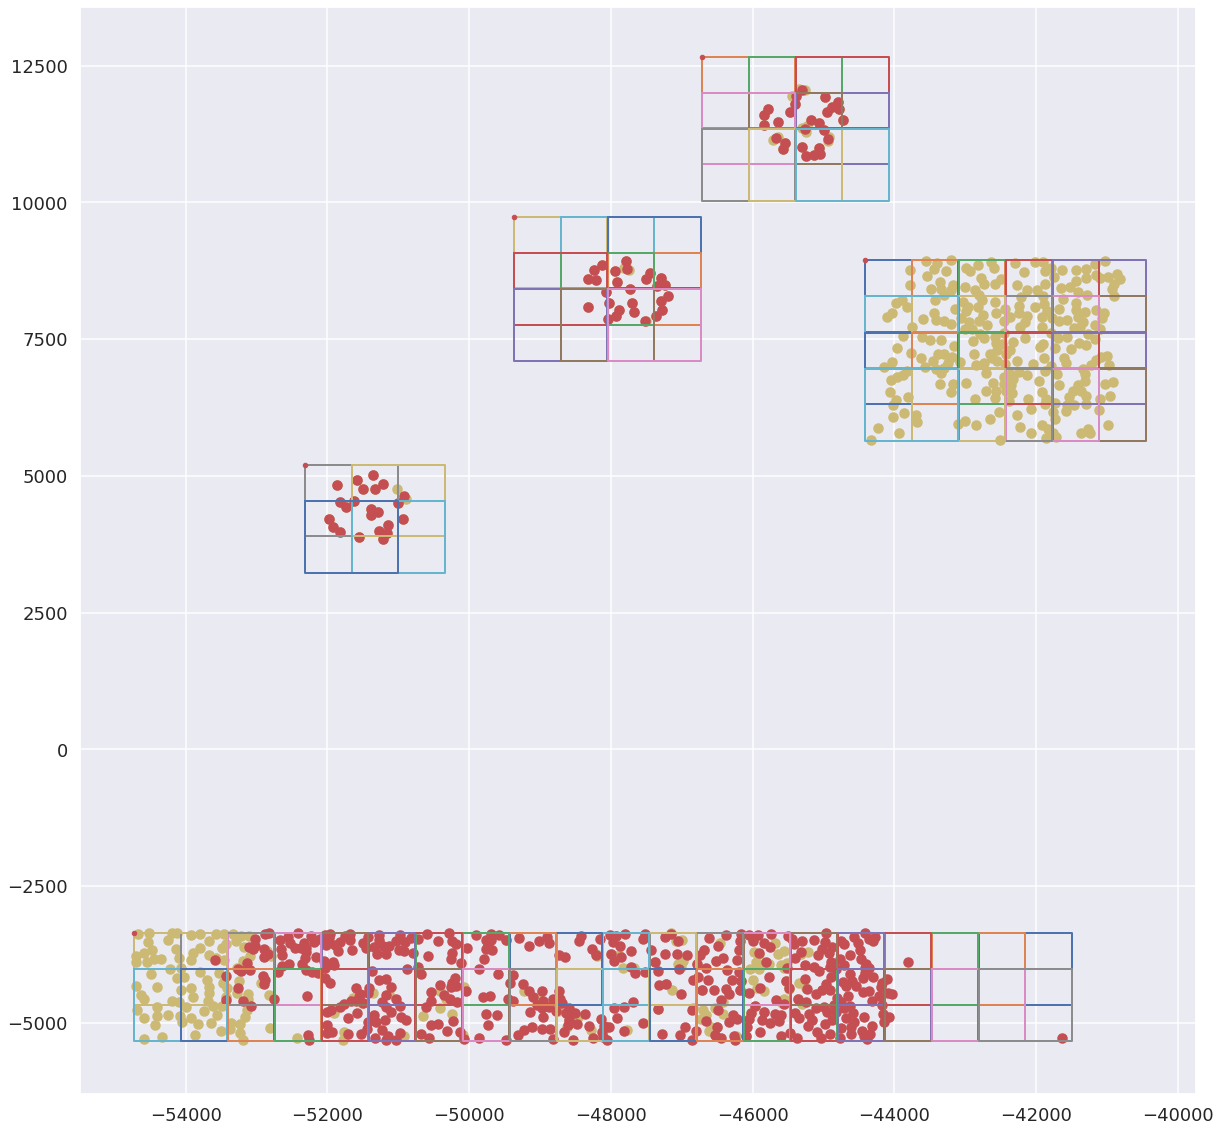

In [258]:
um_pix = 1.6*1.6
rect_x = np.array([0,um_pix*512,um_pix*512,0,0])
rect_y = np.array([0,0,um_pix*512,um_pix*512,0])
plt.figure(figsize=(20,20))
for pad_i in [0,1,3,4,5]:
    sub_df = cor_pos_df.groupby('pad').get_group(pad_i)
    for pos in sub_df.index:
        x0, y0 = sub_df.loc[pos,['x','y']]
        plt.plot(rect_x+x0, -(rect_y+y0))
    x, y = pad_pos_df.loc[pad_i,['x','y']]
    plt.plot(x, -y, '.r')

sub_col_df = df.groupby('frame').get_group(80)
cols = ['y','r']
for ind in sub_col_df.index:
    x, y, fluor, chan = sub_col_df.loc[ind,['x','y','fluor','channel']]
    if np.isnan(chan):
        continue
    plt.scatter(x,y,c=cols[np.int(chan)])

In [59]:
sub_col_df.loc[ind,['x','y']]

x            y
93187 -44482.652071 -9030.453008
93187 -43795.572460 -8964.972502

In [141]:

def label_helper(im_arr):
    uint_max = 65535
    im_arr = im_arr / uint_max
    w, h = im_arr.shape
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_arr, g_radius)
    thresh = skimage.filters.threshold_li(im_smooth)
    thresh = np.max([40/uint_max,thresh])
    im_bw = im_smooth > thresh
    if np.sum(im_bw) == 0 :
        return 0, 0
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

# pad_pos_df = cor_pos_df.groupby('pad').agg(np.min)
um_pix = 1.6*1.6
def process_tiff_stack(pad_ind, frames_vec):
    fn = '200303_pad{}.tif'.format(pad_ind)
    print('analyzing {}'.format(fn))
    x0, y0 = pad_pos_df.loc[pad_ind, ['x','y']]
    y0 = -y0
    columns = ['area', 'x','y','fluor','label','pad','channel','frame']
    df_list = []
    with skimage.external.tifffile.TiffFile(fn) as img:
        im_arr = img.asarray(memmap=True)
        _, h, w = im_arr.shape
        for frame_i in frames_vec:
            for chan_i in np.arange(n_chan):
                im_img = im_arr[frame_i*n_chan+chan_i,:,:]
                im_labeled, num = label_helper(im_img)
                if num == 0 :
                    continue
                # make df 
                index = np.arange(num)
                df = pd.DataFrame(columns=columns,index=index)
                regionprops_list = skimage.measure.regionprops(im_labeled)
                for label in np.arange(1,num+1):
                    regionprops = regionprops_list[label-1]
                    mask = im_labeled == label
                    fluor = np.mean(mask*im_img)
                    y, x = np.array((y0,x0)) + np.array([-1,1])*np.array(regionprops.centroid)*um_pix
                    df.loc[label-1,columns] = regionprops.area, x, y, fluor, label, pad_ind, chan_i, frame_i
                df_list.append(df)
    df_out = pd.concat(df_list, ignore_index=True).reset_index()
    df_out.to_csv('pad{}_stack_df.csv'.format(pad_ind),index=False)
    print('writing ' + 'pad{}_stack_df.csv'.format(pad_ind))
    return df_out

def par_worker(args):
    process_tiff_stack(*args)
    
with multiprocessing.Pool(4) as pool:
    args = [(xx, np.arange(n_frames)) for xx in [0,1,3,4,5]]
    res = pool.map(par_worker, args)
    pool.close()
    pool.join()
    
# dfs = [process_tiff_stack(xx, np.arange(n_frames-1)) for xx in np.arange(n_pads)]

analyzing 200303_pad0.tif
analyzing 200303_pad1.tif
analyzing 200303_pad3.tif
analyzing 200303_pad4.tif
writing pad4_stack_df.csv
analyzing 200303_pad5.tif
writing pad3_stack_df.csv
writing pad5_stack_df.csv
writing pad0_stack_df.csv
writing pad1_stack_df.csv


In [178]:
dfs = [pd.read_csv('pad{}_stack_df.csv'.format(xx),index_col=None) for xx in [0,1,3,4,5]]
df = pd.concat(dfs, ignore_index=True).reset_index()
time_df = files_df[['pad', 'frame','time']].groupby(['pad', 'frame']).agg(np.mean)
gb_padframe = df.groupby(['pad', 'frame'])
df['time'] = np.zeros(len(df))
for pad_ind in [0,1,3,4,5]:
    for frame in np.arange(n_frames):
        tpoint = time_df.loc[(pad_ind, frame), 'time']
        sub_key = (pad_ind, frame)
        if sub_key in gb_padframe.groups.keys():
            inds = gb_padframe.get_group((pad_ind, frame)).index
            df.loc[inds, 'time'] = tpoint

In [397]:
pad_pos_df = cor_pos_df.groupby('pad').agg(np.min)

n_rows = len(df)
df['dist'] = np.zeros(n_rows)
df['exp_pad'] = -np.ones(n_rows)
gb_pad = df.groupby('pad')

# pad 0
x0 = pad_pos_df.loc[0,'x']
for pad_ind in [0,3,4,5]:
    indx = gb_pad.get_group(pad_ind).index
    df.loc[indx,'dist'] = np.abs(x0-df.loc[indx, 'x'])
    df.loc[indx,'exp_pad'] = 0

# pad 1
x0 = pad_pos_df.loc[1,'x']
for pad_ind in [1]:
    indx = gb_pad.get_group(pad_ind).index
    df.loc[indx,'dist'] = np.abs(x0-df.loc[indx, 'x'])
    df.loc[indx,'exp_pad'] = 1

dist_vec = df.dist.values
dist_max = np.max(dist_vec)
dist_min = np.min(dist_vec)
n_bins = 500
dist_steps = (dist_max - dist_min)//n_bins
dist_bins = np.arange(dist_min, dist_max, (dist_max - dist_min)/n_bins)
df['dist_binned'] = dist_steps*(df['dist'].values // dist_steps)

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


 final_simplex: (array([[9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049354e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966151e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049350e-01]]), array([58872148.0902985 , 58872148.09029864, 58872148.09029874,
       58872148.09029879, 58872148.09029883, 58872148.09029886]))
           fun: 58872148.090298496
       message: 'Optimization terminated successfully.'
          nfev: 1825
           nit: 1119
        status: 0
       success: True
             x: array([9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
       5.6

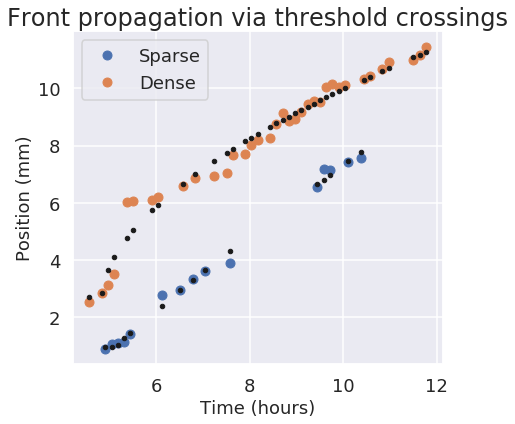

In [407]:
def fit_fun(t, p):
    a, b, c, d, e = p
    out_vec = np.ones(len(t))*a
    eval_bool = t > c/e
    out_vec[eval_bool] = a + b*np.power(e*t[eval_bool]-c, d)
    return out_vec

def res_fun(x, t, p, gamma=1e-1):
    a, b, c, d, e = p
    if np.any(np.array(p)<0):
        return np.inf
    if d < 0.4:
        return np.inf
    if b < 1e-5:
        return np.inf
    x_sim = fit_fun(t, p)
    res = np.power((x - x_sim)/gamma,2)
#     res = np.log(1+res)
    return np.sum(res)

def fit_wrapper(p, x, t):
    return res_fun(x, t, p)

def fitter(x, t):
    p0 = np.array([np.min(x)*0.8, 1.1*np.median(np.diff(x)/np.diff(t)), np.min(t)*0.8, 0.7, 1])
    fit = lambda p : fit_wrapper(p, x, t)
    out = scp.optimize.minimize(fit, x0=p0,method='Nelder-Mead',options={'maxiter':10000})
    return out

fig = plt.figure(figsize=(7,6))
sub_df = df.loc[df.area > 10,:]
sub_df = sub_df.loc[sub_df.channel==1,:]
sub_df.sort_values(by='time',inplace=True)
# thresh = skimage.filters.threshold_otsu(sub_df.fluor.values)
thresh = 0.1
sub_df = sub_df.loc[sub_df.fluor > thresh, :]
sub_df = sub_df.loc[sub_df.dist<12e3]
sub_df = sub_df.loc[sub_df.time<12*3600]

sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','frame')).agg(np.max).reset_index()
sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','dist_binned')).agg(np.min).reset_index()
gb_padexp = sub_df.groupby(['exp_pad', 'channel'])
labels = ['Sparse', 'Dense']
for label, key in zip(labels, gb_padexp.groups.keys()):
    plot_df = gb_padexp.get_group(key)
    x, t = plot_df.dist_binned.values, plot_df.time.values
    out = fitter(x, t)
    plt.plot(t/3600, x/1e3,'o',label=label)
#     plt.plot(t[:-1], np.diff(x)/np.diff(t),'o',label=key)
    x_sim = fit_fun(t, out.x)
    print(out)
    plt.plot(t/3600, x_sim/1e3, '.k')
plt.legend()
plt.title('Front propagation via threshold crossings')
plt.xlabel('Time (hours)')
plt.ylabel('Position (mm)')
# sub_df = df.groupby('exp_pad').get_group(1).copy()
# sub_df = sub_df.loc[sub_df.channel==1,:]
# sub_df = sub_df.loc[(sub_df.fluor > 0.1)&(sub_df.fluor <0.15),:]
# sub_df = sub_df.loc[sub_df.area > 10,:]
# plt.plot(sub_df.frame, sub_df.dist,'x')
# sub_df = df.groupby('exp_pad').get_group(0).copy()
# sub_df = sub_df.loc[sub_df.channel==1,:]
# sub_df = sub_df.loc[(sub_df.fluor > 0.1)&(sub_df.fluor <0.15),:]
# sub_df = sub_df.loc[sub_df.area > 10,:]
# plt.plot(sub_df.frame, sub_df.dist+2.5e3,'x')
fig.tight_layout()
# fig.savefig('threshold_crossing.png')

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


 final_simplex: (array([[9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049354e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049353e-01],
       [9.75652394e+02, 1.27966151e+00, 1.03953272e+04, 9.25853201e-01,
        5.61049350e-01]]), array([58872148.0902985 , 58872148.09029864, 58872148.09029874,
       58872148.09029879, 58872148.09029883, 58872148.09029886]))
           fun: 58872148.090298496
       message: 'Optimization terminated successfully.'
          nfev: 1825
           nit: 1119
        status: 0
       success: True
             x: array([9.75652394e+02, 1.27966150e+00, 1.03953272e+04, 9.25853201e-01,
       5.6

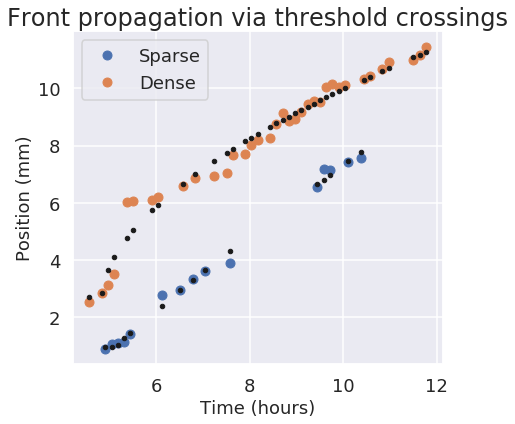

In [407]:
def fit_fun(t, p):
    a, b, c, d, e = p
    out_vec = np.ones(len(t))*a
    eval_bool = t > c/e
    out_vec[eval_bool] = a + b*np.power(e*t[eval_bool]-c, d)
    return out_vec

def res_fun(x, t, p, gamma=1e-1):
    a, b, c, d, e = p
    if np.any(np.array(p)<0):
        return np.inf
    if d < 0.4:
        return np.inf
    if b < 1e-5:
        return np.inf
    x_sim = fit_fun(t, p)
    res = np.power((x - x_sim)/gamma,2)
#     res = np.log(1+res)
    return np.sum(res)

def fit_wrapper(p, x, t):
    return res_fun(x, t, p)

def fitter(x, t):
    p0 = np.array([np.min(x)*0.8, 1.1*np.median(np.diff(x)/np.diff(t)), np.min(t)*0.8, 0.7, 1])
    fit = lambda p : fit_wrapper(p, x, t)
    out = scp.optimize.minimize(fit, x0=p0,method='Nelder-Mead',options={'maxiter':10000})
    return out

fig = plt.figure(figsize=(7,6))
sub_df = df.loc[df.area > 10,:]
sub_df = sub_df.loc[sub_df.channel==1,:]
sub_df.sort_values(by='time',inplace=True)
# thresh = skimage.filters.threshold_otsu(sub_df.fluor.values)
thresh = 0.1
sub_df = sub_df.loc[sub_df.fluor > thresh, :]
sub_df = sub_df.loc[sub_df.dist<12e3]
sub_df = sub_df.loc[sub_df.time<12*3600]

sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','frame')).agg(np.max).reset_index()
sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','dist_binned')).agg(np.min).reset_index()
gb_padexp = sub_df.groupby(['exp_pad', 'channel'])
labels = ['Sparse', 'Dense']
for label, key in zip(labels, gb_padexp.groups.keys()):
    plot_df = gb_padexp.get_group(key)
    x, t = plot_df.dist_binned.values, plot_df.time.values
    out = fitter(x, t)
    plt.plot(t/3600, x/1e3,'o',label=label)
#     plt.plot(t[:-1], np.diff(x)/np.diff(t),'o',label=key)
    x_sim = fit_fun(t, out.x)
    print(out)
    plt.plot(t/3600, x_sim/1e3, '.k')
plt.legend()
plt.title('Front propagation via threshold crossings')
plt.xlabel('Time (hours)')
plt.ylabel('Position (mm)')
# sub_df = df.groupby('exp_pad').get_group(1).copy()
# sub_df = sub_df.loc[sub_df.channel==1,:]
# sub_df = sub_df.loc[(sub_df.fluor > 0.1)&(sub_df.fluor <0.15),:]
# sub_df = sub_df.loc[sub_df.area > 10,:]
# plt.plot(sub_df.frame, sub_df.dist,'x')
# sub_df = df.groupby('exp_pad').get_group(0).copy()
# sub_df = sub_df.loc[sub_df.channel==1,:]
# sub_df = sub_df.loc[(sub_df.fluor > 0.1)&(sub_df.fluor <0.15),:]
# sub_df = sub_df.loc[sub_df.area > 10,:]
# plt.plot(sub_df.frame, sub_df.dist+2.5e3,'x')
fig.tight_layout()
fig.savefig('threshold_crossing.png')

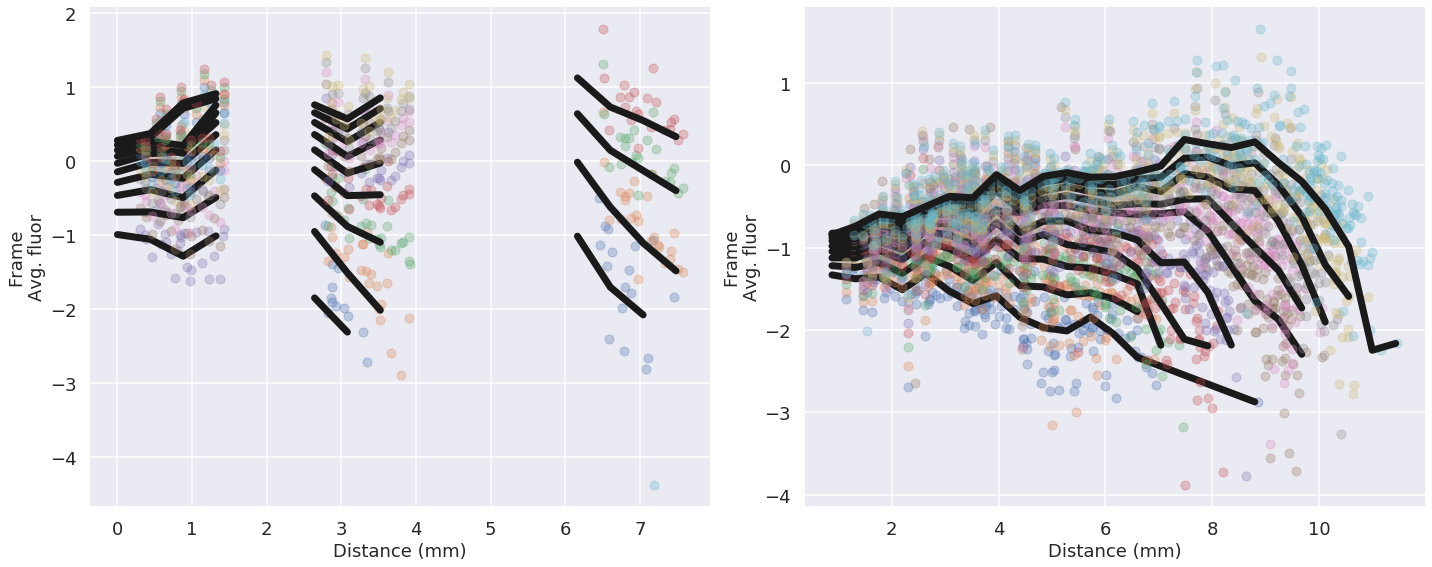

In [425]:
dist_vec = df.dist.values
dist_max = np.max(dist_vec)
dist_min = np.min(dist_vec)
n_bins = 30
dist_steps = (dist_max - dist_min)//n_bins
dist_bins = np.arange(dist_min, dist_max, (dist_max - dist_min)/n_bins)
df['dist_binned_coarse'] = dist_steps*(df['dist'].values // dist_steps)

fig, axs = plt.subplots(1,2,figsize=(20,8))
sub_df = df.copy()
# sub_df = df.loc[(df.area > 4e1),:]
sub_df = sub_df.loc[sub_df.channel==1,:]
sub_df.sort_values(by='time',inplace=True)
# thresh = skimage.filters.threshold_otsu(sub_df.fluor.values)
thresh = 0.1
# sub_df = sub_df.loc[sub_df.fluor > thresh, :]
sub_df = sub_df.loc[sub_df.dist<12e3]
# sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','frame')).agg(np.max).reset_index()
# sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','dist_binned')).agg(np.min).reset_index()
gb_padexp = sub_df.groupby(['exp_pad', 'channel'])
labels = ['Sparse', 'Dense']
sampl_frames = np.arange(40,90,5)
n_sampl_frames = len(sampl_frames)
for ax, label, key in zip(axs, labels, gb_padexp.groups.keys()):
    exppad_df = gb_padexp.get_group(key)
    gb_subpad = exppad_df.groupby('pad')
    for pad_ind in gb_subpad.groups.keys():
        pad_df = gb_subpad.get_group(pad_ind).copy()
        pad_df.sort_values(by='dist', inplace=True)
        fluor_max = 3#pad_df.fluor.max()
        gb_frame = pad_df.groupby('frame')
        for frame_i, frame in enumerate(sampl_frames):
            if frame not in gb_frame.groups.keys():
                continue
            plot_df = gb_frame.get_group(frame)
            x, y = plot_df.dist.values, plot_df.fluor.values
    #         out = fitter(x, t)
            ax.plot(x/1e3, np.log10(y) + 0*frame_i*fluor_max,'o',label=frame, alpha=0.3)
            agg_df = plot_df.groupby('dist_binned_coarse').agg(np.median).reset_index()
    #         y_filt = scp.signal.medfilt(y, 11)
            y_filt, x_filt = agg_df.fluor.values, agg_df.dist_binned_coarse.values
            ax.plot(x_filt/1e3, np.log10(y_filt) + 0*frame_i*fluor_max,'-k',label=frame, lw=7)
        #     plt.plot(t[:-1], np.diff(x)/np.diff(t),'o',label=key)
    #         x_sim = fit_fun(t, out.x)
    #         print(out)
    #         plt.plot(t/3600, x_sim/1e3, '.k')
#         ax.set_yticks(np.arange(n_sampl_frames)*fluor_max)
#         ax.set_yticklabels(sampl_frames)
#         ax.set_ylim([-fluor_max/3,(0.5+n_sampl_frames)*fluor_max])
        ax.set_ylabel('Frame\nAvg. fluor')
        ax.set_xlabel('Distance (mm)')

fig.tight_layout()
# fig.suptitle('Colony fluorescence distributions', fontsize=24)
fig.savefig('fluor_distributions.png')
# plt.title('Front propagation via threshold crossings')
# plt.xlabel('Time (hours)')
# plt.ylabel('Position (mm)')

Text(0.5, 0.98, 'Colony fluorescence distributions')

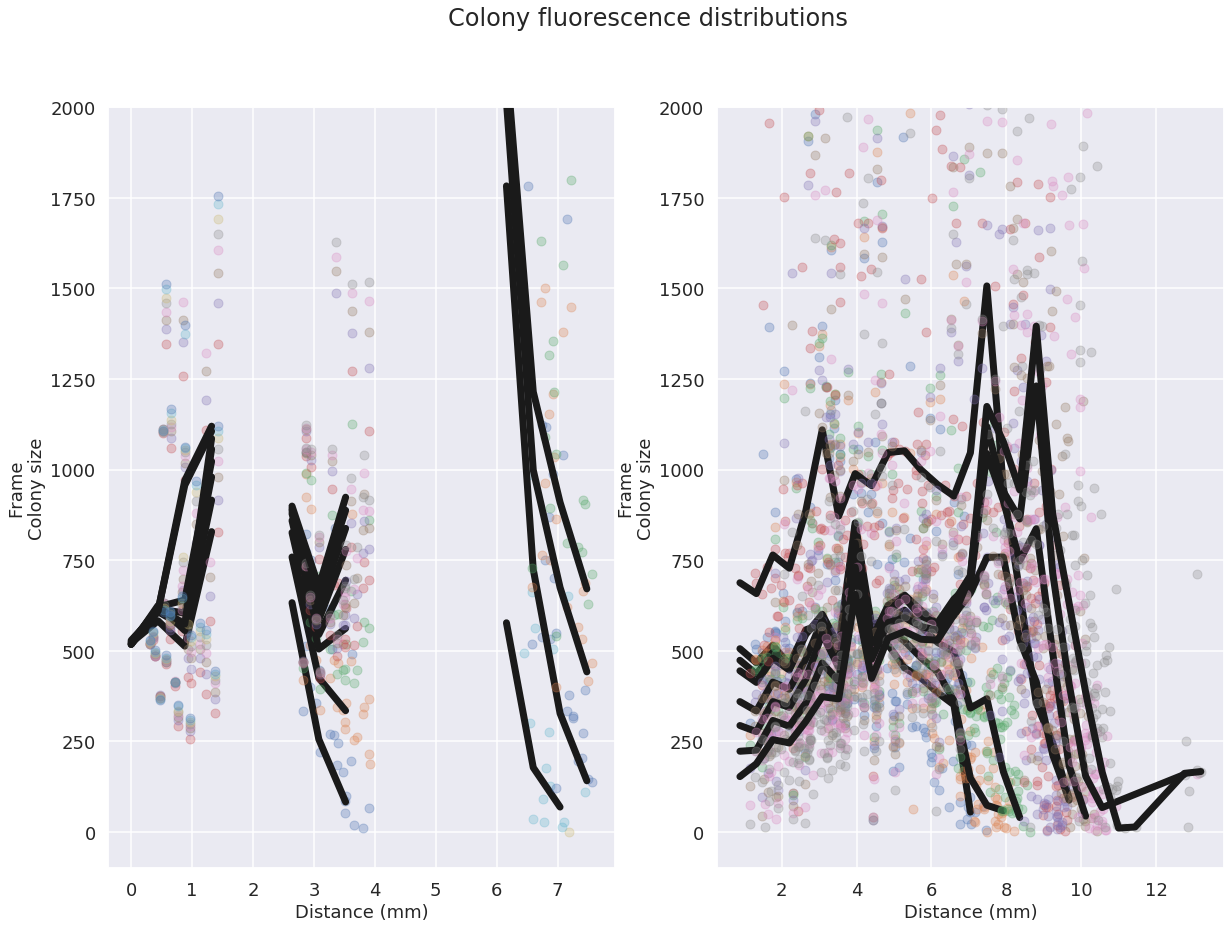

In [438]:
# Try similar treatment as above but for colony size 
# as a function of position at different timepoints

dist_vec = df.dist.values
dist_max = np.max(dist_vec)
dist_min = np.min(dist_vec)
n_bins = 30
dist_steps = (dist_max - dist_min)//n_bins
dist_bins = np.arange(dist_min, dist_max, (dist_max - dist_min)/n_bins)
df['dist_binned_coarse'] = dist_steps*(df['dist'].values // dist_steps)

fig, axs = plt.subplots(1,2,figsize=(20,14))
sub_df = df.copy()
# sub_df = df.loc[(df.area < 5e3),:]
sub_df = sub_df.loc[sub_df.channel==1,:]
sub_df.sort_values(by='time',inplace=True)
# thresh = skimage.filters.threshold_otsu(sub_df.fluor.values)
thresh = 0.1
# sub_df = sub_df.loc[sub_df.fluor > thresh, :]
# sub_df = sub_df.loc[sub_df.dist<12e3]
# sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','frame')).agg(np.max).reset_index()
# sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','dist_binned')).agg(np.min).reset_index()
gb_padexp = sub_df.groupby(['exp_pad', 'channel'])
labels = ['Sparse', 'Dense']
sampl_frames = np.arange(50,90,5)
n_sampl_frames = len(sampl_frames)
for ax, label, key in zip(axs, labels, gb_padexp.groups.keys()):
    exppad_df = gb_padexp.get_group(key)
    gb_subpad = exppad_df.groupby('pad')
    for pad_ind in gb_subpad.groups.keys():
        pad_df = gb_subpad.get_group(pad_ind).copy()
        pad_df.sort_values(by='dist', inplace=True)
        area_max = pad_df.area.max()
        gb_frame = pad_df.groupby('frame')
        for frame_i, frame in enumerate(sampl_frames):
            if frame not in gb_frame.groups.keys():
                continue
            plot_df = gb_frame.get_group(frame)
            x, y = plot_df.dist.values, plot_df.area.values
    #         out = fitter(x, t)
            ax.plot(x/1e3, y + 0*frame_i*area_max,'o',label=frame, alpha=0.3)
            agg_df = plot_df.groupby('dist_binned_coarse').agg(np.median).reset_index()
    #         y_filt = scp.signal.medfilt(y, 11)
            y_filt, x_filt = agg_df.area.values, agg_df.dist_binned_coarse.values
            ax.plot(x_filt/1e3, y_filt + 0*frame_i*area_max,'-k',label=frame, lw=7)
        #     plt.plot(t[:-1], np.diff(x)/np.diff(t),'o',label=key)
    #         x_sim = fit_fun(t, out.x)
    #         print(out)
    #         plt.plot(t/3600, x_sim/1e3, '.k')
#         ax.set_yticks(np.arange(n_sampl_frames)*area_max)
#         ax.set_yticklabels(sampl_frames)
#         ax.set_ylim([-area_max/3,(0.5+n_sampl_frames)*area_max])
        ax.set_ylim([-1e2,2e3])
        ax.set_ylabel('Frame\nColony size')
        ax.set_xlabel('Distance (mm)')
fig.suptitle('Colony fluorescence distributions', fontsize=24)
# plt.title('Front propagation via threshold crossings')
# plt.xlabel('Time (hours)')
# plt.ylabel('Position (mm)')

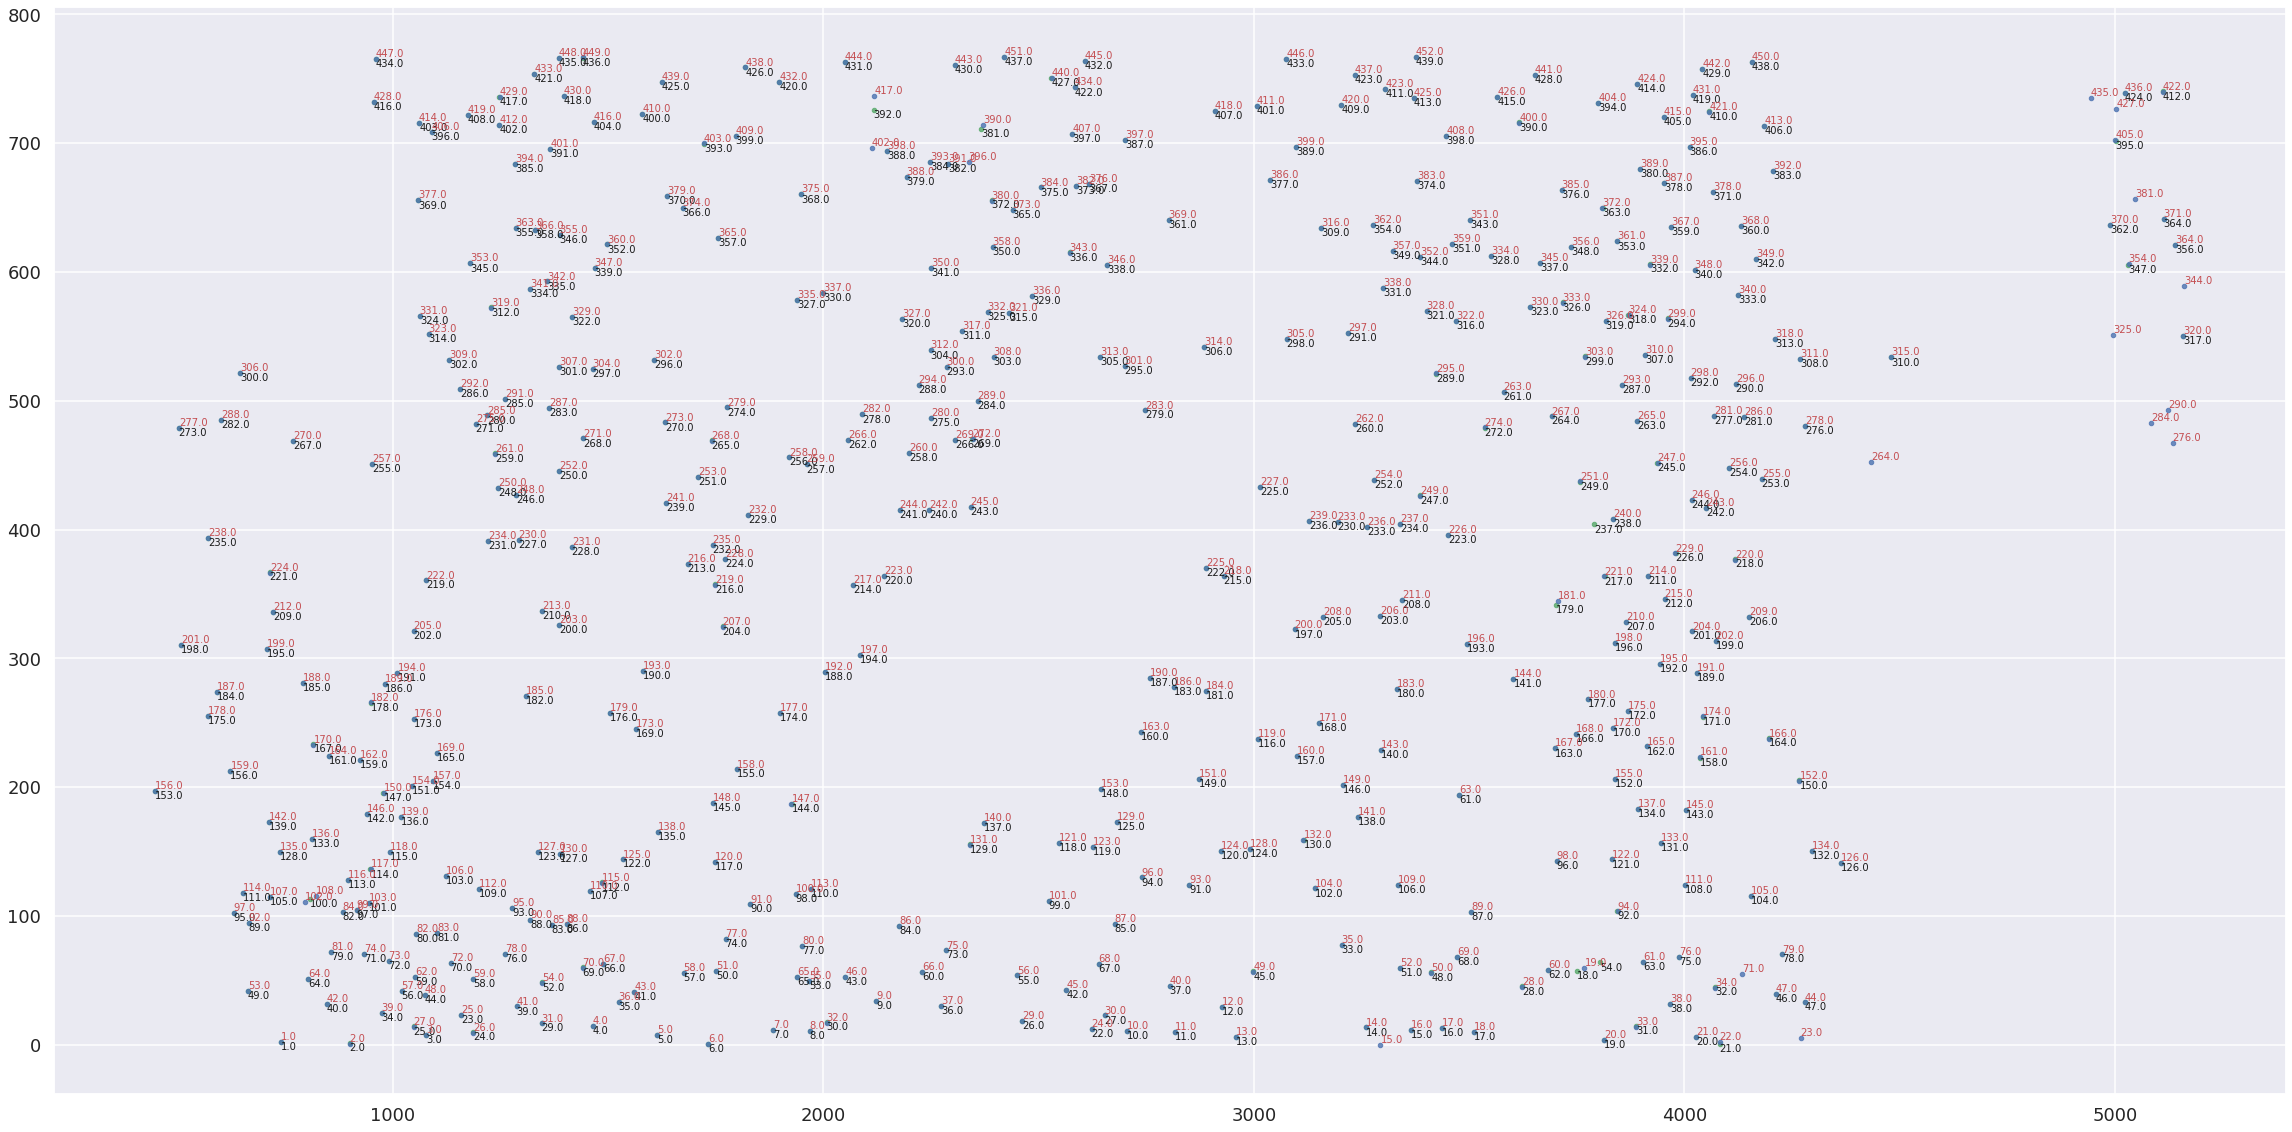

In [468]:
gb_pfc = df.groupby(['pad','frame','channel'])
def plot_col_img(pad, frame_in, chan):
    plt.figure(figsize=(40,20))
    pcol = ['g','b']
    tcol = ['k','r']
    va = ['top','bottom']
    for f0 in [0,1]:
        x0, y0 = pad_pos_df.loc[pad,['x','y']]
        sub_df = gb_pfc.get_group((pad, frame+f0, chan))
#         pad = pads[pad]
#         im_arr = pad.get_frame(frame+f0, chan)
#         h, w = im_arr.shape
#         plt.imshow(im_arr,vmin=40,vmax=1e3)
        plt.plot((sub_df.x-x0)/2.56, (-sub_df.y-y0)/2.56,pcol[f0]+'.',alpha=0.8)
        for i in sub_df.index:
            x, y, lab_str = sub_df.loc[i, ['x','y','label']]
            plt.text((x-x0)/2.56, (-y-y0)/2.56,lab_str,{'color':tcol[f0],'va':va[f0]})
    
plot_col_img(1, 50, 1)


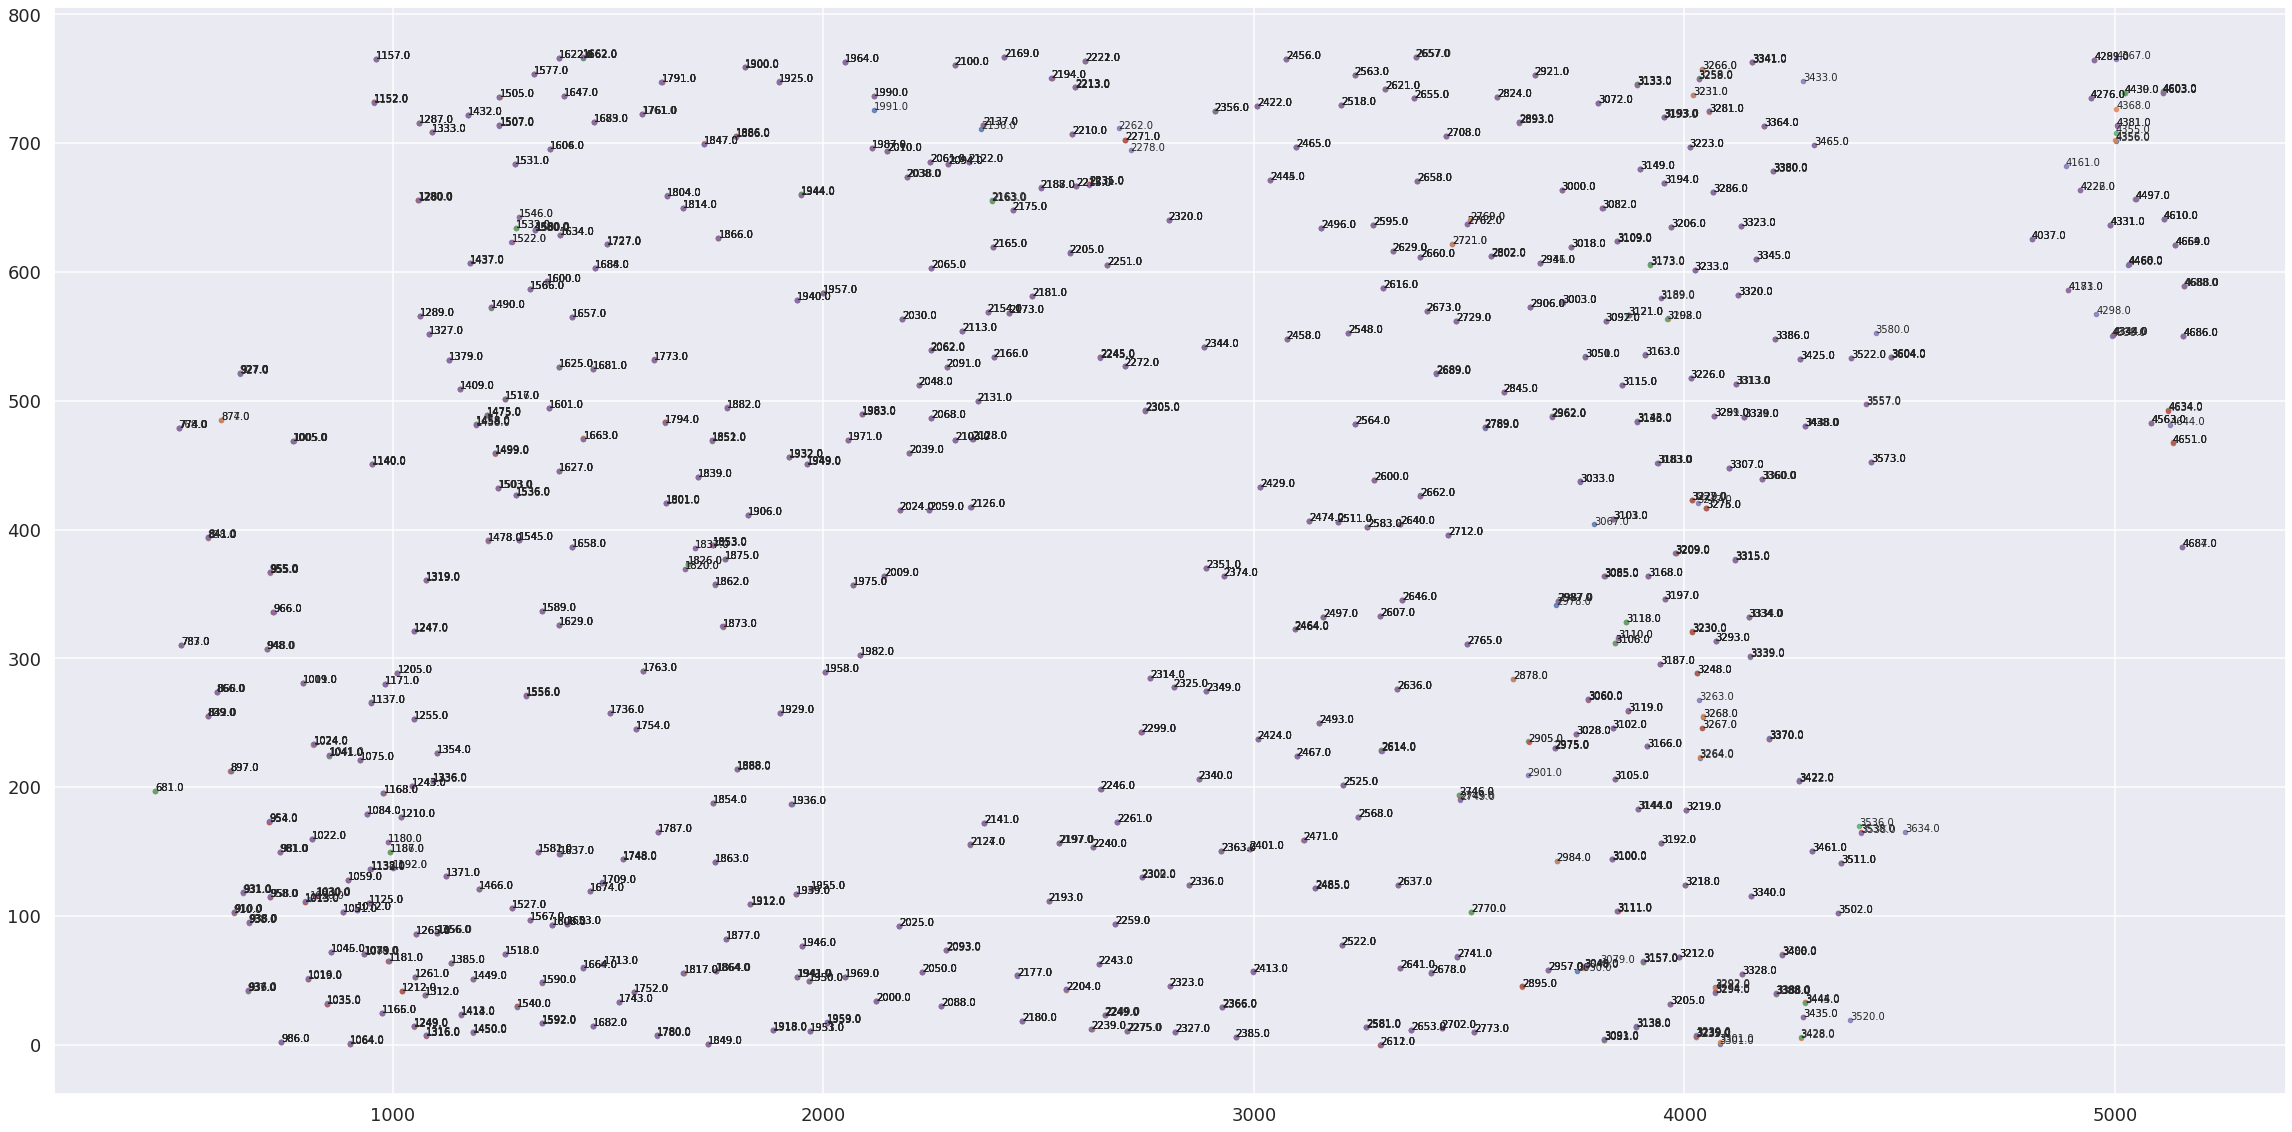

In [509]:
# Attempt lineage tracing
# For each colony at each frame, select a region 12x12 um square 
# in the subsequent frame to look for nearest neighbors
df['xgrid1'] = np.round(df['x']/12)*12
df['xgrid2'] = np.round((df['x']+6)/12)*12
df['ygrid1'] = np.round(df['y']/12)*12
df['ygrid2'] = np.round((df['x']+6)/12)*12

# First attempt : colonies in the same grid are the same lineage?
gb_twogrids = df.groupby(['xgrid1', 'xgrid2', 'ygrid1', 'ygrid2'])
for group_i, indx in enumerate(gb_twogrids.groups.values()):
    df.loc[indx, 'cluster'] = group_i
    
gb_pfc = df.groupby(['pad','frame','channel'])
def plot_col_img(pad, frame_in, chan):
    plt.figure(figsize=(40,20))
    pcol = ['g','b']
    tcol = ['k','r']
    va = ['top','bottom']
    for f0 in np.arange(5):
        x0, y0 = pad_pos_df.loc[pad,['x','y']]
        sub_df = gb_pfc.get_group((pad, frame+f0, chan))
#         pad = pads[pad]
#         im_arr = pad.get_frame(frame+f0, chan)
#         h, w = im_arr.shape
#         plt.imshow(im_arr,vmin=40,vmax=1e3)
        plt.plot((sub_df.x-x0)/2.56, (-sub_df.y-y0)/2.56,'.',alpha=0.8)
        for i in sub_df.index:
            x, y, lab_str = sub_df.loc[i, ['x','y','cluster']]
            plt.text((x-x0)/2.56, (-y-y0)/2.56,lab_str)
    
plot_col_img(1, 50, 1)


<Figure size 432x288 with 0 Axes>

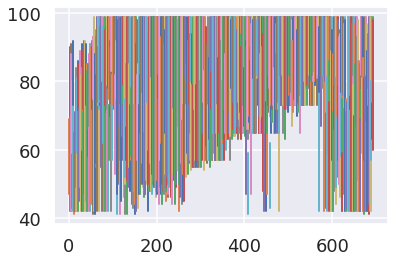

<Figure size 432x288 with 0 Axes>

In [528]:
gb_cluster = df.groupby('cluster')
x = 0
labs = []
for lin_i, lin_df in gb_cluster:
    max_frame, min_frame = lin_df.frame.max(), lin_df.frame.min()
    if (max_frame - min_frame) > 15 and min_frame > 40:
        plt.plot([x,x], [lin_df.frame.min(), lin_df.frame.max()])
        labs.append(lin_i)
        x += 1
n_labs = len(labs)

plt.figure()    
# plt.xticks(np.arange(n_labs),labs)

In [529]:
derivdf_list = []
df['lineage'] = np.zeros(len(df))
df['dfluordt'] = np.zeros(len(df))
df['stage'] = np.zeros(len(df))
for lin_i in labs:
    lin_df = gb_cluster.get_group(lin_i).copy()
    gb_chan = lin_df.groupby('channel')
    for chan, chan_df in gb_chan:
        chan_df = chan_df.copy()
        chan_df.sort_values(by='time',inplace=True)
        # continuity vec should be 1 on a frame where a new chain
        # of good tracking begins
        continuity_vec = np.zeros(len(chan_df))
        continuity_vec[:-1] = np.diff(chan_df.frame.values) != 1
        # Take the CDF of continuity vec to uniquely label each good-tracking
        # stretch
        stage_vec = np.array([np.sum(continuity_vec[:xx]) for xx in np.arange(len(chan_df))])
        chan_df['stage'] = stage_vec+1
        t_vec, y_vec = chan_df[['time','fluor']].values.T
        dydt_vec = np.diff(y_vec)/np.diff(t_vec)
        chan_df.loc[chan_df.index[1:],'dfluordt'] = dydt_vec
        df.loc[chan_df.index, 'stage'] = chan_df.loc[chan_df.index,'stage']
        df.loc[chan_df.index, 'dfluordt'] = chan_df.loc[chan_df.index,'dfluordt']

gb_cluster_stage = df.groupby(['cluster', 'stage'])
for group_i, indx in enumerate(gb_cluster_stage.groups.values()):
    df.loc[indx, 'lineage'] = group_i

/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/home/jmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


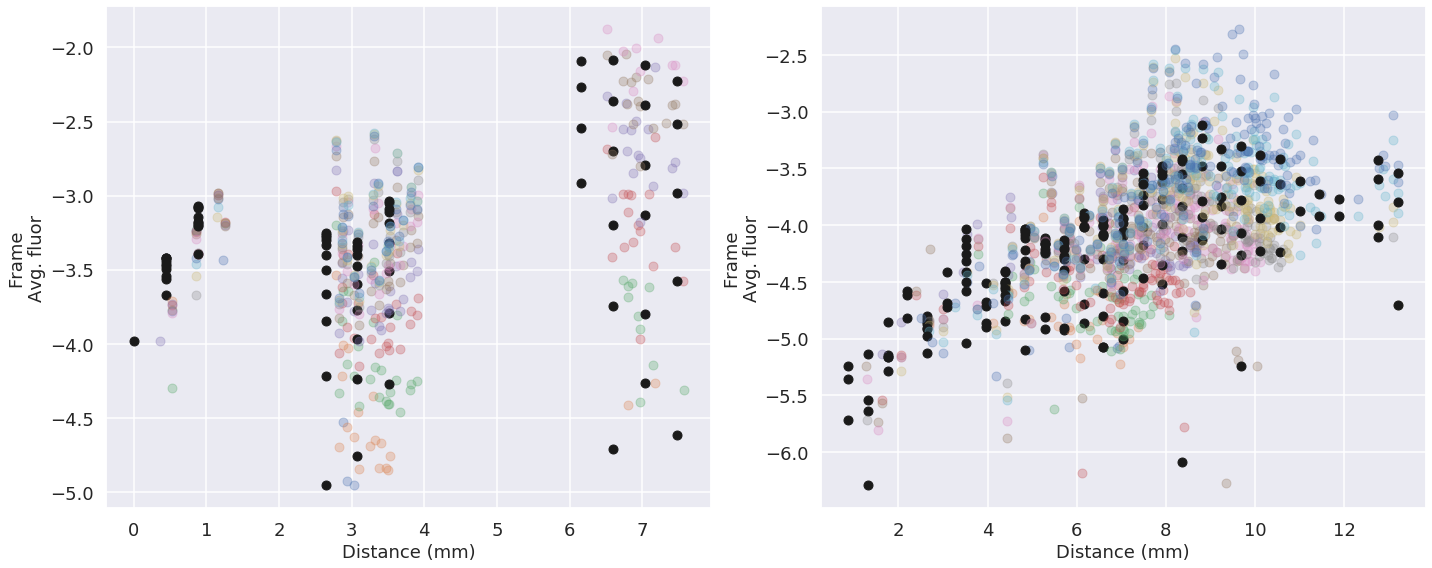

In [534]:
# dist_vec = df.dist.values
# dist_max = np.max(dist_vec)
# dist_min = np.min(dist_vec)
# n_bins = 30
# dist_steps = (dist_max - dist_min)//n_bins
# dist_bins = np.arange(dist_min, dist_max, (dist_max - dist_min)/n_bins)
# df['dist_binned_coarse'] = dist_steps*(df['dist'].values // dist_steps)

fig, axs = plt.subplots(1,2,figsize=(20,8))
sub_df = df.copy()
# sub_df = df.loc[(df.area > 4e1),:]
sub_df = sub_df.loc[sub_df.channel==1,:]
sub_df.sort_values(by='time',inplace=True)
# thresh = skimage.filters.threshold_otsu(sub_df.fluor.values)
thresh = 0.1
# sub_df = sub_df.loc[sub_df.fluor > thresh, :]
# sub_df = sub_df.loc[sub_df.dist<12e3]
sub_df = sub_df.loc[sub_df.stage > 0]
# sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','frame')).agg(np.max).reset_index()
# sub_df = sub_df[['exp_pad', 'dist_binned', 'channel','frame','time']].groupby(('exp_pad','channel','dist_binned')).agg(np.min).reset_index()
gb_padexp = sub_df.groupby(['exp_pad', 'channel'])
labels = ['Sparse', 'Dense']
sampl_frames = np.arange(40,100,5)
n_sampl_frames = len(sampl_frames)
for ax, label, key in zip(axs, labels, gb_padexp.groups.keys()):
    exppad_df = gb_padexp.get_group(key)
    gb_subpad = exppad_df.groupby('pad')
    for pad_ind in gb_subpad.groups.keys():
        pad_df = gb_subpad.get_group(pad_ind).copy()
        pad_df.sort_values(by='dist', inplace=True)
        fluor_max = 3#pad_df.fluor.max()
        gb_frame = pad_df.groupby('frame')
        for frame_i, frame in enumerate(sampl_frames):
            if frame not in gb_frame.groups.keys():
                continue
            plot_df = gb_frame.get_group(frame)
            x, y = plot_df.dist.values, plot_df.dfluordt.values
    #         out = fitter(x, t)
            ax.plot(x/1e3, np.log10(y) + 0*frame_i*fluor_max,'o',label=frame, alpha=0.3)
            agg_df = plot_df.groupby('dist_binned_coarse').agg(np.median).reset_index()
    #         y_filt = scp.signal.medfilt(y, 11)
            y_filt, x_filt = agg_df.dfluordt.values, agg_df.dist_binned_coarse.values
            ax.plot(x_filt/1e3, np.log10(y_filt) + 0*frame_i*fluor_max,'ok',label=frame, lw=7)
        #     plt.plot(t[:-1], np.diff(x)/np.diff(t),'o',label=key)
    #         x_sim = fit_fun(t, out.x)
    #         print(out)
    #         plt.plot(t/3600, x_sim/1e3, '.k')
#         ax.set_yticks(np.arange(n_sampl_frames)*fluor_max)
#         ax.set_yticklabels(sampl_frames)
#         ax.set_ylim([-fluor_max/3,(0.5+n_sampl_frames)*fluor_max])
        ax.set_ylabel('Frame\nAvg. fluor')
        ax.set_xlabel('Distance (mm)')

fig.tight_layout()
# fig.suptitle('Colony fluorescence distributions', fontsize=24)
# fig.savefig('fluor_distributions.png')
# plt.title('Front propagation via threshold crossings')
# plt.xlabel('Time (hours)')
# plt.ylabel('Position (mm)')

In [521]:
df.dfluordt.max()

0.0007754847534553673